In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.linalg import expm, cosm
#from scipy.special import result

In [13]:
def compute_eigenstate_fidelities_by_r(m=6, n=4, r_list=[0, 1, 2, 3, 4]):
    """Return fidelity with each eigenstate for each Grover iteration r."""
    results = {}

    # Step 1: Prepare LCU weights
    k_vals = np.arange(-m, m + 1)
    alpha_k = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals])
    alpha_k /= np.sum(alpha_k)

    n_lcu = len(alpha_k)
    n_anc = int(np.ceil(np.log2(n_lcu)))
    pad_len = 2 ** n_anc
    weights = np.sqrt(np.pad(alpha_k, (0, pad_len - n_lcu)))
    weights /= np.linalg.norm(weights)
    n_total = n + n_anc

    # Step 2: Build and normalize Hamiltonian
    coeffs, ops = [], []
    for i in range(n - 1):
        coeffs.append(-1.0)
        ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
    for i in range(n):
        coeffs.append(-1.0)
        ops.append(qml.PauliX(i))
    H = qml.Hamiltonian(coeffs, ops)
    H_mat = qml.matrix(H)
    λ_min, λ_max = np.min(np.linalg.eigvalsh(H_mat)), np.max(np.linalg.eigvalsh(H_mat))
    H_norm = (H_mat - λ_min * np.eye(2**n)) / (λ_max - λ_min)
    H_norm -= np.min(np.linalg.eigvalsh(H_norm)) * np.eye(2**n)
    eigvals, eigvecs = np.linalg.eigh(H_norm)

    # Step 3: LCU SELECT unitaries
    U_list = [expm(2j * k * H_norm) for k in k_vals]
    while len(U_list) < pad_len:
        U_list.append(np.eye(2 ** n))

    # Step 4: PennyLane QNode for PREP
    dev = qml.device("default.qubit", wires=n_total)

    @qml.qnode(dev)
    def prep_state():
        for i in range(n):
            qml.Hadamard(i)
        qml.MottonenStatePreparation(weights, wires=range(n, n + n_anc))
        for idx, U in enumerate(U_list):
            bin_str = format(idx, f"0{n_anc}b")
            ctrl = [n + i for i, b in enumerate(bin_str) if b == '1']
            qml.ControlledQubitUnitary(U, control_wires=ctrl, wires=range(n))
        qml.adjoint(qml.MottonenStatePreparation)(weights, wires=range(n, n + n_anc))
        return qml.state()

    # Step 5: Apply Grover operator Q = -RS RΠ
    psi0 = prep_state()
    RS = 2 * np.outer(psi0, psi0.conj()) - np.eye(2 ** n_total)
    Π = np.zeros((2 ** n_total,))
    Π[:2 ** n] = 1.0
    RΠ = np.eye(2 ** n_total) - 2 * np.diag(Π)
    Q = -RS @ RΠ

    for r in r_list:
        psi = psi0.copy()
        for _ in range(r):
            psi = Q @ psi
        reshaped = psi.reshape((2 ** n, 2 ** n_anc))
        system_state = reshaped[:, 0]  # ancilla = 000
        system_state = system_state / np.linalg.norm(system_state)
        fidelities = np.abs(eigvecs.conj().T @ system_state) ** 2  # |<λ_i | ψ_r>|^2
        results[r] = fidelities

    return results

def plot_fidelity_per_eigenstate_subplots(fidelity_data):
    """
    Plot fidelity with each eigenstate across multiple Grover iterations.
    Each subplot shows a bar chart of fidelities at a specific r.
    """
    r_vals = sorted(fidelity_data.keys())
    num_subplots = len(r_vals)
    num_eigenstates = len(next(iter(fidelity_data.values())))

    fig, axs = plt.subplots(1, num_subplots, figsize=(4 * num_subplots, 4), sharey=True)

    for idx, r in enumerate(r_vals):
        ax = axs[idx] if num_subplots > 1 else axs
        fidelities = fidelity_data[r]
        ax.bar(np.arange(num_eigenstates), fidelities)
        ax.set_title(f"r = {r}")
        ax.set_xlabel("Eigenstate Index")
        if idx == 0:
            ax.set_ylabel("Fidelity $|\\langle \\lambda_i | \\psi_r \\rangle|^2$")
        ax.set_xticks(np.arange(num_eigenstates))
        ax.grid(True)

    fig.suptitle("Eigenstate Fidelity Distribution vs Grover Iteration", fontsize=14)
    plt.tight_layout()
    plt.show()
def plot_fidelity_per_eigenstate_grid(fidelity_data, n_cols=2):
    """
    Plot eigenstate fidelity bar charts in a grid layout.
    Automatically chooses rows based on number of r values and n_cols.

    Parameters:
    - fidelity_data: dict {r: [f_0, f_1, ..., f_{2^n-1}]}
    - n_cols: number of columns in the subplot grid
    """
    r_vals = sorted(fidelity_data.keys())
    num_subplots = len(r_vals)
    num_eigenstates = len(next(iter(fidelity_data.values())))

    n_rows = math.ceil(num_subplots / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey=True)
    axs = axs.flatten()

    for idx, r in enumerate(r_vals):
        ax = axs[idx]
        fidelities = fidelity_data[r]
        ax.bar(np.arange(num_eigenstates), fidelities)
        ax.set_title(f"r = {r}")
        ax.set_xlabel("Eigenstate Index")
        if idx % n_cols == 0:
            ax.set_ylabel("Fidelity $|\\langle \\lambda_i | \\psi_r \\rangle|^2$")
        ax.set_xticks(np.arange(num_eigenstates))
        ax.grid(True)

    # Hide unused subplots (if total r < rows * cols)
    for idx in range(len(r_vals), len(axs)):
        axs[idx].axis("off")

    fig.suptitle("Eigenstate Fidelity Distribution vs Grover Iteration", fontsize=14)
    plt.tight_layout()
    plt.show()
fidelity_data = compute_eigenstate_fidelities_by_r(m=6, n=4, r_list=[0, 1, 2, 3, 4, 5])
plot_fidelity_per_eigenstate_grid(fidelity_data, n_cols=2)

TypeError: ControlledQubitUnitary.__init__() got an unexpected keyword argument 'control_wires'

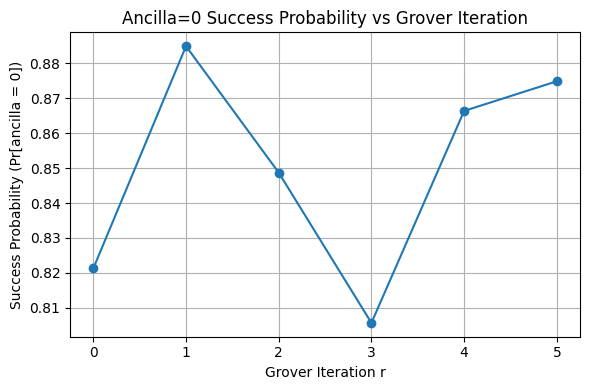

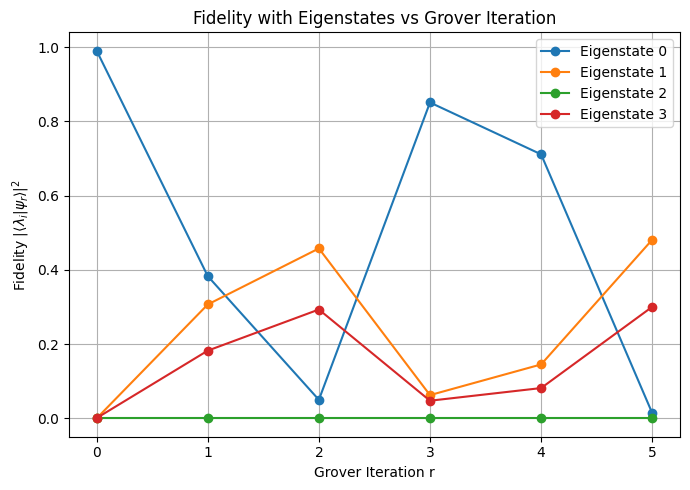

In [3]:
def compute_eigenstate_fidelities_by_r(m=6, n=4, r_list=[0, 1, 2, 3, 4]):
    """Return fidelity with each eigenstate and ancilla=0 success probability per Grover iteration r."""
    results = {}

    # Step 1: Prepare LCU weights
    k_vals = np.arange(-m, m + 1)
    alpha_k = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals])
    alpha_k /= np.sum(alpha_k)

    n_lcu = len(alpha_k)
    n_anc = int(np.ceil(np.log2(n_lcu)))
    pad_len = 2 ** n_anc
    weights = np.sqrt(np.pad(alpha_k, (0, pad_len - n_lcu)))
    weights /= np.linalg.norm(weights)
    n_total = n + n_anc

    # Step 2: Build and normalize Hamiltonian
    coeffs, ops = [], []
    for i in range(n - 1):
        coeffs.append(-1.0)
        ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
    for i in range(n):
        coeffs.append(-1.0)
        ops.append(qml.PauliX(i))
    H = qml.Hamiltonian(coeffs, ops)
    H_mat = qml.matrix(H)
    λ_min, λ_max = np.min(np.linalg.eigvalsh(H_mat)), np.max(np.linalg.eigvalsh(H_mat))
    H_norm = (H_mat - λ_min * np.eye(2**n)) / (λ_max - λ_min)
    H_norm -= np.min(np.linalg.eigvalsh(H_norm)) * np.eye(2**n)
    eigvals, eigvecs = np.linalg.eigh(H_norm)

    # Step 3: LCU SELECT unitaries
    U_list = [expm(2j * k * H_norm) for k in k_vals]
    while len(U_list) < pad_len:
        U_list.append(np.eye(2 ** n))

    # Step 4: PennyLane QNode for PREP
    dev = qml.device("default.qubit", wires=n_total)

    @qml.qnode(dev)
    def prep_state():
        for i in range(n):
            qml.Hadamard(i)
        qml.MottonenStatePreparation(weights, wires=range(n, n + n_anc))
        for idx, U in enumerate(U_list):
            bin_str = format(idx, f"0{n_anc}b")
            ctrl = [n + i for i, b in enumerate(bin_str) if b == '1']
            qml.ControlledQubitUnitary(U, control_wires=ctrl, wires=range(n))
        qml.adjoint(qml.MottonenStatePreparation)(weights, wires=range(n, n + n_anc))
        return qml.state()

    # Step 5: Apply Grover operator Q = -RS RΠ
    psi0 = prep_state()
    RS = 2 * np.outer(psi0, psi0.conj()) - np.eye(2 ** n_total)
    Π = np.zeros((2 ** n_total,))
    Π[:2 ** n] = 1.0
    RΠ = np.eye(2 ** n_total) - 2 * np.diag(Π)
    Q = -RS @ RΠ


    for r in r_list:
        psi = psi0.copy()
        for _ in range(r):
            psi = Q @ psi
        reshaped = psi.reshape((2 ** n, 2 ** n_anc))
        system_unnorm = reshaped[:, 0]  # ancilla = 000...0
        success_prob = np.sum(np.abs(system_unnorm) ** 2)
        system_state = system_unnorm / np.linalg.norm(system_unnorm)
        fidelities = np.abs(eigvecs.conj().T @ system_state) ** 2
        results[r] = {
            'fidelities': fidelities,
            'success_prob': success_prob
        }

    return results
def plot_fidelities_vs_r_multi(fidelity_data, eigenstate_indices=None):
    """
    Plot fidelity vs Grover iteration for multiple eigenstates.

    Parameters:
    - fidelity_data: dict {r: {'fidelities': [...], 'success_prob': float}}
    - eigenstate_indices: list of eigenstate indices to plot (default = [0, 1, 2, ..., N-1])
    """
    r_vals = sorted(fidelity_data.keys())
    n_eigenstates = len(next(iter(fidelity_data.values()))['fidelities'])

    if eigenstate_indices is None:
        eigenstate_indices = list(range(n_eigenstates))  # 默认绘制所有

    plt.figure(figsize=(7, 5))

    for idx in eigenstate_indices:
        fidelities = [fidelity_data[r]['fidelities'][idx] for r in r_vals]
        plt.plot(r_vals, fidelities, marker='o', label=f"Eigenstate {idx}")

    plt.title("Fidelity with Eigenstates vs Grover Iteration")
    plt.xlabel("Grover Iteration r")
    plt.ylabel("Fidelity $|\\langle \\lambda_i | \\psi_r \\rangle|^2$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_success_vs_r(fidelity_data):
    """
    Plot ancilla=0 success probability vs Grover iteration r.

    Parameters:
    - fidelity_data: dict {r: {'fidelities': [...], 'success_prob': float}}
    """
    r_vals = sorted(fidelity_data.keys())
    success_probs = [fidelity_data[r]['success_prob'] for r in r_vals]

    plt.figure(figsize=(6, 4))
    plt.plot(r_vals, success_probs, marker='o')
    plt.title("Ancilla=0 Success Probability vs Grover Iteration")
    plt.xlabel("Grover Iteration r")
    plt.ylabel("Success Probability (Pr[ancilla = 0])")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

fidelity_data = compute_eigenstate_fidelities_by_r(m=6, n=4, r_list=[0, 1, 2, 3, 4, 5])
plot_success_vs_r(fidelity_data)
plot_fidelities_vs_r_multi(fidelity_data, [0, 1, 2, 3])

In [19]:
import csv
def save_fidelity_data_to_csv(fidelity_data, filename="fidelity_data.csv"):
    # 提取所有迭代步数
    r_vals = sorted(fidelity_data.keys())
    # 本征态数量
    n_eigenstates = len(fidelity_data[r_vals[0]]['fidelities'])

    with open(filename, mode='w', newline='') as f:
        writer = csv.writer(f)
        # 写表头
        header = ['r'] + [f'fidelity_{i}' for i in range(n_eigenstates)] + ['success_prob']
        writer.writerow(header)

        # 写数据行
        for r in r_vals:
            row = [r]
            row.extend(fidelity_data[r]['fidelities'])
            row.append(fidelity_data[r]['success_prob'])
            writer.writerow(row)

# 调用计算函数
fidelity_data = compute_eigenstate_fidelities_by_r(m=6, n=4, r_list=[0, 1, 2, 3, 4, 5])
# 保存到CSV文件
save_fidelity_data_to_csv(fidelity_data, filename="fidelity_data.csv")

In [121]:
import math
import pennylane as qml
from pennylane import numpy as np
from scipy.linalg import expm

n = 4  # system qubits
m = 6  # for cos^{2m}(H)
k_vals = np.arange(-m, m + 1)
alpha_k = 2**(-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals])
k_vals = [k for k in range(-m, m + 1) if alpha_k[k + m] > 1e-4]
# Step 1: Build and normalize Hamiltonian
coeffs, ops = [], []
for i in range(n - 1):
    coeffs.append(-1.0)
    ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
for i in range(n):
    coeffs.append(-1.0)
    ops.append(qml.PauliX(i))
H_tfim = qml.Hamiltonian(coeffs, ops)
H_mat_raw = qml.matrix(H_tfim)
eigvals = np.linalg.eigvalsh(H_mat_raw)
λ_min, λ_max = np.min(eigvals), np.max(eigvals)
H_mat = (H_mat_raw - λ_min * np.eye(2**n)) / (λ_max - λ_min)  # Normalize to [0,1]
H_eigs, H_vecs = np.linalg.eigh(H_mat)
λ0 = np.min(H_eigs)
H_mat -= λ0 * np.eye(2**n)  # shift ground energy to 0
H_eigs, H_vecs = np.linalg.eigh(H_mat)
# Step 2: pad alpha_k to next power of 2
pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))  # 8
alpha_padded = np.zeros(pad_len)
alpha_padded[:len(alpha_k)] = alpha_k
weights = np.sqrt(alpha_padded / np.sum(alpha_padded))

n_anc = int(np.log2(len(alpha_padded)))  # 4 ancilla qubits
dev = qml.device("default.qubit", wires=n + n_anc)

@qml.qnode(dev)
def circuit():
    # Trial state: Hadamard on all system qubits
    for i in range(n):
        qml.Hadamard(i)

    # PREP: Mottonen state on ancilla
    qml.MottonenStatePreparation(weights, wires=range(n, n + n_anc))

    # SELECT: controlled unitaries (identity for padded ones)
    U_list = [expm(2j * (k - m) * H_mat) for k in range(len(alpha_k))]  # real unitaries
    for _ in range(pad_len - len(U_list)):
        U_list.append(np.eye(2**n))  # padded identity

    for idx, U in enumerate(U_list):
        bin_str = format(idx, f"0{n_anc}b")
        ctrl_wires = [n + i for i, b in enumerate(bin_str) if b == '1']
        qml.ControlledQubitUnitary(U, control_wires=ctrl_wires, wires=range(n))

    # PREP†
    qml.adjoint(qml.MottonenStatePreparation)(weights, wires=range(n, n + n_anc))

    return qml.state()

# Run circuit
full_state = circuit()
reshaped = full_state.reshape((2**n, 2**n_anc))
system_state = reshaped[:, 0]  # 第 0 列表示 ancilla = 000


main_state = system_state/ np.linalg.norm(system_state)

# Compare with exact ground state
ground_state = H_vecs[:, 0]
fidelity = np.abs(np.vdot(main_state, ground_state))**2
print("Fidelity with true ground state:", fidelity)
success_prob = np.sum(np.abs(system_state**2))
print("Success probability:", success_prob)


Fidelity with true ground state: 0.9904245377950484
Success probability: 0.8213103213841326


(<Figure size 2100x900 with 1 Axes>, <Axes: >)


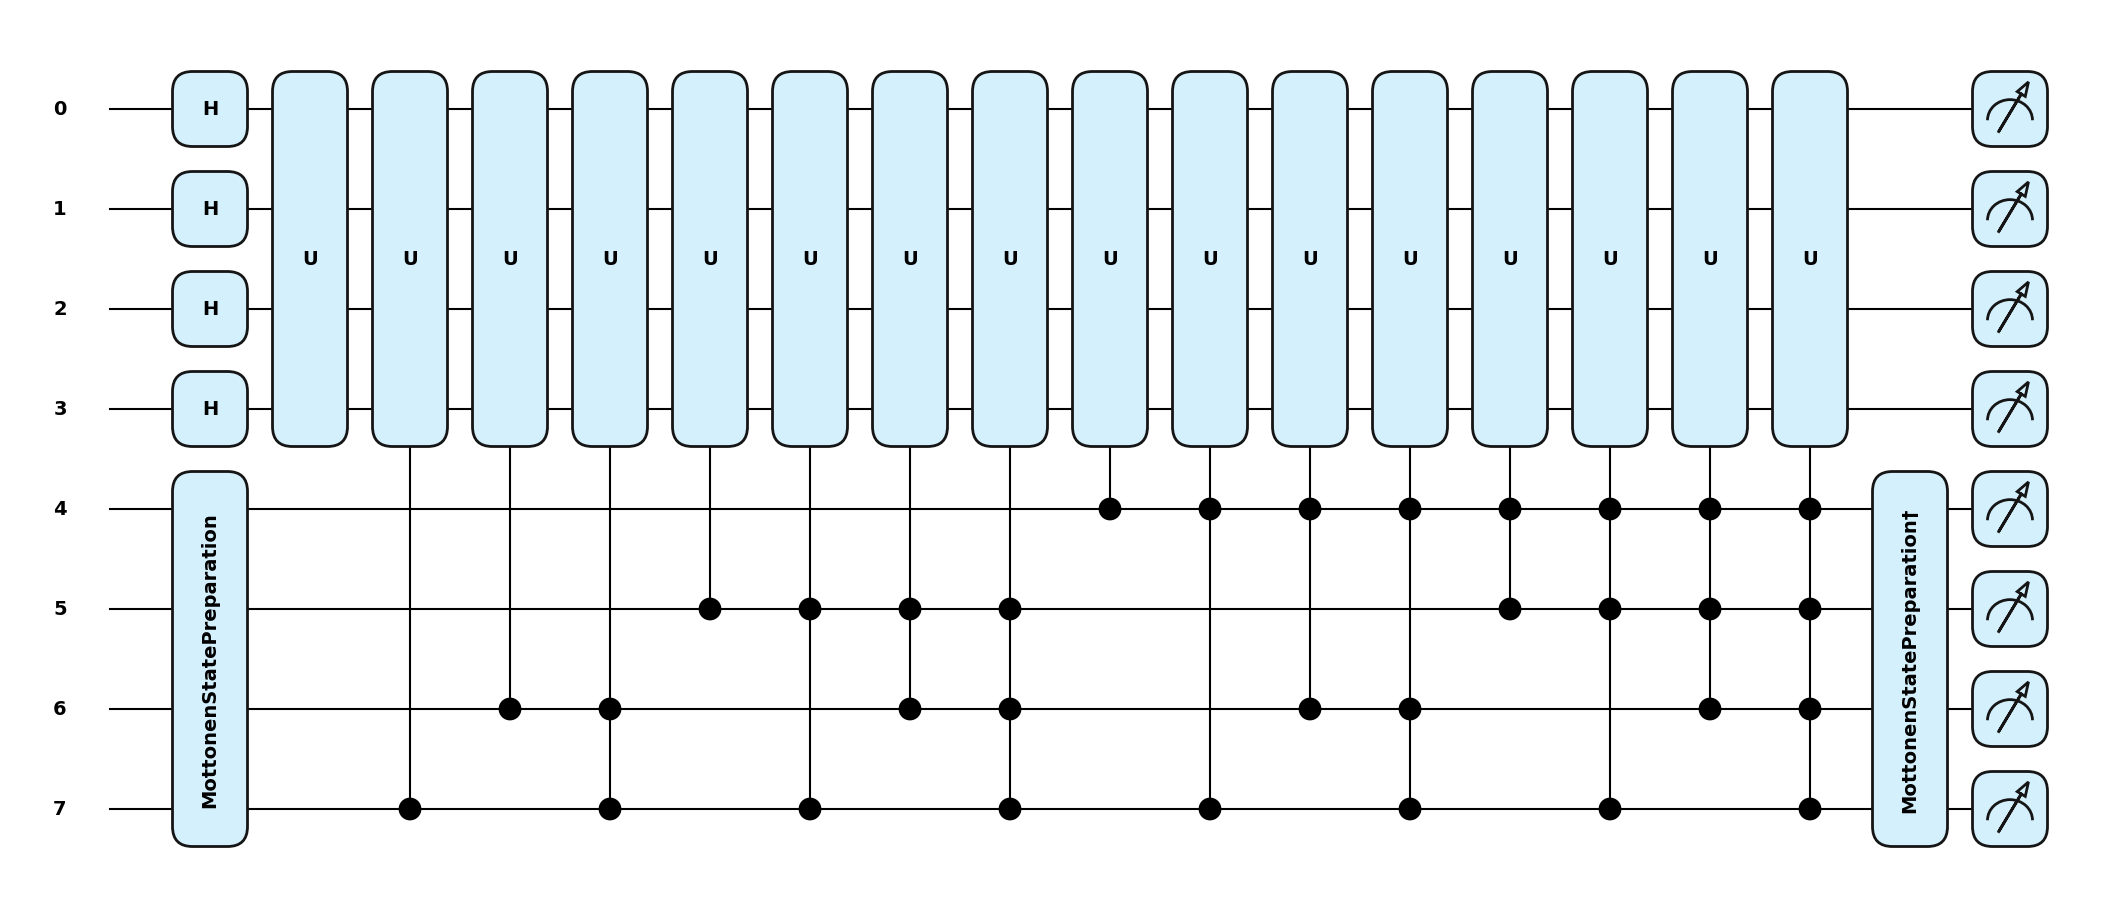

In [122]:
circuit_diagram = qml.draw_mpl(circuit, style='pennylane')
print(circuit_diagram())

(<Figure size 2100x900 with 1 Axes>, <Axes: >)


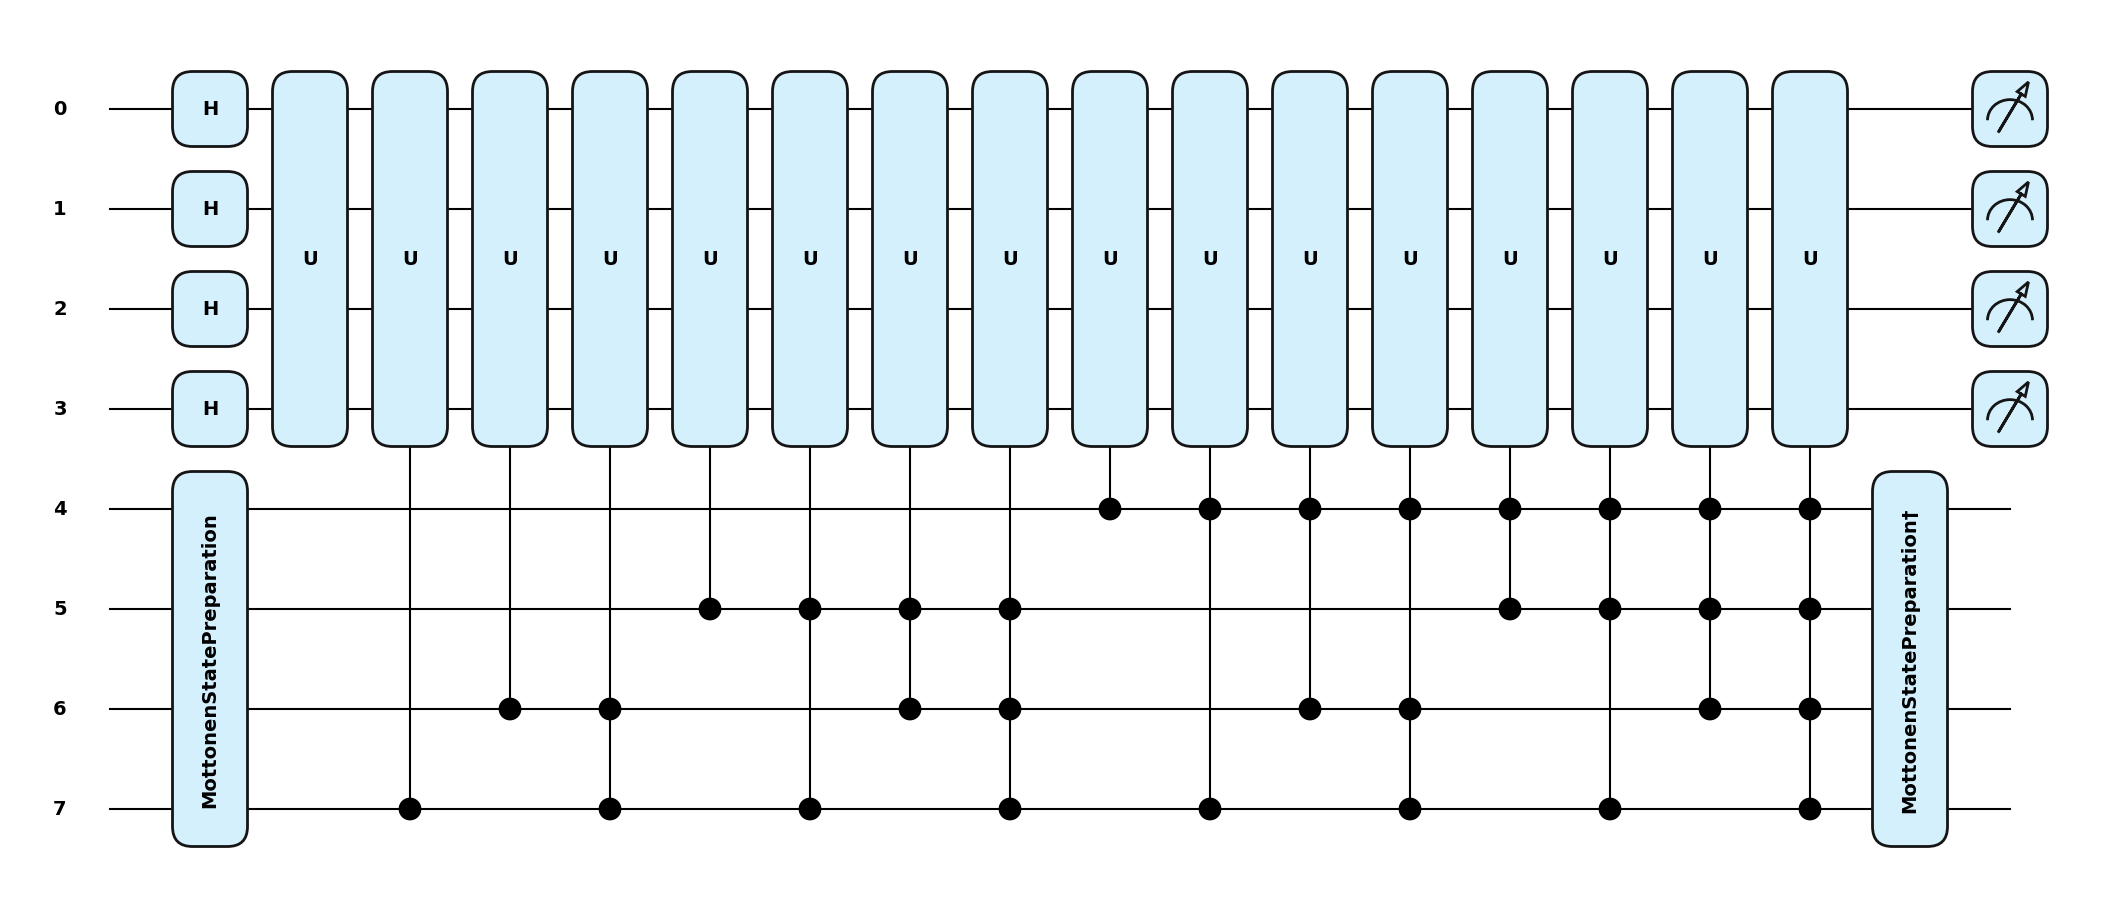

In [123]:
@qml.qnode(dev)
def circuit():
    # Trial state: Hadamard on all system qubits
    for i in range(n):
        qml.Hadamard(i)

    # PREP: Mottonen state on ancilla
    qml.MottonenStatePreparation(weights, wires=range(n, n + n_anc))

    # SELECT: controlled unitaries (identity for padded ones)
    U_list = [expm(2j * (k - m) * H_mat) for k in range(len(alpha_k))]  # real unitaries
    for _ in range(pad_len - len(U_list)):
        U_list.append(np.eye(2**n))  # padded identity

    for idx, U in enumerate(U_list):
        bin_str = format(idx, f"0{n_anc}b")
        ctrl_wires = [n + i for i, b in enumerate(bin_str) if b == '1']
        qml.ControlledQubitUnitary(U, control_wires=ctrl_wires, wires=range(n))

    # PREP†
    qml.adjoint(qml.MottonenStatePreparation)(weights, wires=range(n, n + n_anc))

    return qml.probs(wires=range(4))

circuit_diagram = qml.draw_mpl(circuit, style='pennylane')
print(circuit_diagram())


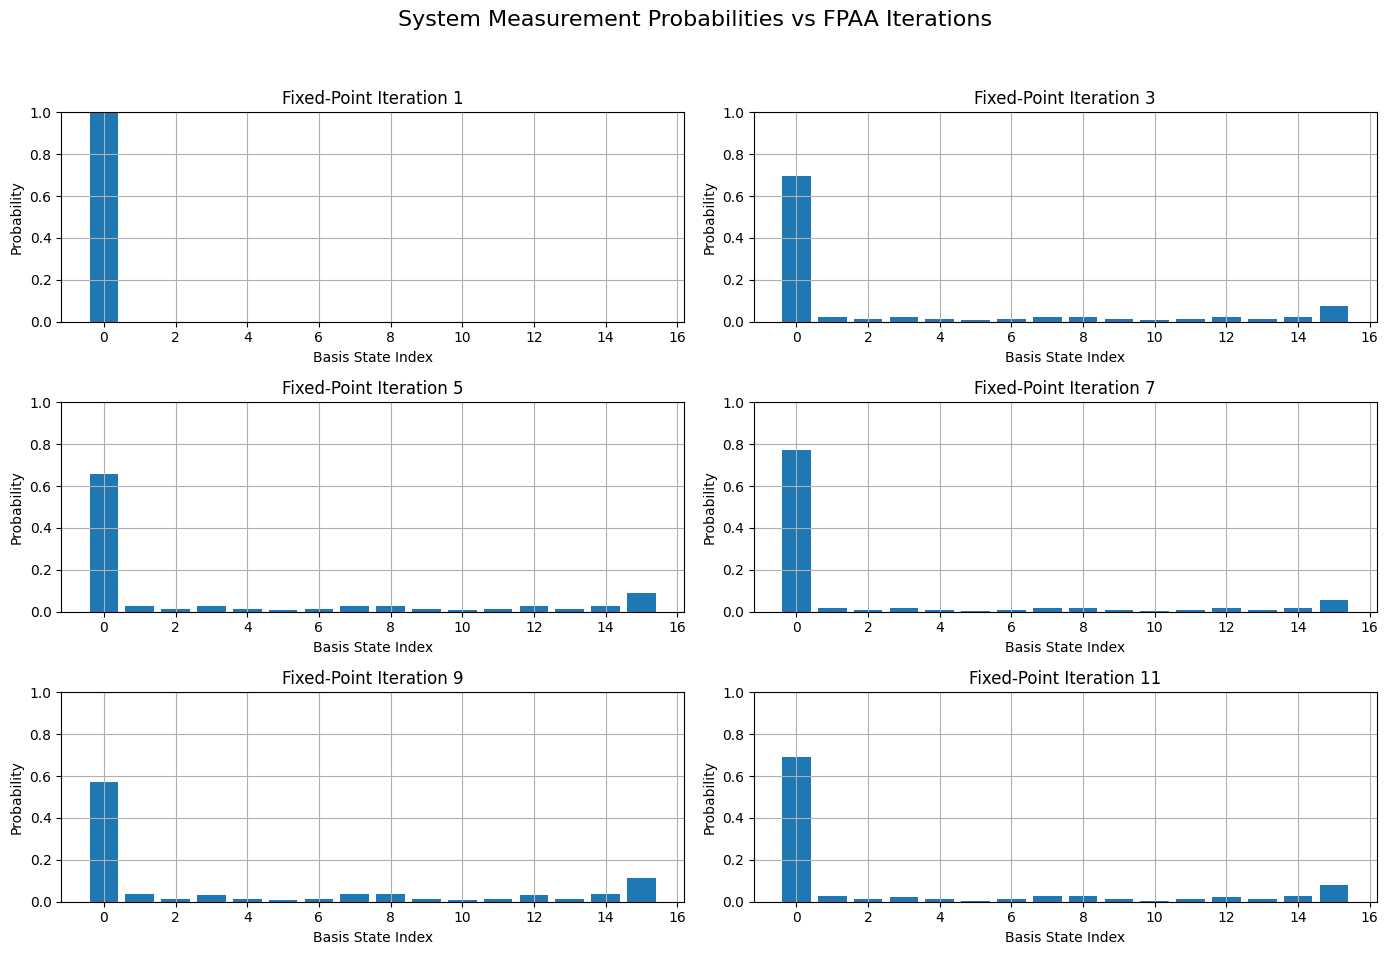

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(14, 10))

for idx, i in enumerate(range(1, 13, 2)):
    circuit = create_lcu_amplitude_amplification_circuit(m=6, n=4, num_layers=i, fixed_point=True)
    output = circuit()

    ax = axs[idx // 2, idx % 2]
    ax.bar(range(len(output)), output)
    ax.set_ylim(0, 1)
    ax.set_title(f"Fixed-Point Iteration {i}")
    ax.set_xlabel("Basis State Index")
    ax.set_ylabel("Probability")
    ax.grid(True)

plt.suptitle("System Measurement Probabilities vs FPAA Iterations", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [14]:
import math
import pennylane as qml
from pennylane import numpy as np
from scipy.linalg import expm

n = 4  # system qubits
m = 2  # for cos^{2m}(H)
k_vals = np.arange(-m, m + 1)
alpha_k = 2**(-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals])
k_vals = [k for k in range(-m, m + 1) if alpha_k[k + m] > 1e-4]
# Step 1: Build and normalize Hamiltonian
coeffs, ops = [], []
for i in range(n - 1):
    coeffs.append(-1.0)
    ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
for i in range(n):
    coeffs.append(-1.0)
    ops.append(qml.PauliX(i))
H_tfim = qml.Hamiltonian(coeffs, ops)
H_mat_raw = qml.matrix(H_tfim)
eigvals = np.linalg.eigvalsh(H_mat_raw)
λ_min, λ_max = np.min(eigvals), np.max(eigvals)
H_mat = (H_mat_raw - λ_min * np.eye(2**n)) / (λ_max - λ_min)  # Normalize to [0,1]
H_eigs, H_vecs = np.linalg.eigh(H_mat)
λ0 = np.min(H_eigs)
H_mat -= λ0 * np.eye(2**n)  # shift ground energy to 0
H_eigs, H_vecs = np.linalg.eigh(H_mat)
# Step 2: pad alpha_k to next power of 2
pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))  # 8
alpha_padded = np.zeros(pad_len)
alpha_padded[:len(alpha_k)] = alpha_k
weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
U_list = [expm(2j * (k - m) * H_mat) for k in range(len(alpha_k))]
U_list += [np.eye(2**n)] * (pad_len - len(U_list))
U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
n_anc = int(np.log2(len(alpha_padded)))  # 4 ancilla qubits
dev = qml.device("default.qubit", wires=n + n_anc)

@qml.qnode(dev)
def circuit():
    # Trial state: Hadamard on all system qubits
    for i in range(n):
        qml.Hadamard(i)

    # PREP: Mottonen state on ancilla
    qml.MottonenStatePreparation(weights, wires=range(n, n + n_anc))

    qml.Select(U_ops, control=range(n_anc))

    # PREP†
    qml.adjoint(qml.MottonenStatePreparation)(weights, wires=range(n, n + n_anc))

    return qml.state()

# Run circuit
full_state = circuit()
reshaped = full_state.reshape((2**n, 2**n_anc))
system_state = reshaped[:, 0]  # 第 0 列表示 ancilla = 000


main_state = system_state/ np.linalg.norm(system_state)

# Compare with exact ground state
ground_state = H_vecs[:, 0]
fidelity = np.abs(np.vdot(main_state, ground_state))**2
print("Fidelity with true ground state:", fidelity)
success_prob = np.sum(np.abs(system_state**2))
print("Success probability:", success_prob)


NameError: name 'n_anc' is not defined

In [115]:
import numpy as np
from scipy.linalg import expm


# 假设 n, H_mat, alpha_padded, alpha_k, m, pad_len 已定义
weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
U_list = [expm(2j * (k - m) * H_mat) for k in range(len(alpha_k))]
U_list += [np.eye(2**n)] * (pad_len - len(U_list))

# 构造加权和
A = sum(w * U for w, U in zip(alpha_padded, U_list))

# 检查酉性
I = np.eye(2**n)
unitarity_error = np.linalg.norm(A.conj().T @ A - I)
print("||A†A - I|| =", unitarity_error)


||A†A - I|| = 2.6733054259076976


In [116]:
A = np.array([[0, 1],
              [-1, 0]])
I = np.eye(2)
np.linalg.norm(A.conj().T @ A - I)

np.float64(0.0)

In [110]:
len(U_list)

8

In [114]:
alpha_padded

tensor([0.0625, 0.25  , 0.375 , 0.25  , 0.0625, 0.    , 0.    , 0.    ], requires_grad=True)

In [117]:
sum(alpha_padded)

tensor(1., requires_grad=True)

In [111]:
len(weights)

8

In [112]:
weights

tensor([0.25      , 0.5       , 0.61237244, 0.5       , 0.25      ,
        0.        , 0.        , 0.        ], requires_grad=True)

In [113]:
sum(weights)

tensor(2.11237244, requires_grad=True)

In [3]:
n = 4
dim = 2 ** n

def get_ground_state(H):
    eigvals, eigvecs = np.linalg.eigh(H)
    return eigvecs[:, np.argmin(eigvals)]

def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H



# 归一化并 shift
H = tfim_model(n)
H_shifted = shift_and_normalize_H(H)
ground_state = get_ground_state(H_shifted)
init_state = np.ones(dim) / np.sqrt(dim)


def cosine_filter_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    #print('Weights:', weights)
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    #print('U_ops:', U_ops)
    print('nanc', n_anc)
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        for i in system_wires:
            qml.Hadamard(i)
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    # be_state = system_state
    #
    # success_prob = np.sum(np.abs(be_state) ** 2)
    # be_state /= np.linalg.norm(be_state)
    # fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return system_state

def cosine_filter_matrix(H, m):
    U = expm(1j * H)
    U_dag = expm(-1j * H)
    cosH = 0.5 * (U + U_dag)
    return np.linalg.matrix_power(cosH, 2*m)

def plus_state(n):
    plus = np.array([[1], [1]]) / np.sqrt(2)
    state = plus
    for _ in range(n - 1):
        state = np.kron(state, plus)
    return state

psi = plus_state(4)  # |++++>


m = 6
system_state = cosine_filter_block_encoding(m)
reference_state = cosine_filter_matrix(H_shifted, m).dot(psi)
# print('[system state]', system_state)
# print('[reference state]', reference_state)
print('Ground state', ground_state)

nanc 4
Ground state [0.57664074+0.j 0.1767767 +0.j 0.1767767 +0.j 0.13529903+0.j
 0.1767767 +0.j 0.07664074+0.j 0.13529903+0.j 0.1767767 +0.j
 0.1767767 +0.j 0.13529903+0.j 0.07664074+0.j 0.1767767 +0.j
 0.13529903+0.j 0.1767767 +0.j 0.1767767 +0.j 0.57664074+0.j]


In [4]:
import numpy as np

# 假设 system_state, reference_state 已定义
# （reference_state 是 16x1）
print('Amplitude system state', np.linalg.norm(system_state))
print('Amplitude reference state', np.linalg.norm(reference_state))

# 1️⃣ 统一形状
system_state = np.array(system_state).flatten()
reference_state = np.array(reference_state).flatten()

# 2️⃣ 归一化（确保长度为 1）
system_state /= np.linalg.norm(system_state)
reference_state /= np.linalg.norm(reference_state)

# 3️⃣ Fidelity（保真度）
fidelity = np.abs(np.vdot(system_state, reference_state))**2

# 4️⃣ L2范数差异
diff_norm = np.linalg.norm(system_state - reference_state)

print("Fidelity =", fidelity)
print("‖Δ‖₂ =", diff_norm)

print('system state fidelity with ground state', np.abs(np.vdot(system_state, ground_state))**2)
print('reference state fidelity with ground state', np.abs(np.vdot(reference_state, ground_state))**2)

Amplitude system state 0.8284456295192868
Amplitude reference state 0.8284456295192869
Fidelity = 0.9999999999999996
‖Δ‖₂ = 8.112894004521462e-16
system state fidelity with ground state 0.9689751061381856
reference state fidelity with ground state 0.968975106138186


In [55]:
n = 4
dim = 2 ** n

def get_ground_state(H):
    eigvals, eigvecs = np.linalg.eigh(H)
    return eigvecs[:, np.argmin(eigvals)]

def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H



# 归一化并 shift
H = -tfim_model(n)
H_shifted = shift_and_normalize_H(H)
ground_state = get_ground_state(H_shifted)
init_state = np.ones(dim) / np.sqrt(dim)

def temp(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    #print('Weights:', weights)
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    system_state = block_encoding()
    return system_state, n_anc

# Step 5: Apply Grover operator Q = -RS RΠ
results = {}
psi0, n_anc = temp(m=1)
n_total = 6
n = 4
RS = 2 * np.outer(psi0, psi0.conj()) - np.eye(2 ** n_total)
Π = np.zeros((2 ** n_total,))
Π[:2 ** n] = 1.0
RΠ = np.eye(2 ** n_total) - 2 * np.diag(Π)
Q = -RS @ RΠ
r_list=[0, 1, 2, 3, 4]
for r in r_list:
    psi = psi0.copy()
    for _ in range(r):
        psi = Q @ psi
    # reshaped = psi.reshape((2 ** n_anc, 2 ** n_anc))
    # system_unnorm = reshaped[:, 0]
    reshaped = psi.reshape((2 ** n_anc, 2 ** n))
    system_unnorm = reshaped[0, :]  # ancilla = 000...0
    success_prob = np.sum(np.abs(system_unnorm) ** 2)
    #success_prob = np.real(np.vdot(system_unnorm, system_unnorm))
    system_state = system_unnorm / np.linalg.norm(system_unnorm)
    fidelities = np.abs(ground_state.conj().T @ system_state) ** 2
    results[r] = {
            'fidelities': fidelities,
            'success_prob': success_prob
        }

print(results)


{0: {'fidelities': np.float64(0.1209370292745278), 'success_prob': np.float64(0.048569104515363795)}, 1: {'fidelities': np.float64(0.12093702927452778), 'success_prob': np.float64(0.3823401102912013)}, 2: {'fidelities': np.float64(0.1209370292745278), 'success_prob': np.float64(0.8031044081088239)}, 3: {'fidelities': np.float64(0.12093702927452778), 'success_prob': np.float64(0.999764719776)}, 4: {'fidelities': np.float64(0.12093702927452774), 'success_prob': np.float64(0.8269178159659574)}}


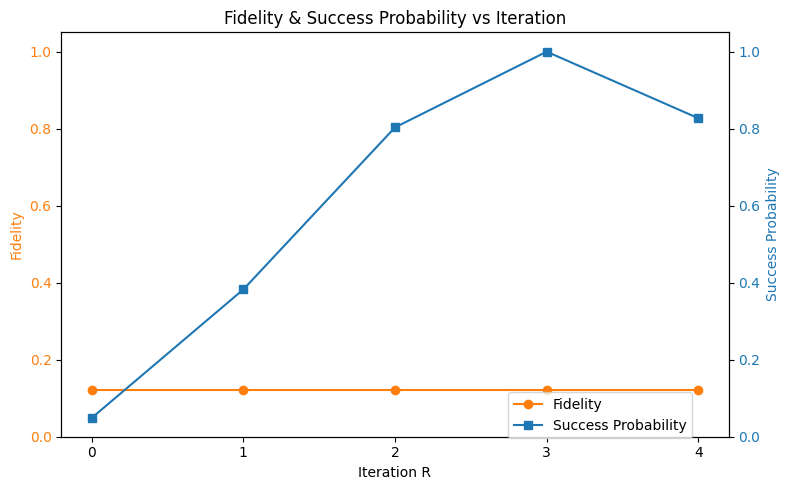

In [56]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np

# 假设 results 已经定义好
# results = {...}

# 提取键（迭代次数）
R_list = sorted(results.keys())

# 提取 fidelity 和 success probability
fidelities = [results[R]['fidelities'] for R in R_list]
success_probs = [results[R]['success_prob'] for R in R_list]

# === 绘图 ===
fig, ax1 = plt.subplots(figsize=(8, 5))

# 左轴：Fidelity
ax1.plot(R_list, fidelities, marker='o', color='tab:orange', label='Fidelity')
ax1.set_xlabel("Iteration R")
ax1.set_ylabel("Fidelity", color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')
ax1.set_ylim(0, 1.05)
ax1.xaxis.set_major_locator(MultipleLocator(1))
# 右轴：Success Probability
ax2 = ax1.twinx()
ax2.plot(R_list, success_probs, marker='s', color='tab:blue', label='Success Probability')
ax2.set_ylabel("Success Probability", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_ylim(0, 1.05)

# 图例
fig.legend(loc='lower right', bbox_to_anchor=(0.88, 0.1))
plt.title("Fidelity & Success Probability vs Iteration")
plt.tight_layout()
plt.show()


(<Figure size 400x300 with 1 Axes>, <Axes: >)

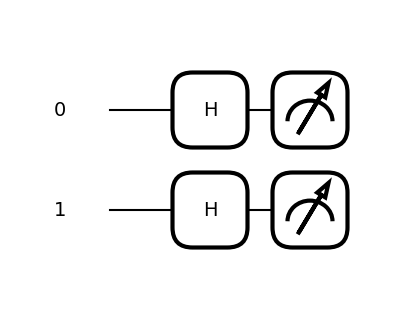

In [11]:
nqubits = 2
dev = qml.device('default.qubit', wires=nqubits)
@qml.qnode(dev)
@qml.qnode(dev)
def circuit(nqubits):
    for i in range(nqubits):
        qml.H(i)
    return qml.state()

qml.draw_mpl(circuit)(nqubits)


output [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]


D:\research\vqe_U\.venv\Lib\site-packages\matplotlib\transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


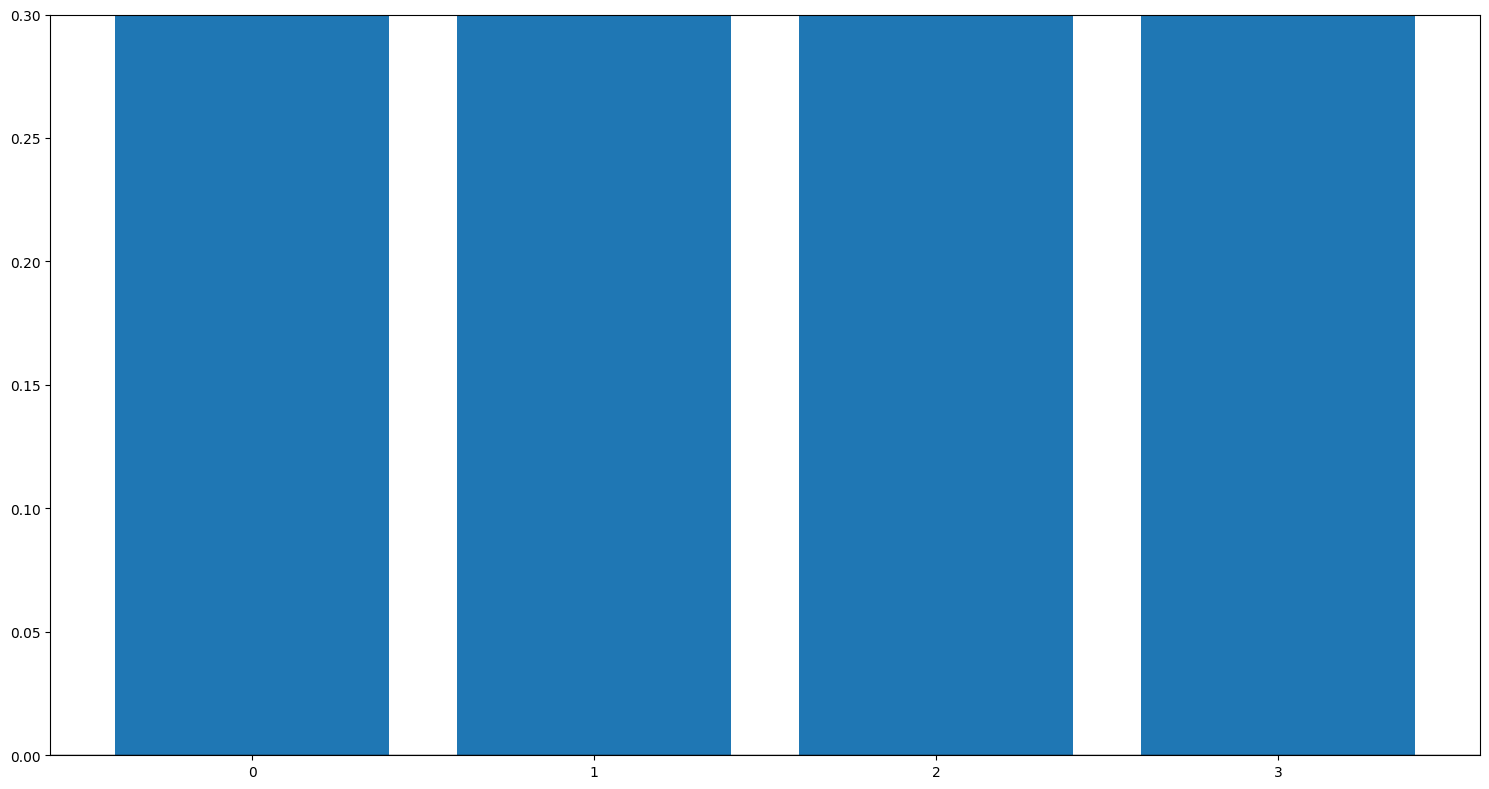

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(15, 8))


output = circuit(nqubits)
print('output', output)
ax = axs
ax.bar(range(len(output)), output)
ax.set_xticks(range(len(output)))
ax.set_xticklabels(range(len(output)))
ax.set_ylim(0, 0.3)
ax.axhline(0, color='black', linewidth=1)

plt.tight_layout()
plt.show()

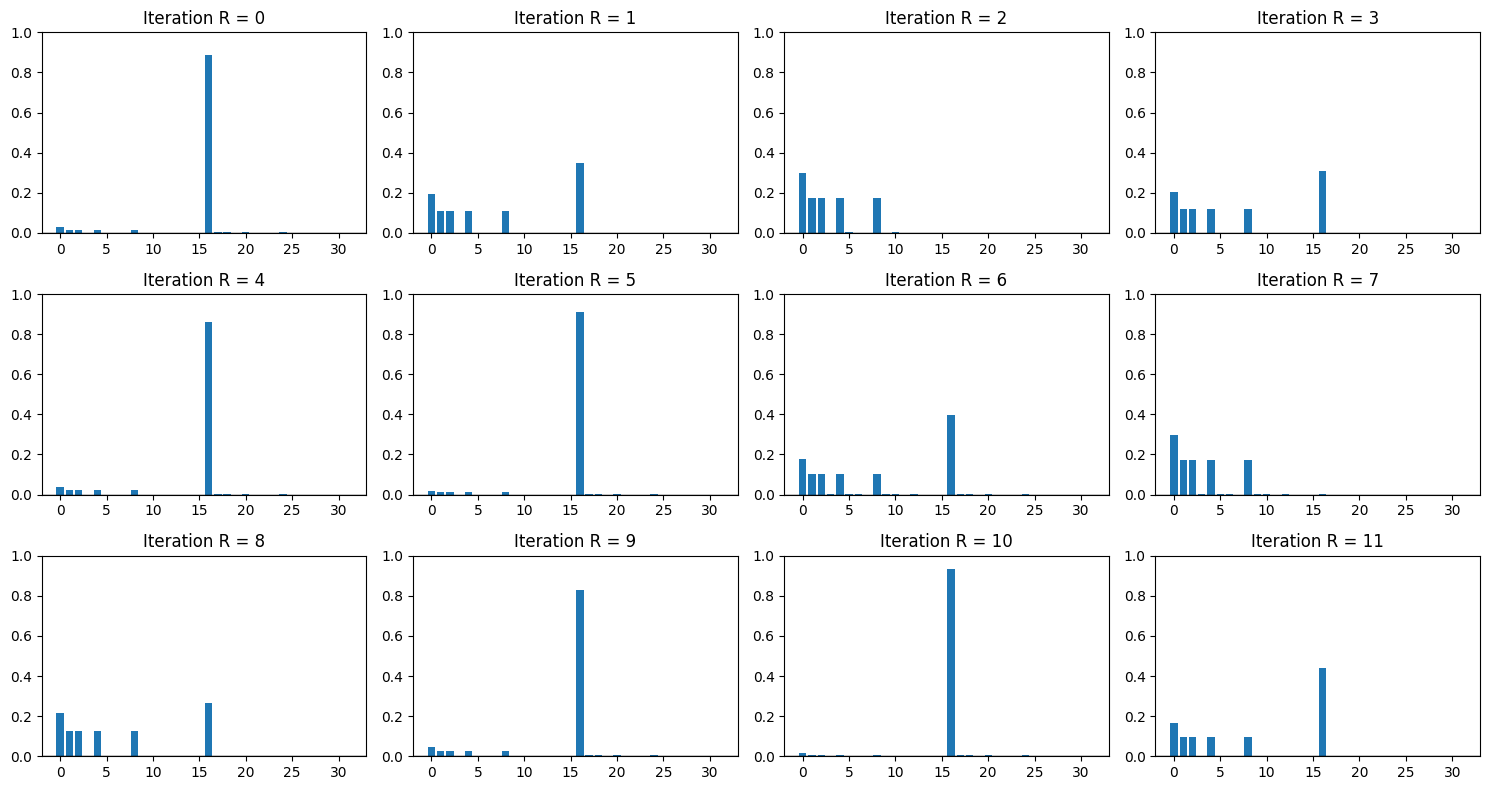

In [4]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from pennylane_qiskit import load_pauli_op
from qiskit.quantum_info import Operator, SparsePauliOp

import numpy as np
import pennylane as qml
from scipy.linalg import expm
import math
import matplotlib.pyplot as plt

def get_hamiltonian_pl(nq, J):
    coeffs = []
    ops = []
    for i in range(nq - 1):
        coeffs.append(J)
        ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
    coeffs.append(J)
    ops.append(qml.PauliZ(nq - 1) @ qml.PauliZ(0))
    for i in range(nq):
        coeffs.append(J)
        ops.append(qml.PauliX(i))
    return qml.Hamiltonian(coeffs, ops)

def tfim_model(n):
    Z = np.array([[1,0],[0,-1]]); X = np.array([[0,1],[1,0]]); I = np.eye(2)
    H = np.zeros((2**n, 2**n), dtype=np.complex128)
    for i in range(n):
        Zi = [I]*n; Zi[i]=Z; Zi[(i+1)%n]=Z; H -= kron_n(Zi)
        Xi = [I]*n; Xi[i]=X; H -= kron_n(Xi)
    return H

def shift_and_normalize_H(H):
    vals = np.linalg.eigvalsh(H)
    lmin, lmax = vals.min(), vals.max()
    Hn = (H - lmin*np.eye(len(H))) / (lmax - lmin) * (np.pi/2)
    l0 = np.min(np.linalg.eigvalsh(Hn))
    return Hn - l0*np.eye(len(Hn))

def get_ground_state(H):
    vals, vecs = np.linalg.eigh(H)
    return vecs[:, np.argmin(vals)]

def select_dev(error_rate, nqubits):
    # If need noise, we can add qml.DepolarizingChannel etc.
    if error_rate == 0:
        return qml.device("default.qubit", wires=nqubits + 1)
    else:
        # simple noise model
        return qml.device("default.mixed", wires=nqubits + 1)

error_rate = 0
nqubits = 4
state = np.zeros(2**nqubits)
state[0] = 1
time = np.pi/2
dev = select_dev(error_rate, nqubits)
@qml.prod
def cosine_step(nqubits, H_cos, time):
    # for i in range(1, 1+nqubits):
    #     qml.Hadamard(wires=i)
    #qml.StatePrep(state, wires=range(1, nqubits + 1))
    qml.TrotterProduct(H_cos, -time, n=10, order=2)
    #return qml.state()


@qml.prod
def Oracle_op(anc_wires):
    qml.FlipSign(n=0, wires=anc_wires)


def run_cosine_AA(nqubits=4, R=1):

    #state = 1 / np.sqrt(2 ** 4) * np.ones(2 ** 4)
    H = get_hamiltonian_pl(4, 1)
    H_array = qml.matrix(H)
    vals, vecs = np.linalg.eigh(H_array)
    gs = vecs[:, np.argmin(vals)]
    emin = vals[0]
    emax = vals[-1]
    H_array = (H_array - emin * np.eye(2 ** nqubits)) / (emax - emin)
    H = SparsePauliOp.from_operator(Operator(H_array))
    H_cos = load_pauli_op(H^SparsePauliOp(["Y"]))


    n = 4
    n_anc = 1
    anc = list(range(n_anc))
    sys = list(range(n_anc, n_anc+n))
    all_wires = anc + sys
    #dev = qml.device("default.qubit", wires=len(all_wires)+1, shots=None)
    #dev = select_dev(error_rate, nqubits)
    dev = qml.device("default.qubit")
    @qml.qnode(dev)
    def circuit(iters):
        cosine_step(nqubits, H_cos, time)
        qml.AmplitudeAmplification(
            U = cosine_step(nqubits, H_cos, time),
            #U = prepare_init(n),
            O = Oracle_op(anc),
            iters = iters,
            fixed_point=False,
        )
        #return qml.state()
        return qml.probs(all_wires)

    psi = circuit(R)#[:2**4].real
    # #print('state vector is', psi)
    # psi = psi.reshape((2 ** n_anc, 2 ** n))
    # sys_amp = psi[0, :]
    # # print('System state', sys_amp)
    # success_prob = np.real(np.vdot(sys_amp, sys_amp))
    # # success_prob = np.linalg.norm(sys_amp)
    # normed = sys_amp / np.linalg.norm(sys_amp) if np.linalg.norm(sys_amp) > 0 else sys_amp
    # fid = np.abs(np.vdot(normed, gs)) ** 2
    # return fid, success_prob
    return psi

R_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]       # 指定要跑的迭代次数
fig, axs = plt.subplots(3, 4, figsize=(15, 8))
axs = axs.flatten()               # 把 2×3 的 axes 摊平方便索引

for i, R in enumerate(R_list):
    output = run_cosine_AA(4, R=R)
    ax = axs[i]
    ax.bar(range(len(output)), output)
    ax.set_ylim(0, 1)
    ax.set_title(f"Iteration R = {R}")
    ax.axhline(0, color='black', linewidth=1)
    # for i, R in enumerate(R_list):
    #     success_prob, fidelity, psi = run_AA_LCU(n=4, m=1, R=R)
    #     probs = np.abs(psi) ** 2
    #
    #     ax = axs[i]
    #     ax.bar(range(len(probs)), probs)
    #     ax.set_ylim(0, 0.3)
    #     ax.set_title(f"R={R}\nSuccess={success_prob:.3f}\nFidelity={fidelity:.3f}")

plt.tight_layout()
plt.show()

D:\research\vqe_U\.venv\Lib\site-packages\pennylane\templates\subroutines\amplitude_amplification.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  gamma = np.cos(np.arccos(1 / delta, dtype=np.complex128) / iters, dtype=np.complex128) ** -1
D:\research\vqe_U\.venv\Lib\site-packages\pennylane\templates\subroutines\amplitude_amplification.py:47: RuntimeWarning: invalid value encountered in scalar divide
  gamma = np.cos(np.arccos(1 / delta, dtype=np.complex128) / iters, dtype=np.complex128) ** -1
D:\research\vqe_U\.venv\Lib\site-packages\pennylane\templates\subroutines\amplitude_amplification.py:47: RuntimeWarning: invalid value encountered in scalar power
  gamma = np.cos(np.arccos(1 / delta, dtype=np.complex128) / iters, dtype=np.complex128) ** -1


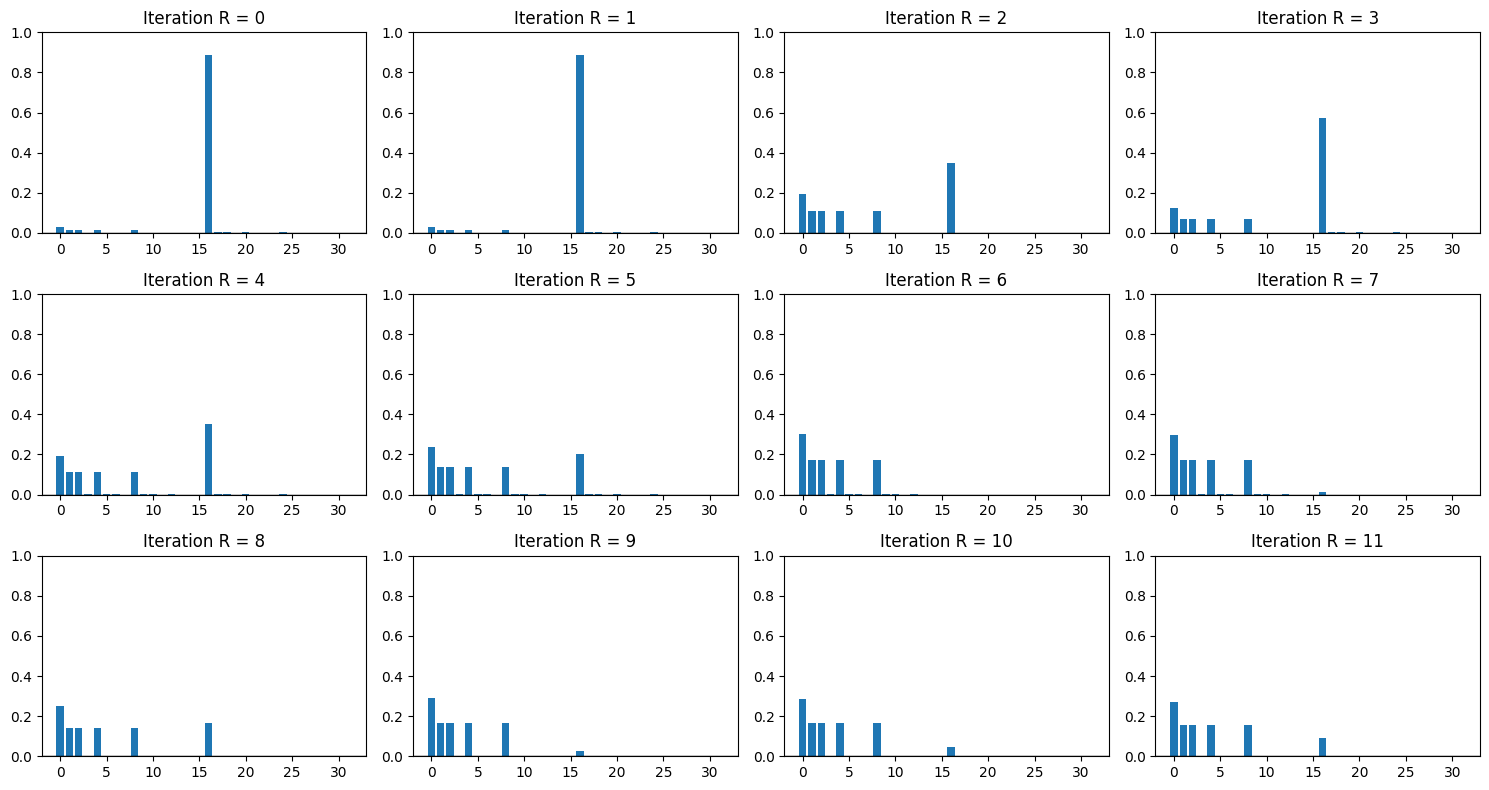

In [5]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from pennylane_qiskit import load_pauli_op
from qiskit.quantum_info import Operator, SparsePauliOp

import numpy as np
import pennylane as qml
from scipy.linalg import expm
import math
import matplotlib.pyplot as plt

def get_hamiltonian_pl(nq, J):
    coeffs = []
    ops = []
    for i in range(nq - 1):
        coeffs.append(J)
        ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
    coeffs.append(J)
    ops.append(qml.PauliZ(nq - 1) @ qml.PauliZ(0))
    for i in range(nq):
        coeffs.append(J)
        ops.append(qml.PauliX(i))
    return qml.Hamiltonian(coeffs, ops)

def tfim_model(n):
    Z = np.array([[1,0],[0,-1]]); X = np.array([[0,1],[1,0]]); I = np.eye(2)
    H = np.zeros((2**n, 2**n), dtype=np.complex128)
    for i in range(n):
        Zi = [I]*n; Zi[i]=Z; Zi[(i+1)%n]=Z; H -= kron_n(Zi)
        Xi = [I]*n; Xi[i]=X; H -= kron_n(Xi)
    return H

def shift_and_normalize_H(H):
    vals = np.linalg.eigvalsh(H)
    lmin, lmax = vals.min(), vals.max()
    Hn = (H - lmin*np.eye(len(H))) / (lmax - lmin) * (np.pi/2)
    l0 = np.min(np.linalg.eigvalsh(Hn))
    return Hn - l0*np.eye(len(Hn))

def get_ground_state(H):
    vals, vecs = np.linalg.eigh(H)
    return vecs[:, np.argmin(vals)]

def select_dev(error_rate, nqubits):
    # If need noise, we can add qml.DepolarizingChannel etc.
    if error_rate == 0:
        return qml.device("default.qubit", wires=nqubits + 1)
    else:
        # simple noise model
        return qml.device("default.mixed", wires=nqubits + 1)

error_rate = 0
nqubits = 4
state = np.zeros(2**nqubits)
state[0] = 1
time = np.pi/2
dev = select_dev(error_rate, nqubits)
@qml.prod
def cosine_step(nqubits, H_cos, time):
    # for i in range(1, 1+nqubits):
    #     qml.Hadamard(wires=i)
    #qml.StatePrep(state, wires=range(1, nqubits + 1))
    qml.TrotterProduct(H_cos, -time, n=10, order=2)
    #return qml.state()


@qml.prod
def Oracle_op(anc_wires):
    qml.FlipSign(n=0, wires=anc_wires)


def run_cosine_AA(nqubits=4, R=1):

    #state = 1 / np.sqrt(2 ** 4) * np.ones(2 ** 4)
    H = get_hamiltonian_pl(4, 1)
    H_array = qml.matrix(H)
    vals, vecs = np.linalg.eigh(H_array)
    gs = vecs[:, np.argmin(vals)]
    emin = vals[0]
    emax = vals[-1]
    H_array = (H_array - emin * np.eye(2 ** nqubits)) / (emax - emin)
    H = SparsePauliOp.from_operator(Operator(H_array))
    H_cos = load_pauli_op(H^SparsePauliOp(["Y"]))


    n = 4
    n_anc = 1
    anc = list(range(n_anc))
    sys = list(range(n_anc, n_anc+n))
    all_wires = anc + sys
    #dev = qml.device("default.qubit", wires=len(all_wires)+1, shots=None)
    #dev = select_dev(error_rate, nqubits)
    dev = qml.device("default.qubit")
    @qml.qnode(dev)
    def circuit(iters):
        cosine_step(nqubits, H_cos, time)
        qml.AmplitudeAmplification(
            U = cosine_step(nqubits, H_cos, time),
            #U = prepare_init(n),
            O = Oracle_op(anc),
            iters = iters,
            fixed_point=True,
            work_wire = n+n_anc
        )
        #return qml.state()
        return qml.probs(all_wires)

    psi = circuit(R)#[:2**4].real
    # #print('state vector is', psi)
    # psi = psi.reshape((2 ** n_anc, 2 ** n))
    # sys_amp = psi[0, :]
    # # print('System state', sys_amp)
    # success_prob = np.real(np.vdot(sys_amp, sys_amp))
    # # success_prob = np.linalg.norm(sys_amp)
    # normed = sys_amp / np.linalg.norm(sys_amp) if np.linalg.norm(sys_amp) > 0 else sys_amp
    # fid = np.abs(np.vdot(normed, gs)) ** 2
    # return fid, success_prob
    return psi

R_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]      # 指定要跑的迭代次数
fig, axs = plt.subplots(3, 4, figsize=(15, 8))
axs = axs.flatten()               # 把 2×3 的 axes 摊平方便索引

for i, R in enumerate(R_list):
    output = run_cosine_AA(4, R=R)
    ax = axs[i]
    ax.bar(range(len(output)), output)
    ax.set_ylim(0, 1)
    ax.set_title(f"Iteration R = {R}")
    ax.axhline(0, color='black', linewidth=1)
    # for i, R in enumerate(R_list):
    #     success_prob, fidelity, psi = run_AA_LCU(n=4, m=1, R=R)
    #     probs = np.abs(psi) ** 2
    #
    #     ax = axs[i]
    #     ax.bar(range(len(probs)), probs)
    #     ax.set_ylim(0, 0.3)
    #     ax.set_title(f"R={R}\nSuccess={success_prob:.3f}\nFidelity={fidelity:.3f}")

plt.tight_layout()
plt.show()

### LCU example

In [125]:
import numpy as np
import pennylane as qml

a = 0.25
b = 0.75

# matrix to be decomposed
A = np.array(
    [[a,  0, 0,  b],
     [0, -a, b,  0],
     [0,  b, a,  0],
     [b,  0, 0, -a]]
)

LCU = qml.pauli_decompose(A)
LCU_coeffs, LCU_ops = LCU.terms()

print(f"LCU decomposition:\n {LCU}")
print(f"Coefficients:\n {LCU_coeffs}")
print(f"Unitaries:\n {LCU_ops}")


dev2 = qml.device("default.qubit", wires=3)
alphas = (np.sqrt(LCU_coeffs) / np.linalg.norm(np.sqrt(LCU_coeffs)))
# unitaries
ops = LCU_ops
# relabeling wires: 0 → 1, and 1 → 2
unitaries = [qml.map_wires(op, {0: 1, 1: 2}) for op in ops]


@qml.qnode(dev2)
def lcu_circuit():  # block_encode
    # PREP
    qml.StatePrep(alphas, wires=0)

    # SEL
    qml.Select(unitaries, control=0)

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires=0))
    return qml.state()


output_matrix = qml.matrix(lcu_circuit)()
print("A:\n", A, "\n")
print("Block-encoded A:\n")
print(np.real(np.round(output_matrix,2)))

LCU decomposition:
 0.25 * (I(0) @ Z(1)) + 0.75 * (X(0) @ X(1))
Coefficients:
 [0.25 0.75]
Unitaries:
 [I(0) @ Z(1), X(0) @ X(1)]
A:
 [[ 0.25  0.    0.    0.75]
 [ 0.   -0.25  0.75  0.  ]
 [ 0.    0.75  0.25  0.  ]
 [ 0.75  0.    0.   -0.25]] 

Block-encoded A:

[[ 0.25  0.    0.    0.75 -0.43  0.    0.    0.43]
 [ 0.   -0.25  0.75  0.    0.    0.43  0.43  0.  ]
 [ 0.    0.75  0.25  0.    0.    0.43 -0.43  0.  ]
 [ 0.75  0.    0.   -0.25  0.43  0.    0.    0.43]
 [-0.43  0.    0.    0.43  0.75  0.    0.    0.25]
 [ 0.    0.43  0.43  0.    0.   -0.75  0.25  0.  ]
 [ 0.    0.43 -0.43  0.    0.    0.25  0.75  0.  ]
 [ 0.43  0.    0.    0.43  0.25  0.    0.   -0.75]]


In [10]:
LCU_ops

[I(0) @ Z(1), X(0) @ X(1)]

In [11]:
LCU_coeffs

array([0.25, 0.75])

In [3]:
test_states = [
    np.array([1, 0, 0, 0]),  # |00>
    np.array([0, 1, 0, 0]),  # |01>
    np.array([0, 0, 1, 0]),  # |10>
    np.array([0, 0, 0, 1]),  # |11>
    (1/2)*np.array([1, 1, 1, 1]),  # |++>
]

def build_full_input(psi):
    psi = psi / np.linalg.norm(psi)
    full_state = np.kron([1, 0], psi)  # ancilla |0> tensor system
    return full_state

# Get the block-encoded matrix (from your circuit)
U_lcu = qml.matrix(lcu_circuit, wire_order=[0, 1, 2])()

for psi in test_states:
    full_input = build_full_input(psi)

    # Apply LCU operator
    out = U_lcu @ full_input

    # Project ancilla onto |0>
    projected = out[:4]  # only ancilla=0 sector

    # Normalize (optional if comparing direction)
    projected /= np.linalg.norm(projected)

    # Apply original matrix A directly
    direct = A @ psi
    direct /= np.linalg.norm(direct)

    # Compare fidelity or overlap
    fidelity = np.abs(np.vdot(projected, direct))**2
    print("Fidelity:", fidelity)


Fidelity: 0.9999999999999998
Fidelity: 0.9999999999999998
Fidelity: 0.9999999999999998
Fidelity: 0.9999999999999998
Fidelity: 1.0


In [133]:
@qml.qnode(dev2)
def lcu_circuit():  # block_encode
    # PREP
    for i in range(2):
        qml.Hadamard(i+1)

    qml.StatePrep(alphas, wires=0)

    # SEL
    qml.Select(unitaries, control=0)

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires=0))
    return qml.state()
full_state = lcu_circuit()
reshaped = full_state.reshape((2, 2 ** 2))
system_state = reshaped[0, :]

reference_state = A.dot(1/2*np.array([[1], [1], [1], [1]]))

print('[System state]', system_state)
print('[Reference state]', reference_state)

[System state] [0.5 +0.j 0.25+0.j 0.5 +0.j 0.25+0.j]
[Reference state] [[0.5 ]
 [0.25]
 [0.5 ]
 [0.25]]


In [132]:
A.shape

(4, 4)

In [5]:
import numpy as np
import pennylane as qml

# A = 1/4 (ZZ + ZX + XZ + XX)
coeffs = np.array([1/4, 1/4, 1/4, 1/4])
ops = [
    qml.PauliZ(0) @ qml.PauliZ(1),
    qml.PauliZ(0) @ qml.PauliX(1),
    qml.PauliX(0) @ qml.PauliZ(1),
    qml.PauliX(0) @ qml.PauliX(1),
]

# Normalize alpha vector for 2 ancilla qubits (4-dimensional Hilbert space)
alphas = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))  # shape (4,)
print('[s] is', np.linalg.norm(np.sqrt(coeffs)))
# map Pauli ops to system wires: 2 and 3 (since 0,1 are ancilla)
unitaries = [qml.map_wires(op, {0: 2, 1: 3}) for op in ops]

# total wires: 2 ancilla + 2 system = 4
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def lcu_circuit():
    qml.StatePrep(alphas, wires=[0, 1])                  # prepare ancilla state (4 elements → 2 qubits)
    qml.Select(unitaries, control=[0, 1])                # controlled select
    qml.adjoint(qml.StatePrep(alphas, wires=[0, 1]))     # uncompute ancilla
    return qml.state()

# Get full 16×16 block-encoded matrix
U = qml.matrix(lcu_circuit, wire_order=[0, 1, 2, 3])()

# Construct original A matrix on system (2 qubits)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
A = (1/4) * (np.kron(Z, Z) + np.kron(Z, X) + np.kron(X, Z) + np.kron(X, X))

# Output
print("Original matrix A:")
print(np.round(A, 2))

print("\nBlock-encoded matrix U (upper-left 4×4 block is A):")
print(np.round(U[:4, :4], 2))  # Extract block with ancilla in |00⟩


[s] is 1.0
Original matrix A:
[[ 0.25  0.25  0.25  0.25]
 [ 0.25 -0.25  0.25 -0.25]
 [ 0.25  0.25 -0.25 -0.25]
 [ 0.25 -0.25 -0.25  0.25]]

Block-encoded matrix U (upper-left 4×4 block is A):
[[ 0.25+0.j  0.25+0.j  0.25+0.j  0.25+0.j]
 [ 0.25+0.j -0.25+0.j  0.25+0.j -0.25+0.j]
 [ 0.25+0.j  0.25+0.j -0.25+0.j -0.25+0.j]
 [ 0.25+0.j -0.25+0.j -0.25+0.j  0.25+0.j]]


In [7]:
import numpy as np
import pennylane as qml

# A = 1/2 (Z + X)
coeffs = np.array([1/2, 1/2])
ops = [
    qml.PauliZ(0) ,
    qml.PauliX(0)
]

# Normalize alpha vector for 2 ancilla qubits (4-dimensional Hilbert space)
alphas = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))  # shape (4,)
print('[s] is', np.linalg.norm(np.sqrt(coeffs)))
# map Pauli ops to system wires: 2 and 3 (since 0,1 are ancilla)
# map Pauli ops to system wires: 1 (since 0 are ancilla)
#unitaries = [qml.map_wires(op, {0: 2, 1: 3}) for op in ops]
unitaries = [qml.map_wires(op, {0: 1}) for op in ops]

# total wires: 2 ancilla + 2 system = 4
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def lcu_circuit():
    qml.StatePrep(alphas, wires=[0])                  # prepare ancilla state (4 elements → 2 qubits)
    qml.Select(unitaries, control=[0])                # controlled select
    qml.adjoint(qml.StatePrep(alphas, wires=[0]))     # uncompute ancilla
    return qml.state()

# Get full 16×16 block-encoded matrix
U = qml.matrix(lcu_circuit, wire_order=[0, 1])()

# Construct original A matrix on system (2 qubits)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
A = (1/2) * (Z+X)

# Output
print("Original matrix A:")
print(np.round(A, 2))

print("\nBlock-encoded matrix U (upper-left 4×4 block is A):")
print(np.round(U[:2, :2], 2))  # Extract block with ancilla in |00⟩


[s] is 1.0
Original matrix A:
[[ 0.5  0.5]
 [ 0.5 -0.5]]

Block-encoded matrix U (upper-left 4×4 block is A):
[[ 0.5+0.j  0.5+0.j]
 [ 0.5+0.j -0.5+0.j]]


(<Figure size 600x500 with 1 Axes>, <Axes: >)


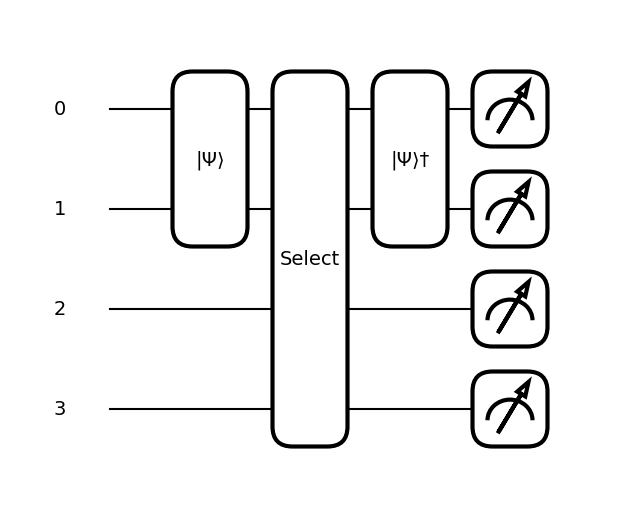

In [5]:
circuit_diagram = qml.draw_mpl(lcu_circuit)
print(circuit_diagram())

In [6]:
import numpy as np
from scipy.linalg import expm
import pennylane as qml

# === 定义 Pauli 运算符矩阵 ===
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

# === 构造 A = 1/4 (ZZ + ZX + XZ + XX) ===
P_terms = [np.kron(Z, Z), np.kron(Z, X), np.kron(X, Z), np.kron(X, X)]
A = sum(P_terms) / 4

# === 准备 LCU 系数和单项酉矩阵 ===
coeffs = np.array([1/4, 1/4, 1/4, 1/4])
weights = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))  # 4 维 → 2 ancilla qubits

# U_list = 4 项酉矩阵（即 A 的每项）
U_list = P_terms

dev = qml.device("default.qubit", wires=4)  # [0,1: ancilla], [2,3: system]

@qml.qnode(dev)
def lcu_ancilla_on_top():
    # 初始化 system 态
    # for w in [2, 3]:
    #     qml.Hadamard(w)

    # Mottonen 制备 √α 到 ancilla
    qml.MottonenStatePreparation(weights, wires=[0, 1])

    # SELECT using controlled unitary
    for idx, U in enumerate(U_list):
        bin_str = format(idx, "02b")
        ctrl_wires = [0 if bin_str[0] == '1' else None, 1 if bin_str[1] == '1' else None]
        ctrl_wires = [w for w in ctrl_wires if w is not None]
        qml.ControlledQubitUnitary(U, control_wires=ctrl_wires, wires=[2, 3])

    # PREP†
    qml.adjoint(qml.MottonenStatePreparation)(weights, wires=[0, 1])

    return qml.state()

@qml.qnode(dev)
def lcu_ancilla_on_bottom():
    # 初始化 system 态
    # for w in [0, 1]:
    #     qml.Hadamard(w)

    # Mottonen 制备 √α 到 ancilla
    qml.MottonenStatePreparation(weights, wires=[2, 3])

    # SELECT using controlled unitary
    for idx, U in enumerate(U_list):
        bin_str = format(idx, "02b")
        ctrl_wires = [2 if bin_str[0] == '1' else None, 3 if bin_str[1] == '1' else None]
        ctrl_wires = [w for w in ctrl_wires if w is not None]
        qml.ControlledQubitUnitary(U, control_wires=ctrl_wires, wires=[0, 1])

    # PREP†
    qml.adjoint(qml.MottonenStatePreparation)(weights, wires=[2, 3])

    return qml.state()

state_top = lcu_ancilla_on_top()
reshaped_top = state_top.reshape((4, 4))  # ancilla [0,1], system [2,3]
sys_top = reshaped_top[0, :] / np.linalg.norm(reshaped_top[0, :])

state_bot = lcu_ancilla_on_bottom()
reshaped_bot = state_bot.reshape((4, 4))  # system [0,1], ancilla [2,3]
sys_bot = reshaped_bot[:, 0] / np.linalg.norm(reshaped_bot[:, 0])

# Compare
fidelity = np.abs(np.vdot(sys_top, sys_bot))**2
print("Fidelity between ancilla-top and ancilla-bottom:", fidelity)



Fidelity between ancilla-top and ancilla-bottom: 0.9999999999999996


In [3]:
weights

array([0.5, 0.5, 0.5, 0.5])

In [4]:
@qml.qnode(dev)
def lcu_ancilla_on_top_control():
    # 初始化 system 态
    # for w in [2, 3]:
    #     qml.Hadamard(w)

    # Mottonen 制备 √α 到 ancilla
    qml.MottonenStatePreparation(weights, wires=[0, 1])

    # SELECT using controlled unitary
    for idx, U in enumerate(U_list):
        bin_str = format(idx, "02b")
        ctrl_values = [int(b) for b in bin_str]
        qml.ControlledQubitUnitary(
                U,
                control_wires=[0,1],
                control_values=ctrl_values,
                wires=[2,3]
            )
    # PREP†
    qml.adjoint(qml.MottonenStatePreparation)(weights, wires=[0, 1])
    return qml.state()

In [5]:
qml.matrix(lcu_ancilla_on_top, wire_order=[0, 1, 2, 3])()[:4,:4]

array([[-1.56698082e-16+0.j, -2.50000000e-01+0.j, -2.50000000e-01+0.j,
         0.00000000e+00+0.j],
       [ 2.50000000e-01+0.j, -5.00000000e-01+0.j,  0.00000000e+00+0.j,
        -2.50000000e-01+0.j],
       [ 2.50000000e-01+0.j,  0.00000000e+00+0.j, -5.00000000e-01+0.j,
        -2.50000000e-01+0.j],
       [ 0.00000000e+00+0.j,  2.50000000e-01+0.j,  2.50000000e-01+0.j,
        -1.56698082e-16+0.j]])

In [6]:
qml.matrix(lcu_ancilla_on_bottom, wire_order=[2,3,0,1])()[:4,:4]

array([[-1.56698082e-16+0.j, -2.50000000e-01+0.j, -2.50000000e-01+0.j,
         0.00000000e+00+0.j],
       [ 2.50000000e-01+0.j, -5.00000000e-01+0.j,  0.00000000e+00+0.j,
        -2.50000000e-01+0.j],
       [ 2.50000000e-01+0.j,  0.00000000e+00+0.j, -5.00000000e-01+0.j,
        -2.50000000e-01+0.j],
       [ 0.00000000e+00+0.j,  2.50000000e-01+0.j,  2.50000000e-01+0.j,
        -1.56698082e-16+0.j]])

In [7]:
qml.matrix(lcu_ancilla_on_top_control, wire_order=[0, 1, 2, 3])()[:4,:4]

array([[ 0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j],
       [ 0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j],
       [ 0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j],
       [ 0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j]])

(<Figure size 800x500 with 1 Axes>, <Axes: >)


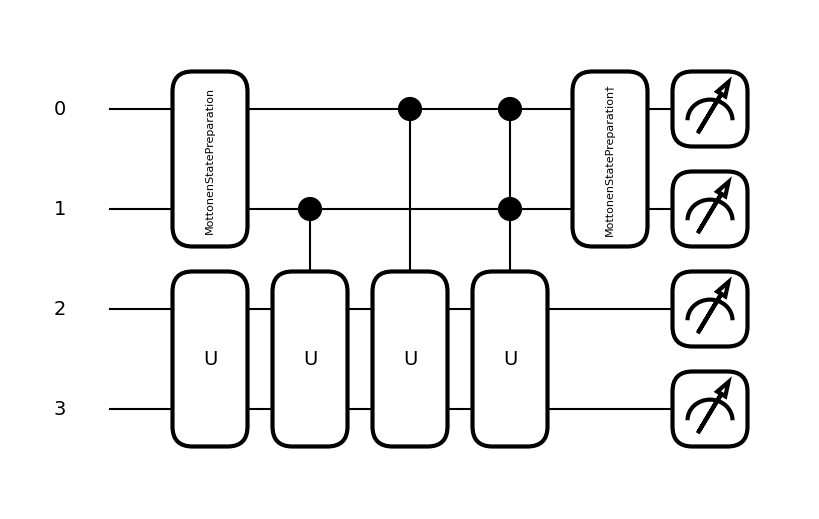

In [24]:
circuit_diagram = qml.draw_mpl(lcu_ancilla_on_top)
print(circuit_diagram())

(<Figure size 900x500 with 1 Axes>, <Axes: >)


D:\Research\vqe_U\.venv\Lib\site-packages\pennylane\ops\op_math\controlled_ops.py:41: PennyLaneDeprecationWarning: The control_wires input to ControlledQubitUnitary is deprecated and will be removed in v0.42. Please note that the second positional arg of your input is going to be the new wires, following wires=controlled_wires+target_wires, where target_wires is the optional arg wires in the legacy interface.
  warnings.warn(


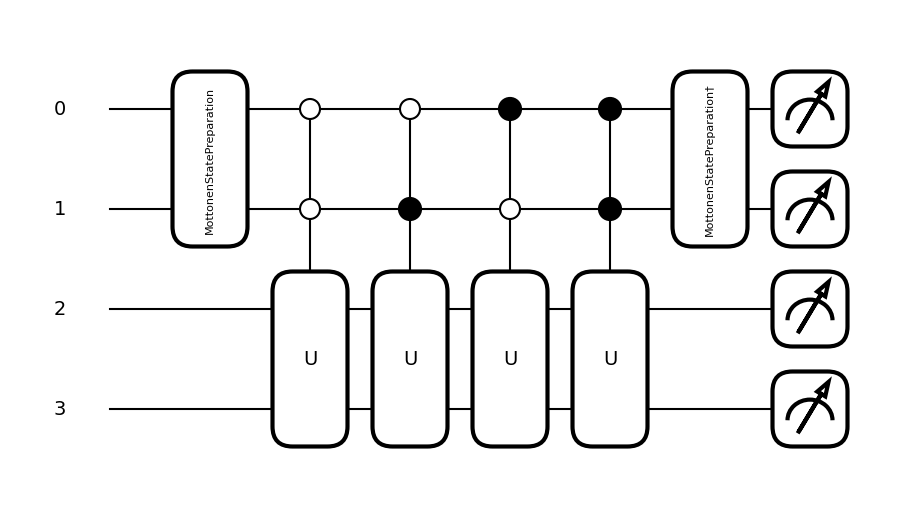

In [9]:
circuit_diagram = qml.draw_mpl(lcu_ancilla_on_top_control)
print(circuit_diagram())

In [8]:
print(U_list)

[array([[ 1,  0,  0,  0],
       [ 0, -1,  0,  0],
       [ 0,  0, -1,  0],
       [ 0,  0,  0,  1]]), array([[ 0,  1,  0,  0],
       [ 1,  0,  0,  0],
       [ 0,  0,  0, -1],
       [ 0,  0, -1,  0]]), array([[ 0,  0,  1,  0],
       [ 0,  0,  0, -1],
       [ 1,  0,  0,  0],
       [ 0, -1,  0,  0]]), array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])]


In [9]:
@qml.qnode(dev)
def lcu_ancilla_on_top_control():
    # 初始化 system 态
    # for w in [2, 3]:
    #     qml.Hadamard(w)

    # Mottonen 制备 √α 到 ancilla
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    # SELECT using controlled unitary
    for idx, U in enumerate(U_list):
        bin_str = format(idx, "02b")
        ctrl_values = [int(b) for b in bin_str]
        qml.ControlledQubitUnitary(
                U,
                control_wires=[0,1],
                control_values=ctrl_values,
                wires=[2,3]
            )
    # PREP†
    qml.adjoint(qml.Hadamard)(wires=0)
    qml.adjoint(qml.Hadamard)(wires=1)
    return qml.state()

@qml.qnode(dev)
def lcu_ancilla_on_top():
    # 初始化 system 态
    # for w in [2, 3]:
    #     qml.Hadamard(w)

    # Mottonen 制备 √α 到 ancilla
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    # SELECT using controlled unitary
    for idx, U in enumerate(U_list):
        bin_str = format(idx, "02b")
        ctrl_wires = [0 if bin_str[0] == '1' else None, 1 if bin_str[1] == '1' else None]
        ctrl_wires = [w for w in ctrl_wires if w is not None]
        qml.ControlledQubitUnitary(U, control_wires=ctrl_wires, wires=[2, 3])

    # PREP†
    qml.adjoint(qml.Hadamard)(wires=0)
    qml.adjoint(qml.Hadamard)(wires=1)

    return qml.state()

(<Figure size 900x500 with 1 Axes>, <Axes: >)


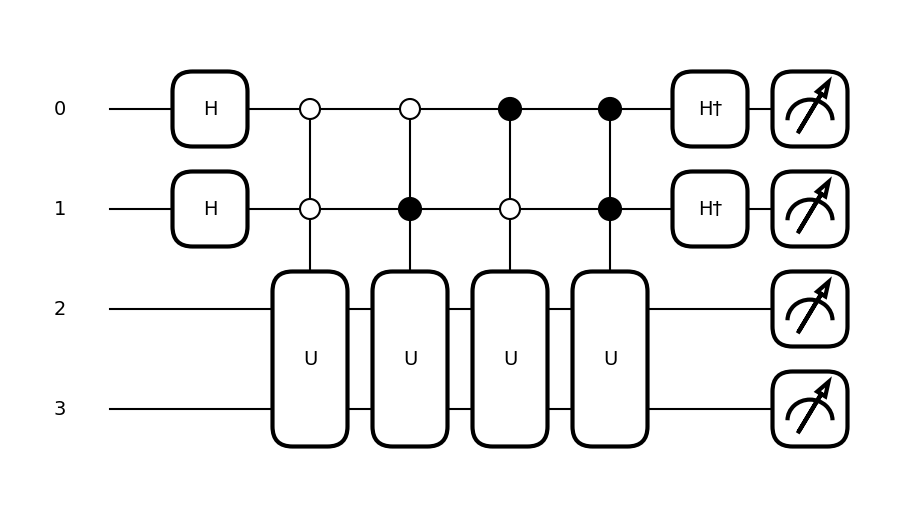

In [10]:
circuit_diagram = qml.draw_mpl(lcu_ancilla_on_top_control)
print(circuit_diagram())

(<Figure size 800x500 with 1 Axes>, <Axes: >)


C:\Users\35257\AppData\Local\Programs\Python\Python313\Lib\site-packages\pennylane\ops\op_math\controlled_ops.py:41: PennyLaneDeprecationWarning: The control_wires input to ControlledQubitUnitary is deprecated and will be removed in v0.42. Please note that the second positional arg of your input is going to be the new wires, following wires=controlled_wires+target_wires, where target_wires is the optional arg wires in the legacy interface.
  warnings.warn(


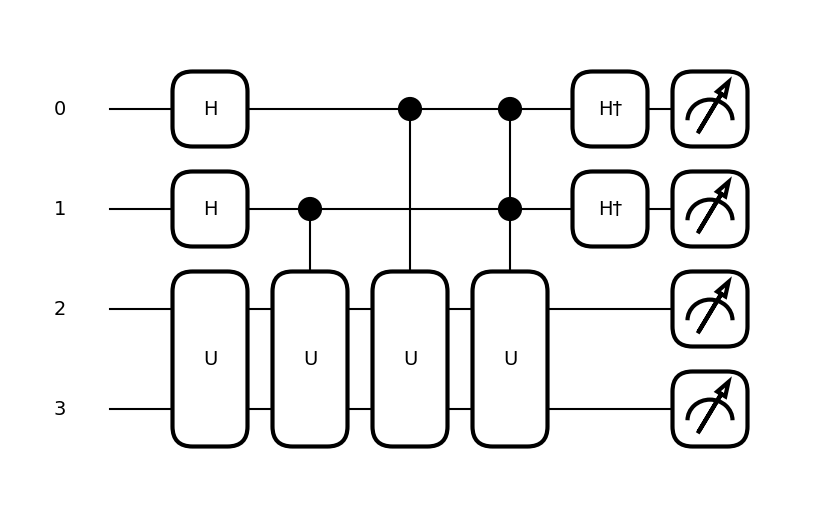

In [11]:
circuit_diagram = qml.draw_mpl(lcu_ancilla_on_top)
print(circuit_diagram())

In [12]:
# 获取对应的酉矩阵
U_mat1 = qml.matrix(lcu_ancilla_on_top, wire_order=[0,1,2,3])()[:4,:4]
U_mat2 = qml.matrix(lcu_ancilla_on_top_control, wire_order=[0,1,2,3])()[:4,:4]

# 计算理论上的理想酉矩阵（即 Select 的形式）
ideal = np.zeros((2**2, 2**2), dtype=complex)
for idx, U in enumerate(U_list):
    # 构造 control projector
    proj = np.zeros((2**2, 2**2))
    proj[idx, idx] = 1
    full_proj = np.kron(proj, U)
    ideal += 1/4* U

# 对比
print("||U_mat1 - ideal|| =", np.linalg.norm(U_mat1 - ideal))
print("||U_mat2 - ideal|| =", np.linalg.norm(U_mat2 - ideal))


||U_mat1 - ideal|| = 1.2247448713915887
||U_mat2 - ideal|| = 3.3306690738754696e-16


C:\Users\35257\AppData\Local\Programs\Python\Python313\Lib\site-packages\pennylane\ops\op_math\controlled_ops.py:41: PennyLaneDeprecationWarning: The control_wires input to ControlledQubitUnitary is deprecated and will be removed in v0.42. Please note that the second positional arg of your input is going to be the new wires, following wires=controlled_wires+target_wires, where target_wires is the optional arg wires in the legacy interface.
  warnings.warn(


In [13]:
ideal0 = U_list[0]+U_list[1]@ U_list[0]+U_list[2] @ U_list[0] + U_list[3] @ U_list[2] @ U_list[1] @ U_list[0]
print("||U_mat1 - ideal0|| =", np.linalg.norm(U_mat1 - 1/4* ideal0))

||U_mat1 - ideal0|| = 3.330671980893732e-16


In [14]:
U_list[0]@U_list[1] - U_list[1]@U_list[0]

array([[ 0,  2,  0,  0],
       [-2,  0,  0,  0],
       [ 0,  0,  0,  2],
       [ 0,  0, -2,  0]])

In [11]:
import numpy as np
import math
from scipy.linalg import expm, norm

# Step 1: 构造 TFIM Hamiltonian（n=4）
n = 4
dim = 2**n

Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
I = np.eye(2)

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

H = np.zeros((dim, dim), dtype=np.complex128)
for i in range(n):
    # Z_i Z_{i+1}
    Zi = [I] * n
    Zi[i] = Z
    Zi[(i+1) % n] = Z
    H -= kron_n(Zi)
    # X_i
    Xi = [I] * n
    Xi[i] = X
    H -= kron_n(Xi)

# Step 2: 构造 LCU 近似的 cos^{2m}(H)
m = 4
k_vals = np.arange(-m, m + 1)
alpha_k = 2**(-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals])
cos2m_lcu = sum(alpha * expm(2j * k * H) for alpha, k in zip(alpha_k, k_vals))

# Step 3: 构造 “严格定义”的 cos^{2m}(H)
cos_H = (expm(1j * H) + expm(-1j * H)) / 2
cos2m_exact = np.linalg.matrix_power(cos_H, 2 * m)

# Step 4: 比较
diff = norm(cos2m_exact - cos2m_lcu)
rel_error = diff / norm(cos2m_exact)

print("Frobenius norm of difference:", diff)
print("Relative error:", rel_error)


Frobenius norm of difference: 1.574763420697313e-15
Relative error: 7.869865016030515e-16


In [12]:
import numpy as np
import math
import pennylane as qml
from scipy.linalg import expm

# === Step 1: 构造 TFIM Hamiltonian H（n=4）===
n = 4
dim = 2 ** n
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
I = np.eye(2)

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

H = np.zeros((dim, dim), dtype=np.complex128)
for i in range(n):
    Zi = [I] * n
    Zi[i] = Z
    Zi[(i + 1) % n] = Z
    H -= kron_n(Zi)
    Xi = [I] * n
    Xi[i] = X
    H -= kron_n(Xi)

# === Step 2: 构造 cos^{2m}(H) 的 LCU 表达式 ===
m = 6
k_vals = np.arange(-m, m + 1)
alpha_k = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals])
cos2m_mat = sum(alpha * expm(2j * k * H) for alpha, k in zip(alpha_k, k_vals))

# === Step 3: 构造 BE 所需参数 ===
alpha_norm = np.sum(alpha_k)
alpha_k_normalized = alpha_k / alpha_norm
sqrt_alpha = np.sqrt(alpha_k_normalized)
pad_len = 2 ** int(np.ceil(np.log2(len(sqrt_alpha))))
alphas_padded = np.zeros(pad_len)
alphas_padded[:len(sqrt_alpha)] = sqrt_alpha

n_ancilla = int(np.log2(pad_len))
ancilla_wires = list(range(n_ancilla))         # e.g. [0,1,2]
system_wires = list(range(n_ancilla, n_ancilla + n))  # e.g. [3,4,5,6]
total_wires = ancilla_wires + system_wires

# === Step 4: 构造 QubitUnitary 操作列表（Select 使用）===
U_list = [expm(2j * k * H) for k in k_vals]
U_list += [np.eye(dim)] * (pad_len - len(U_list))  # padding
U_ops = [qml.QubitUnitary(U, wires=system_wires) for U in U_list]

# === Step 5: 构建 block-encoding 电路 ===
dev = qml.device("default.qubit", wires=n + n_ancilla)

@qml.qnode(dev)
def circuit():
    qml.StatePrep(alphas_padded, wires=ancilla_wires)
    qml.Select(U_ops, control=ancilla_wires)
    qml.adjoint(qml.StatePrep)(alphas_padded, wires=ancilla_wires)
    return qml.state()

# === Step 6: 提取 block-encoded 矩阵左上角，并比较 ===
U_be = qml.matrix(circuit, wire_order=ancilla_wires + system_wires)()
A_block = U_be[:dim, :dim]  # ancilla projected to |0...0>

diff = np.linalg.norm(A_block - cos2m_mat)
rel_error = diff / np.linalg.norm(cos2m_mat)

# === 输出结果 ===
np.set_printoptions(precision=4, suppress=True)
print("Original cos^{2m}(H) from LCU:")
print(np.round(cos2m_mat, 4))

# print("\nBlock-encoded A (upper-left corner of BE matrix):")
# print(np.round(A_block, 4))

print(f"\nFrobenius norm of difference: {diff:.6e}")
print(f"Relative error: {rel_error:.6e}")


Original cos^{2m}(H) from LCU:
[[ 0.0009-0.j -0.0009-0.j -0.0009-0.j -0.0001-0.j -0.0009-0.j -0.0001+0.j
  -0.0001-0.j  0.0007+0.j -0.0009+0.j -0.0001+0.j -0.0001-0.j  0.0007-0.j
  -0.0001-0.j  0.0007-0.j  0.0007+0.j -0.0004+0.j]
 [-0.0009+0.j  0.377 +0.j -0.1249-0.j  0.    +0.j -0.123 -0.j  0.0009-0.j
   0.    -0.j -0.1249-0.j -0.1249+0.j  0.    -0.j -0.0007+0.j -0.1269-0.j
   0.    +0.j -0.1249-0.j  0.3731-0.j  0.0007-0.j]
 [-0.0009+0.j -0.1249-0.j  0.377 +0.j  0.    +0.j -0.1249-0.j -0.0007-0.j
  -0.    -0.j -0.1269+0.j -0.123 +0.j  0.    +0.j  0.0009+0.j -0.1249+0.j
   0.    -0.j  0.3731-0.j -0.1249+0.j  0.0007+0.j]
 [-0.0001-0.j -0.    -0.j  0.    -0.j  0.2502-0.j  0.    -0.j -0.0001-0.j
  -0.2498-0.j  0.    +0.j  0.    +0.j -0.2498-0.j -0.0001-0.j  0.    -0.j
   0.2502-0.j  0.    +0.j  0.    -0.j -0.0001-0.j]
 [-0.0009+0.j -0.123 -0.j -0.1249+0.j -0.    +0.j  0.377 +0.j  0.0009-0.j
   0.    +0.j -0.1249+0.j -0.1249-0.j  0.    -0.j -0.0007-0.j  0.3731+0.j
  -0.    +0.j -0.1249-0.j

(<Figure size 600x900 with 1 Axes>, <Axes: >)


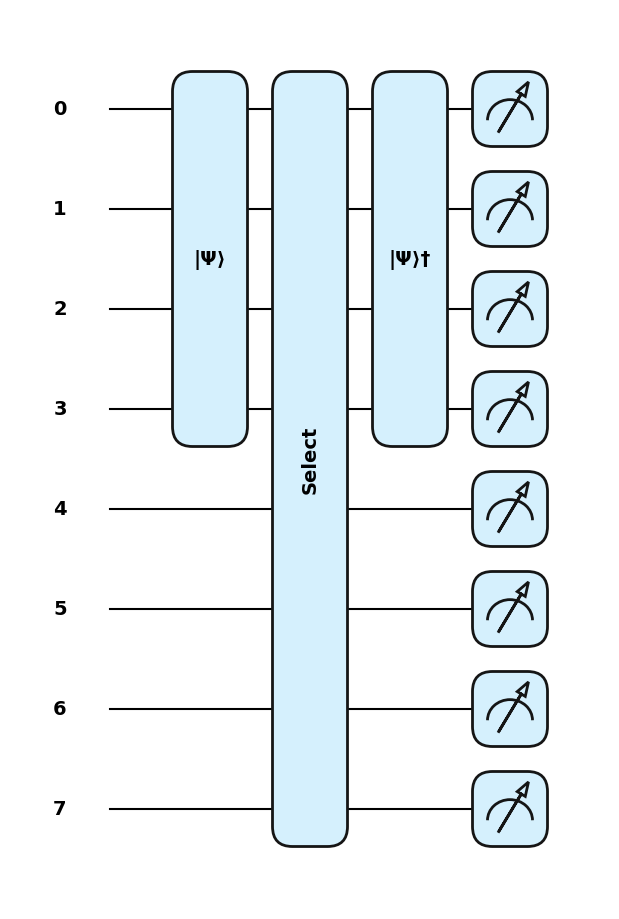

In [174]:
circuit_diagram = qml.draw_mpl(circuit, style='pennylane')
print(circuit_diagram())

In [4]:
import numpy as np
import math
import pennylane as qml
from scipy.linalg import expm

# === 参数设置 ===
n = 4
m = 6
dim = 2 ** n
init_state = np.ones(dim) / np.sqrt(dim)

# === 构造 H ===
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
I = np.eye(2)

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

H = np.zeros((dim, dim), dtype=np.complex128)
for i in range(n):
    Zi = [I] * n
    Zi[i] = Z
    Zi[(i + 1) % n] = Z
    H -= kron_n(Zi)
    Xi = [I] * n
    Xi[i] = X
    H -= kron_n(Xi)

eigvals, eigvecs = np.linalg.eigh(H)
λ_min, λ_max = np.min(eigvals), np.max(eigvals)
H_norm = (H - λ_min * np.eye(dim)) / (λ_max - λ_min)
λ0 = np.min(np.linalg.eigvalsh(H_norm))
H_shifted = H_norm - λ0 * np.eye(dim)
ground_state = eigvecs[:, 0]

# === 准备 LCU 系数 ===
k_vals_full = np.arange(-m, m + 1)
alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
alpha_k = alpha_k_full[keep]
k_vals = k_vals_full[keep]
alpha_k /= np.sum(alpha_k)

# === 方法一：LCU 电路版本 ===
pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
alpha_padded = np.zeros(pad_len)
alpha_padded[:len(alpha_k)] = alpha_k
weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
n_anc = int(np.log2(pad_len))
dev = qml.device("default.qubit", wires=n + n_anc)

@qml.qnode(dev)
def circuit():
    for i in range(n):
        qml.Hadamard(i)
    qml.MottonenStatePreparation(weights, wires=range(n, n + n_anc))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    for idx, U in enumerate(U_list):
        bin_str = format(idx, f"0{n_anc}b")
        ctrl_wires = [n + i for i, b in enumerate(bin_str) if b == '1']
        qml.ControlledQubitUnitary(U, control_wires=ctrl_wires, wires=range(n))
    qml.adjoint(qml.MottonenStatePreparation)(weights, wires=range(n, n + n_anc))
    return qml.state()

full_state = circuit()
reshaped = full_state.reshape((2**n, 2**n_anc))
system_state = reshaped[:, 0]
main_state = system_state / np.linalg.norm(system_state)
fidelity1 = np.abs(np.vdot(main_state, ground_state))**2
print("LCU 电路 Fidelity:", fidelity1)

# === 方法二：提取 block-encoding 左上角 block 再作用在初始态上 ===
U_list = [expm(2j * k * H_shifted) for k in k_vals]
U_list += [np.eye(dim)] * (pad_len - len(U_list))
U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
dev2 = qml.device("default.qubit", wires=n + n_anc)
@qml.qnode(dev2)
def block_encoding():
    qml.StatePrep(np.sqrt(alpha_padded), wires=range(n_anc))
    qml.Select(U_ops, control=range(n_anc))
    qml.adjoint(qml.StatePrep)(np.sqrt(alpha_padded), wires=range(n_anc))
    return qml.state()

U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
A_block = U_be[:dim, :dim]
be_state = A_block @ init_state
be_state /= np.linalg.norm(be_state)
fidelity2 = np.abs(np.vdot(be_state, ground_state))**2
print("Block-Encoding Fidelity:", fidelity2)

# === 方法三：直接构造 cos^{2m}(H) 作用在 |+⟩ 上 ===
cos_op = sum(alpha * expm(2j * k * H_shifted) for alpha, k in zip(alpha_k, k_vals))
cos_state = np.linalg.matrix_power(cos_op, 1) @ init_state
cos_state /= np.linalg.norm(cos_state)
fidelity3 = np.abs(np.vdot(cos_state, ground_state))**2
print("直接矩阵构造 Fidelity:", fidelity3)


LCU 电路 Fidelity: 0.9908047391429247
Block-Encoding Fidelity: 0.8641917937225909
直接矩阵构造 Fidelity: 0.8641917937225911


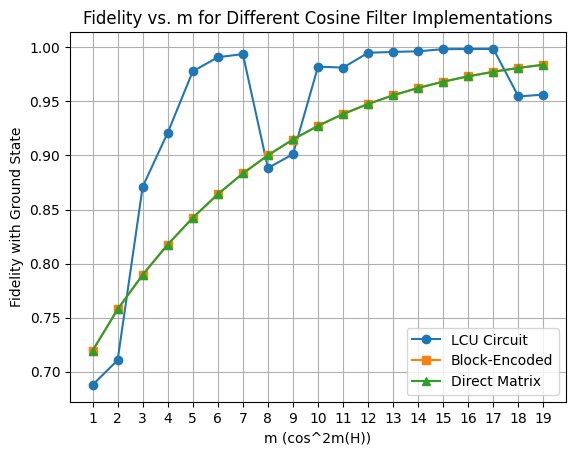

In [92]:
import numpy as np
import math
import pennylane as qml
from scipy.linalg import expm
import matplotlib.pyplot as plt

# === 参数设置 ===
n = 4
dim = 2 ** n
init_state = np.ones(dim) / np.sqrt(dim)

# 构造 TFIM Hamiltonian
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
I = np.eye(2)

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

H = np.zeros((dim, dim), dtype=np.complex128)
for i in range(n):
    Zi = [I] * n
    Zi[i] = Z
    Zi[(i + 1) % n] = Z
    H -= kron_n(Zi)
    Xi = [I] * n
    Xi[i] = X
    H -= kron_n(Xi)

eigvals, eigvecs = np.linalg.eigh(H)
λ_min, λ_max = np.min(eigvals), np.max(eigvals)
H_norm = (H - λ_min * np.eye(dim)) / (λ_max - λ_min)
λ0 = np.min(np.linalg.eigvalsh(H_norm))
H_shifted = H_norm - λ0 * np.eye(dim)
eigvals, eigvecs = np.linalg.eigh(H_shifted)
ground_state = eigvecs[:, 0]

# === 方法封装 ===
def fidelity_lcu_circuit(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)

    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))

    dev = qml.device("default.qubit", wires=n + n_anc)
    @qml.qnode(dev)
    def circuit():
        for i in range(n):
            qml.Hadamard(i)
        qml.MottonenStatePreparation(weights, wires=range(n, n + n_anc))
        U_list = [expm(2j * k * H_shifted) for k in k_vals]
        U_list += [np.eye(dim)] * (pad_len - len(U_list))
        for idx, U in enumerate(U_list):
            bin_str = format(idx, f"0{n_anc}b")
            ctrl_wires = [n + i for i, b in enumerate(bin_str) if b == '1']
            qml.ControlledQubitUnitary(U, control_wires=ctrl_wires, wires=range(n))
        qml.adjoint(qml.MottonenStatePreparation)(weights, wires=range(n, n + n_anc))
        return qml.state()

    full_state = circuit()
    reshaped = full_state.reshape((2**n, 2**n_anc))
    system_state = reshaped[:, 0]
    main_state = system_state / np.linalg.norm(system_state)
    fidelity = np.abs(np.vdot(main_state, ground_state))**2
    return fidelity

def fidelity_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)

    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    n_anc = int(np.log2(pad_len))

    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        qml.StatePrep(np.sqrt(alpha_padded), wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(np.sqrt(alpha_padded), wires=range(n_anc))
        return qml.state()

    U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    A_block = U_be[:dim, :dim]
    be_state = A_block @ init_state
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state))**2
    return fidelity

def fidelity_cos_exact(m):
    """
    使用精确的 cos(H) 计算 cos^{2m}(H) 并作用在初始态上
    """
    cosH = cosm(H_shifted)
    cosH_powered = np.linalg.matrix_power(cosH, 2 * m)
    final_state = cosH_powered @ init_state
    final_state /= np.linalg.norm(final_state)
    fidelity = np.abs(np.vdot(final_state, ground_state))**2
    return fidelity

# === 扫描不同的 m 值 ===
m_vals = list(range(1, 20))
fidelity_lcu = [fidelity_lcu_circuit(m) for m in m_vals]
fidelity_be = [fidelity_block_encoding(m) for m in m_vals]
fidelity_cos = [fidelity_cos_exact(m) for m in m_vals]

# === 绘图 ===
plt.plot(m_vals, fidelity_lcu, marker='o', label='LCU Circuit')
plt.plot(m_vals, fidelity_be, marker='s', label='Block-Encoded')
plt.plot(m_vals, fidelity_cos, marker='^', label='Direct Matrix')
plt.xticks(m_vals)  # 横坐标限制为整数
plt.xlabel("m (cos^2m(H))")
plt.ylabel("Fidelity with Ground State")
plt.title("Fidelity vs. m for Different Cosine Filter Implementations")
plt.legend()
plt.grid(True)
plt.show()


(<Figure size 2100x900 with 1 Axes>, <Axes: >)


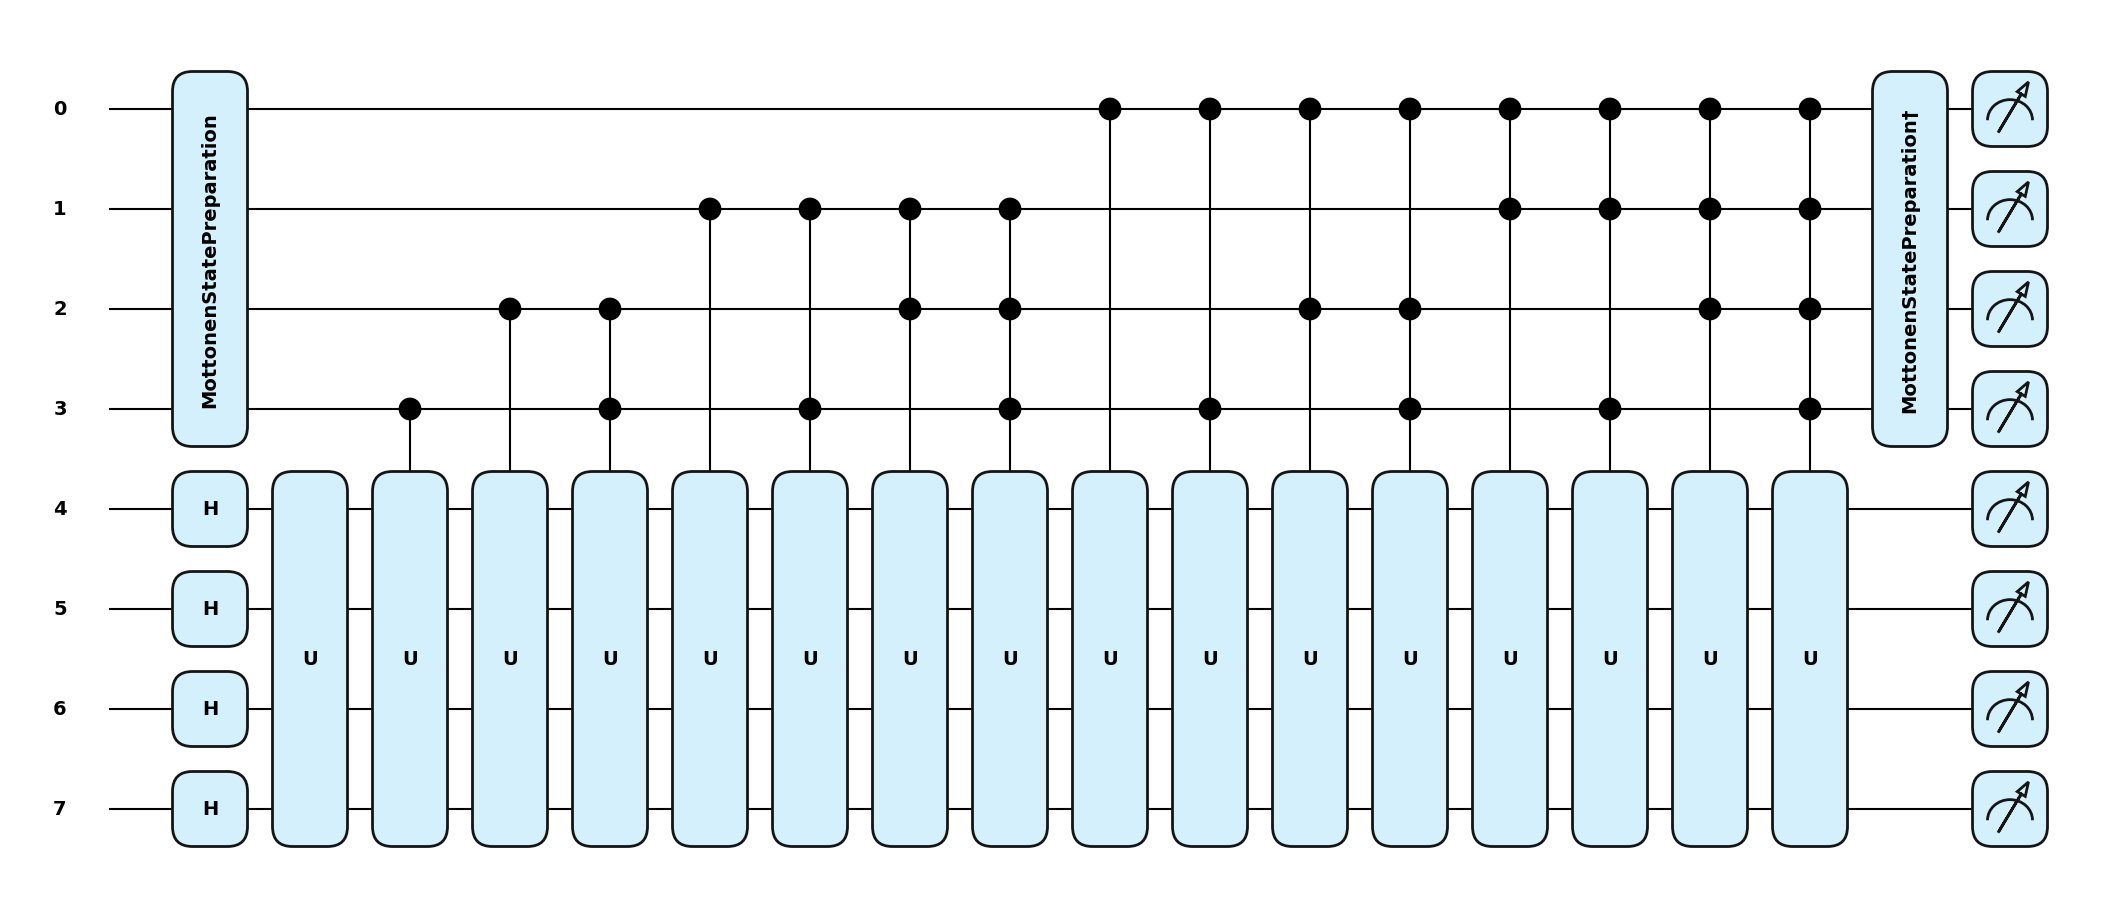

In [85]:
circuit_diagram = qml.draw_mpl(circuit, style='pennylane')
print(circuit_diagram())

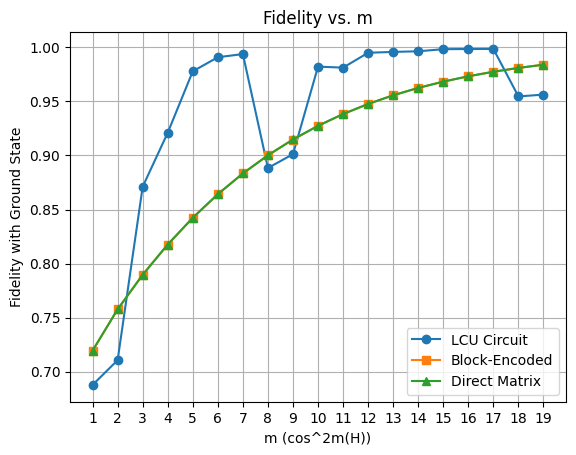

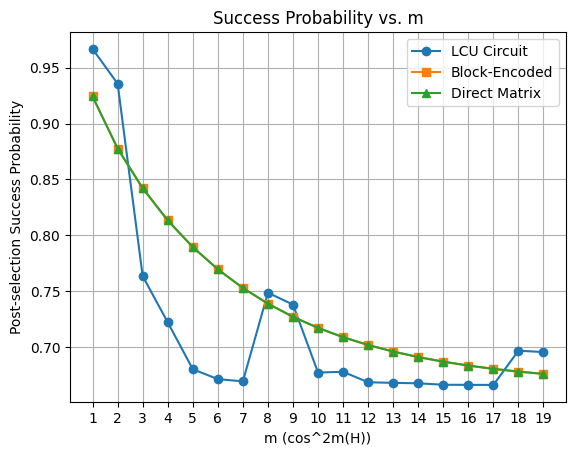

In [158]:
import numpy as np
import math
import pennylane as qml
from scipy.linalg import expm
import matplotlib.pyplot as plt

# 设置系统大小
n =  4
dim = 2 ** n
init_state = np.ones(dim) / np.sqrt(dim)

Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
I = np.eye(2)

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# 构造 TFIM H
H = np.zeros((dim, dim), dtype=np.complex128)
for i in range(n):
    Zi = [I] * n
    Zi[i] = Z
    Zi[(i + 1) % n] = Z
    H -= kron_n(Zi)
    Xi = [I] * n
    Xi[i] = X
    H -= kron_n(Xi)

eigvals, eigvecs = np.linalg.eigh(H)
λ_min, λ_max = np.min(eigvals), np.max(eigvals)
H_norm = (H - λ_min * np.eye(dim)) / (λ_max - λ_min)
λ0 = np.min(np.linalg.eigvalsh(H_norm))
H_shifted = H_norm - λ0 * np.eye(dim)
ground_state = np.linalg.eigh(H_shifted)[1][:, 0]

def fidelity_lcu_circuit(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    dev = qml.device("default.qubit", wires=n + n_anc)
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))

    @qml.qnode(dev)
    def circuit():
        for i in system_wires:
            qml.Hadamard(i)
        qml.MottonenStatePreparation(weights, wires=ancilla_wires)
        for idx, U in enumerate(U_list):
            bin_str = format(idx, f"0{n_anc}b")
            ctrl_wires = [ancilla_wires[i] for i, b in enumerate(bin_str) if b == '1']
            qml.ControlledQubitUnitary(U, control_wires=ctrl_wires, wires=system_wires)
        qml.adjoint(qml.MottonenStatePreparation)(weights, wires=ancilla_wires)
        return qml.state()

    # U_lcu = qml.matrix(circuit, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_lcu[:dim, :dim]
    # be_state = A_block @ init_state
    # success_prob = np.sum(np.abs(be_state) ** 2)
    # be_state /= np.linalg.norm(be_state)
    # fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2

    full_state = circuit()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    success_prob = np.sum(np.abs(system_state) ** 2)
    normalized_system = system_state / np.linalg.norm(system_state)
    fidelity = np.abs(np.vdot(normalized_system, ground_state)) ** 2
    return fidelity, success_prob

def fidelity_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    A_block = U_be[:dim, :dim]
    be_state = A_block @ init_state
    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob

def cosm(A):
    return 0.5 * (expm(1j * A) + expm(-1j * A))

def fidelity_cos_exact(m):
    cosH = cosm(H_shifted)
    cosH_powered = np.linalg.matrix_power(cosH, 2 * m)
    final_state = cosH_powered @ init_state
    success_prob = np.sum(np.abs(final_state) ** 2)
    final_state /= np.linalg.norm(final_state)
    fidelity = np.abs(np.vdot(final_state, ground_state)) ** 2
    return fidelity, success_prob

# 扫描 m
m_vals = list(range(1, 20))
fidelity_lcu, success_lcu = zip(*[fidelity_lcu_circuit(m) for m in m_vals])
fidelity_be, success_be = zip(*[fidelity_block_encoding(m) for m in m_vals])
fidelity_cos, success_cos = zip(*[fidelity_cos_exact(m) for m in m_vals])

# 绘图
plt.figure()
plt.plot(m_vals, fidelity_lcu, marker='o', label='LCU Circuit')
plt.plot(m_vals, fidelity_be, marker='s', label='Block-Encoded')
plt.plot(m_vals, fidelity_cos, marker='^', label='Direct Matrix')
plt.xlabel("m (cos^2m(H))")
plt.xticks(m_vals)  # 横坐标限制为整数
plt.ylabel("Fidelity with Ground State")
plt.title("Fidelity vs. m")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(m_vals, success_lcu, marker='o', label='LCU Circuit')
plt.plot(m_vals, success_be, marker='s', label='Block-Encoded')
plt.plot(m_vals, success_cos, marker='^', label='Direct Matrix')
plt.xlabel("m (cos^2m(H))")
plt.xticks(m_vals)  # 横坐标限制为整数
plt.ylabel("Post-selection Success Probability")
plt.title("Success Probability vs. m")
plt.legend()
plt.grid(True)
plt.show()


(<Figure size 2100x900 with 1 Axes>, <Axes: >)


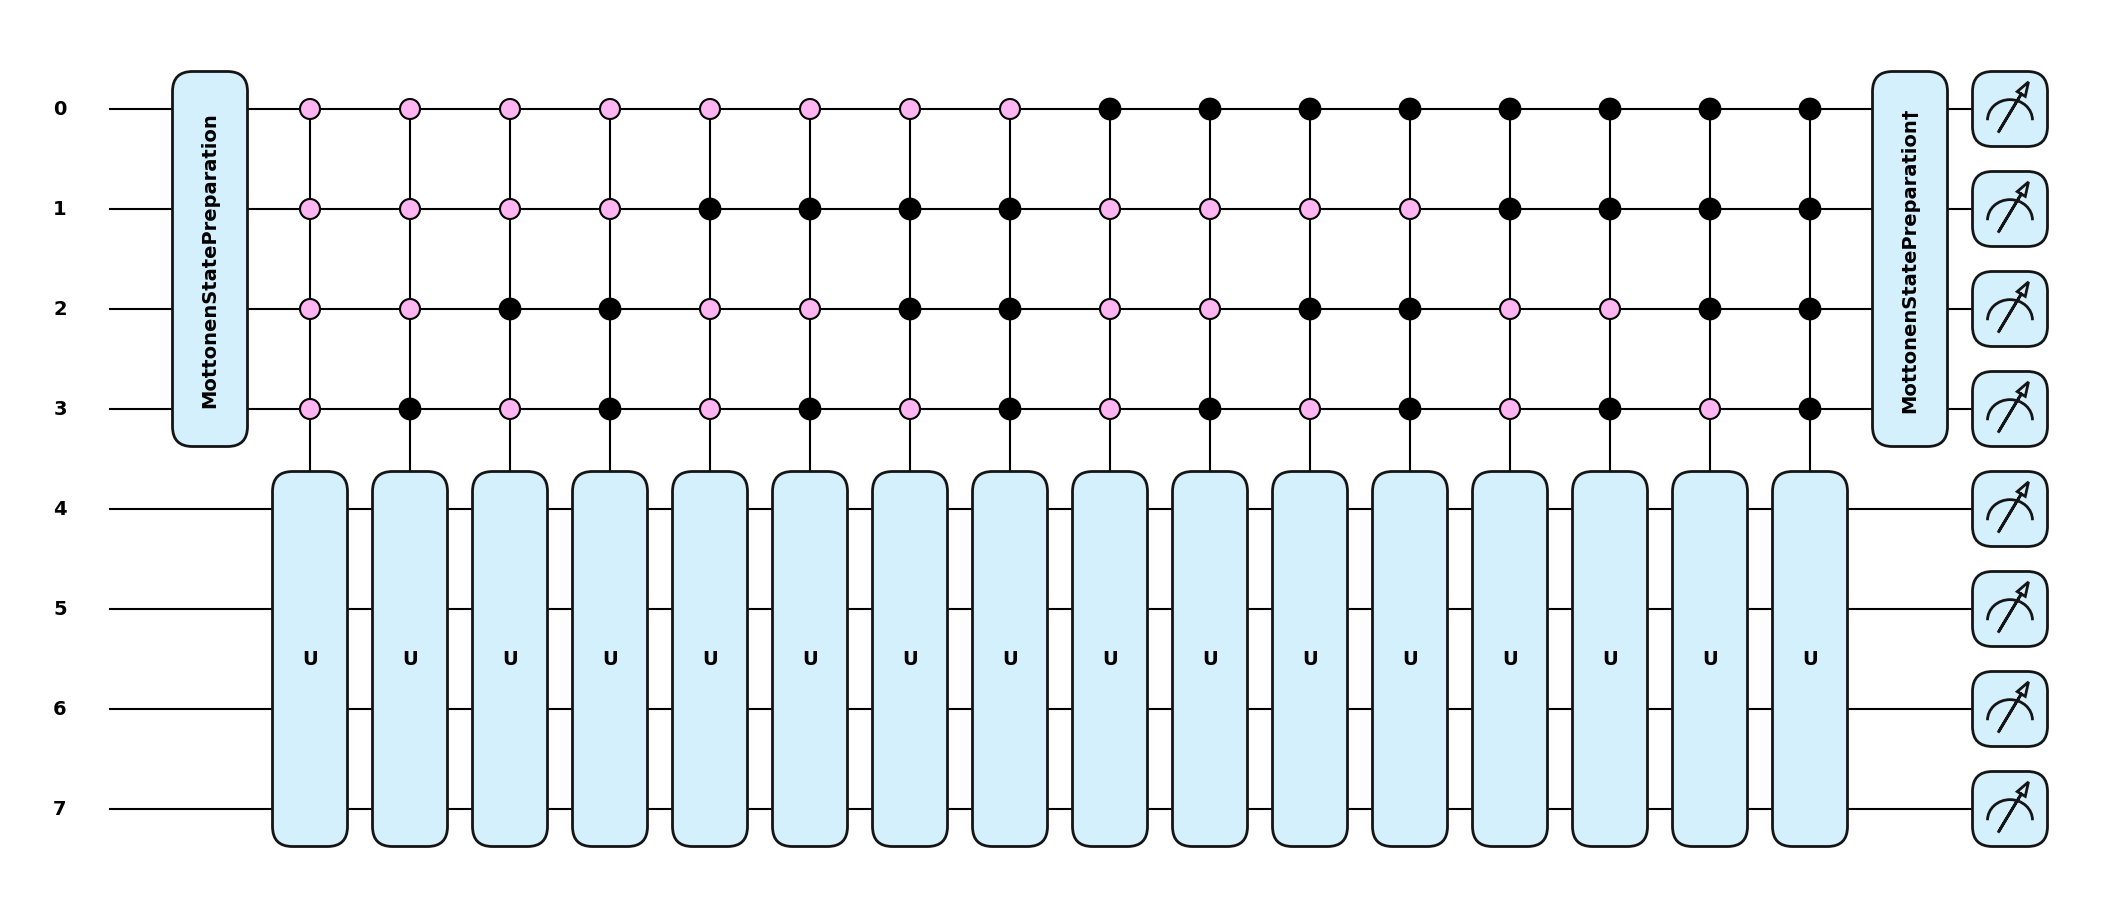

In [160]:
def fidelity_lcu_circuit(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def circuit_precise():
        qml.MottonenStatePreparation(weights, wires=ancilla_wires)
        for idx, U in enumerate(U_ops):
            bin_str = format(idx, f"0{n_anc}b")
            ctrl_values = [int(b) for b in bin_str]
            qml.ControlledQubitUnitary(
                U,
                control_wires=ancilla_wires,
                control_values=ctrl_values,
                wires=system_wires
            )
        qml.adjoint(qml.MottonenStatePreparation(weights, wires=ancilla_wires))
        return qml.state()
    circuit_diagram = qml.draw_mpl(circuit_precise, style='pennylane')
    print(circuit_diagram())
    return None

fidelity_lcu_circuit(6)


[CRTL Wires] []
[CRTL Wires] [3]
[CRTL Wires] [2]
[CRTL Wires] [2, 3]
[CRTL Wires] [1]
[CRTL Wires] [1, 3]
[CRTL Wires] [1, 2]
[CRTL Wires] [1, 2, 3]
[CRTL Wires] [0]
[CRTL Wires] [0, 3]
[CRTL Wires] [0, 2]
[CRTL Wires] [0, 2, 3]
[CRTL Wires] [0, 1]
[CRTL Wires] [0, 1, 3]
[CRTL Wires] [0, 1, 2]
[CRTL Wires] [0, 1, 2, 3]


D:\Research\vqe_U\.venv\Lib\site-packages\pennylane\ops\op_math\controlled_ops.py:41: PennyLaneDeprecationWarning: The control_wires input to ControlledQubitUnitary is deprecated and will be removed in v0.42. Please note that the second positional arg of your input is going to be the new wires, following wires=controlled_wires+target_wires, where target_wires is the optional arg wires in the legacy interface.
  warnings.warn(
D:\Research\vqe_U\.venv\Lib\site-packages\pennylane\ops\op_math\controlled_ops.py:185: PennyLaneDeprecationWarning: QubitUnitary input to ControlledQubitUnitary is deprecated and will be removed in v0.42. Instead, please use a full matrix as input, or try qml.ctrl for controlled QubitUnitary.
  warnings.warn(


(<Figure size 2000x900 with 1 Axes>, <Axes: >)


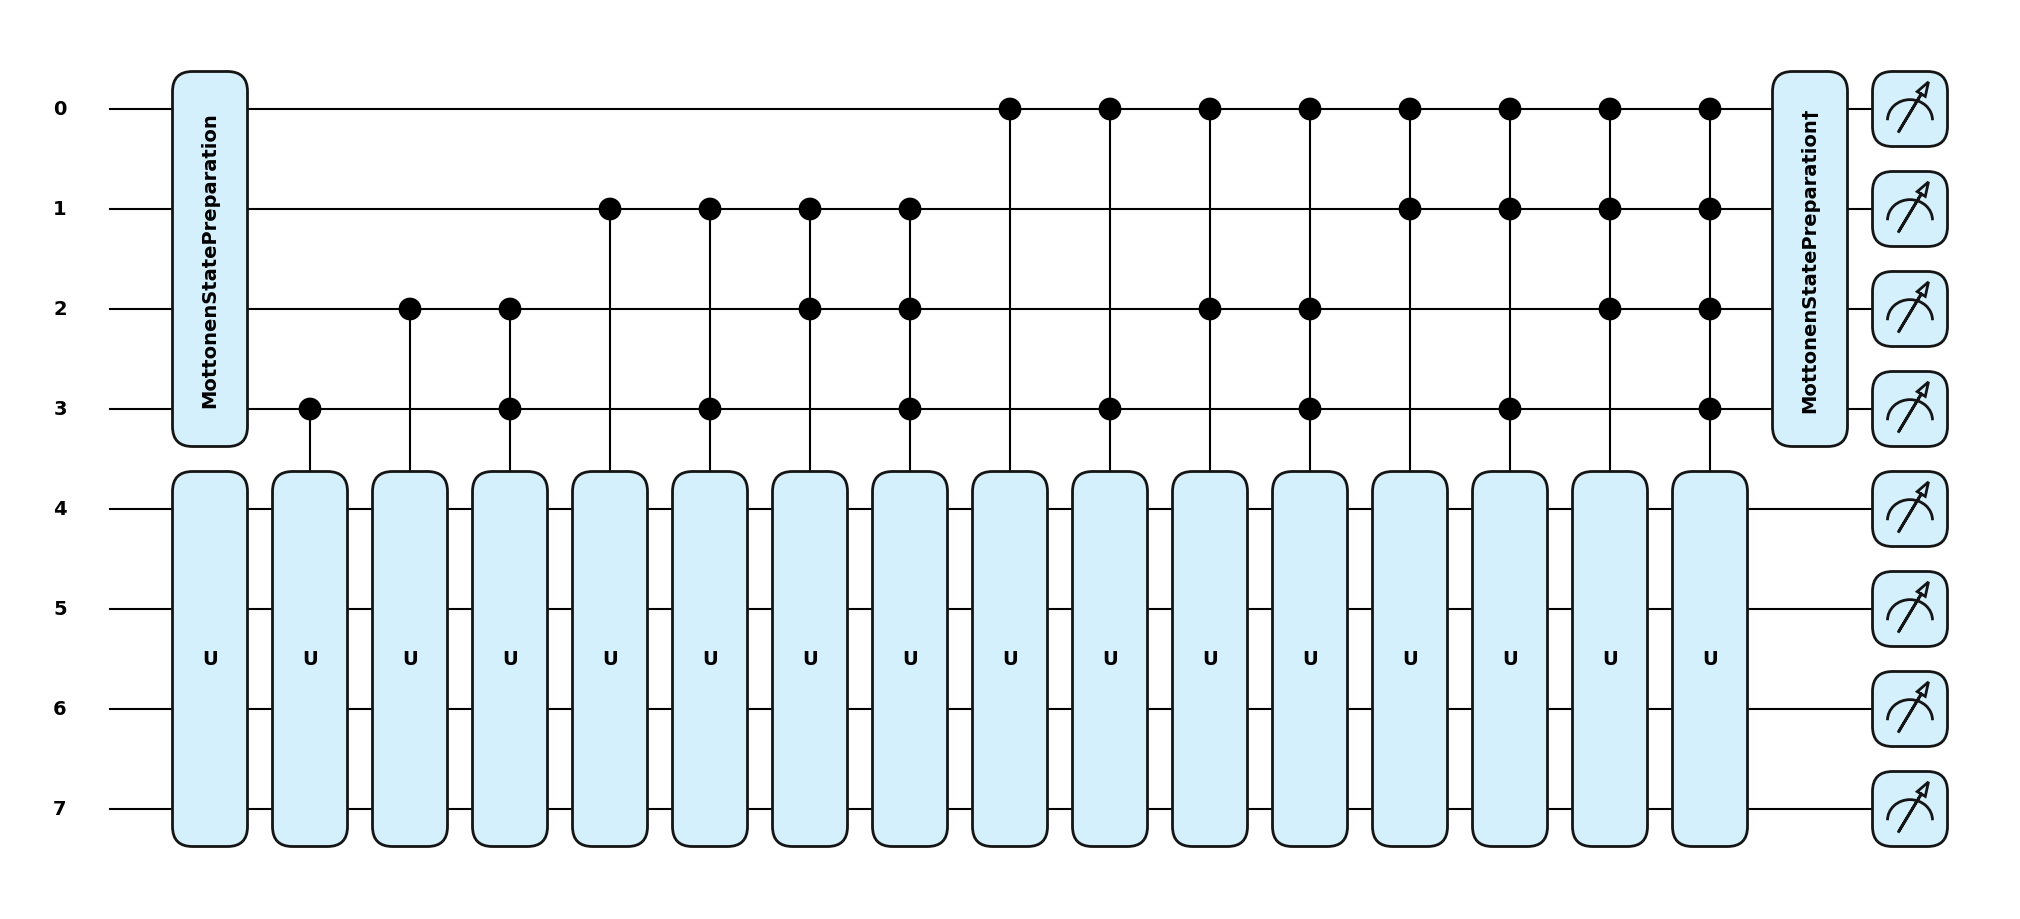

In [161]:
def fidelity_lcu_circuit(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def circuit_precise():
        qml.MottonenStatePreparation(weights, wires=ancilla_wires)
        for idx, U in enumerate(U_ops):
            bin_str = format(idx, f"0{n_anc}b")
            ctrl_wires = [ancilla_wires[i] for i, b in enumerate(bin_str) if b == '1']
            print('[CRTL Wires]', ctrl_wires)
            qml.ControlledQubitUnitary(U, control_wires=ctrl_wires, wires=system_wires)
        qml.adjoint(qml.MottonenStatePreparation(weights, wires=ancilla_wires))
        return qml.state()
    circuit_diagram = qml.draw_mpl(circuit_precise, style='pennylane')
    print(circuit_diagram())
    return None

fidelity_lcu_circuit(6)

D:\Research\vqe_U\.venv\Lib\site-packages\pennylane\ops\op_math\controlled_ops.py:41: PennyLaneDeprecationWarning: The control_wires input to ControlledQubitUnitary is deprecated and will be removed in v0.42. Please note that the second positional arg of your input is going to be the new wires, following wires=controlled_wires+target_wires, where target_wires is the optional arg wires in the legacy interface.
  warnings.warn(


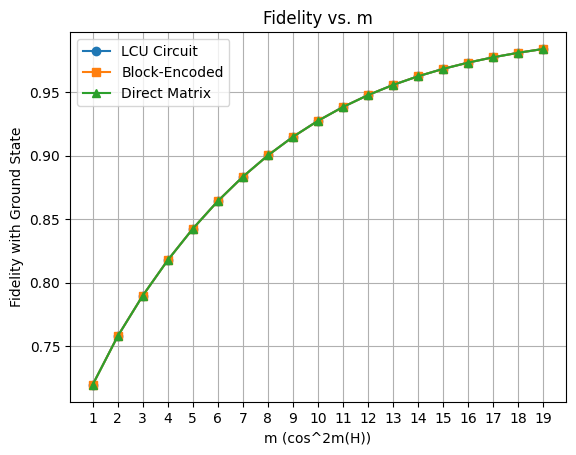

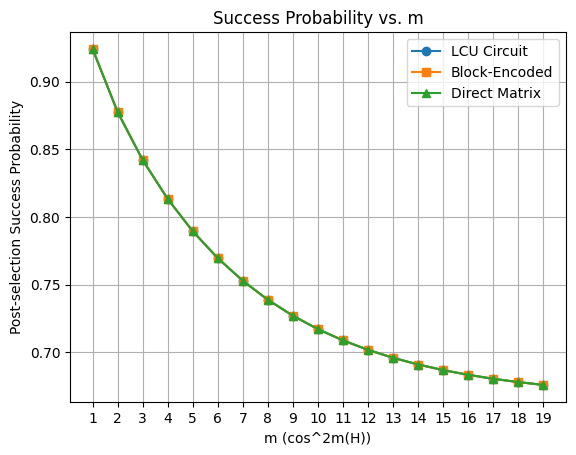

In [162]:
import numpy as np
import math
import pennylane as qml
from scipy.linalg import expm
import matplotlib.pyplot as plt

# 设置系统大小
n =  4
dim = 2 ** n
init_state = np.ones(dim) / np.sqrt(dim)

Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
I = np.eye(2)

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# 构造 TFIM H
H = np.zeros((dim, dim), dtype=np.complex128)
for i in range(n):
    Zi = [I] * n
    Zi[i] = Z
    Zi[(i + 1) % n] = Z
    H -= kron_n(Zi)
    Xi = [I] * n
    Xi[i] = X
    H -= kron_n(Xi)

eigvals, eigvecs = np.linalg.eigh(H)
λ_min, λ_max = np.min(eigvals), np.max(eigvals)
H_norm = (H - λ_min * np.eye(dim)) / (λ_max - λ_min)
λ0 = np.min(np.linalg.eigvalsh(H_norm))
H_shifted = H_norm - λ0 * np.eye(dim)
ground_state = np.linalg.eigh(H_shifted)[1][:, 0]

def fidelity_lcu_circuit(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    dev = qml.device("default.qubit", wires=n + n_anc)
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))

    @qml.qnode(dev)
    def circuit():
        for i in system_wires:
            qml.Hadamard(i)
        qml.MottonenStatePreparation(weights, wires=ancilla_wires)
        for idx, U in enumerate(U_list):
            bin_str = format(idx, f"0{n_anc}b")
            ctrl_values = [int(b) for b in bin_str]
            qml.ControlledQubitUnitary(
                U,
                control_wires=ancilla_wires,
                control_values=ctrl_values,
                wires=system_wires
            )

        qml.adjoint(qml.MottonenStatePreparation)(weights, wires=ancilla_wires)
        return qml.state()

    # U_lcu = qml.matrix(circuit, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_lcu[:dim, :dim]
    # be_state = A_block @ init_state
    # success_prob = np.sum(np.abs(be_state) ** 2)
    # be_state /= np.linalg.norm(be_state)
    # fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2

    full_state = circuit()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    success_prob = np.sum(np.abs(system_state) ** 2)
    normalized_system = system_state / np.linalg.norm(system_state)
    fidelity = np.abs(np.vdot(normalized_system, ground_state)) ** 2
    return fidelity, success_prob

def fidelity_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    A_block = U_be[:dim, :dim]
    be_state = A_block @ init_state
    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob

def cosm(A):
    return 0.5 * (expm(1j * A) + expm(-1j * A))

def fidelity_cos_exact(m):
    cosH = cosm(H_shifted)
    cosH_powered = np.linalg.matrix_power(cosH, 2 * m)
    final_state = cosH_powered @ init_state
    success_prob = np.sum(np.abs(final_state) ** 2)
    final_state /= np.linalg.norm(final_state)
    fidelity = np.abs(np.vdot(final_state, ground_state)) ** 2
    return fidelity, success_prob

# 扫描 m
m_vals = list(range(1, 20))
fidelity_lcu, success_lcu = zip(*[fidelity_lcu_circuit(m) for m in m_vals])
fidelity_be, success_be = zip(*[fidelity_block_encoding(m) for m in m_vals])
fidelity_cos, success_cos = zip(*[fidelity_cos_exact(m) for m in m_vals])

# 绘图
plt.figure()
plt.plot(m_vals, fidelity_lcu, marker='o', label='LCU Circuit')
plt.plot(m_vals, fidelity_be, marker='s', label='Block-Encoded')
plt.plot(m_vals, fidelity_cos, marker='^', label='Direct Matrix')
plt.xlabel("m (cos^2m(H))")
plt.xticks(m_vals)  # 横坐标限制为整数
plt.ylabel("Fidelity with Ground State")
plt.title("Fidelity vs. m")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(m_vals, success_lcu, marker='o', label='LCU Circuit')
plt.plot(m_vals, success_be, marker='s', label='Block-Encoded')
plt.plot(m_vals, success_cos, marker='^', label='Direct Matrix')
plt.xlabel("m (cos^2m(H))")
plt.xticks(m_vals)  # 横坐标限制为整数
plt.ylabel("Post-selection Success Probability")
plt.title("Success Probability vs. m")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
import numpy as np
import math
import pennylane as qml
from scipy.linalg import expm
import matplotlib.pyplot as plt

# 设置系统大小
n =  4
dim = 2 ** n
init_state = np.ones(dim) / np.sqrt(dim)

Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
I = np.eye(2)

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# 构造 TFIM H
H = np.zeros((dim, dim), dtype=np.complex128)
for i in range(n):
    Zi = [I] * n
    Zi[i] = Z
    Zi[(i + 1) % n] = Z
    H -= kron_n(Zi)
    Xi = [I] * n
    Xi[i] = X
    H -= kron_n(Xi)

eigvals, eigvecs = np.linalg.eigh(H)
eigvals

array([-5.22625186e+00, -4.82842712e+00, -2.16478440e+00, -2.00000000e+00,
       -2.00000000e+00, -8.28427125e-01, -5.84343686e-16, -2.60721966e-16,
        3.21107000e-16,  5.65592016e-16,  8.28427125e-01,  2.00000000e+00,
        2.00000000e+00,  2.16478440e+00,  4.82842712e+00,  5.22625186e+00])

In [34]:
1/((-5.22625186e+00--4.82842712e+00)**2) * 16

101.09656681279208

In [84]:
import numpy as np
import itertools
n =  4
dim = 2 ** n

# init_state = np.zeros(dim)
# init_state[int('0101', 2)] = 1.0  # 手动设为 |0101⟩

init_state = np.ones(dim) / np.sqrt(dim)

# init_state = np.zeros(dim)
# init_state[0] = 1

Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
I = np.eye(2)


# def kron_n(op_list):
#     result = np.array([[1]])
#     for op in op_list:
#         result = np.kron(result, op)
#     return result
#
# # 构造 TFIM H
# H = np.zeros((dim, dim), dtype=np.complex128)
# for i in range(n):
#     Zi = [I] * n
#     Zi[i] = Z
#     Zi[(i + 1) % n] = Z
#     H -= kron_n(Zi)
#     Xi = [I] * n
#     Xi[i] = X
#     H -= kron_n(Xi)


def heisenberg_xyz_hamiltonian(n, Jx=1.0, Jy=1.0, Jz=1.0):
    dim = 2 ** n
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    I = np.eye(2)

    def kron_n(op_list):
        result = np.array([[1]])
        for op in op_list:
            result = np.kron(result, op)
        return result

    H = np.zeros((dim, dim), dtype=np.complex128)

    for i in range(n):
        for op, J in zip([X, Y, Z], [Jx, Jy, Jz]):
            ops = [I] * n
            ops[i] = op
            ops[(i + 1) % n] = op  # 周期性边界条件
            H += J * kron_n(ops)

    return H

H = heisenberg_xyz_hamiltonian(n,  Jx=1.0, Jy=1.0, Jz=1.0)
eigvals, eigvecs = np.linalg.eigh(H)
λ_min, λ_max = np.min(eigvals), np.max(eigvals)
H_norm = (H - λ_min * np.eye(dim)) / (λ_max - λ_min)
λ0 = np.min(np.linalg.eigvalsh(H_norm))
H_shifted = H_norm - λ0 * np.eye(dim)
ground_state = np.linalg.eigh(H_shifted)[1][:, 0]


def fidelity_lcu_circuit(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    dev = qml.device("default.qubit", wires=n + n_anc)
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))

    @qml.qnode(dev)
    def circuit():
        # for i in system_wires:
        #     qml.Hadamard(i)
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.MottonenStatePreparation(weights, wires=ancilla_wires)
        for idx, U in enumerate(U_list):
            bin_str = format(idx, f"0{n_anc}b")
            ctrl_wires = [ancilla_wires[i] for i, b in enumerate(bin_str) if b == '1']
            qml.ControlledQubitUnitary(U, control_wires=ctrl_wires, wires=system_wires)
        qml.adjoint(qml.MottonenStatePreparation)(weights, wires=ancilla_wires)
        return qml.state()

    U_circuit = qml.matrix(circuit, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    A_block = U_circuit[:dim, :dim]
    system_state = A_block @np.linalg.inv(U_list[0]) @ init_state

    # full_state = circuit()
    # reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    # system_state = reshaped[0, :]

    success_prob = np.sum(np.abs(system_state) ** 2)
    normalized_system = system_state / np.linalg.norm(system_state)
    fidelity = np.abs(np.vdot(normalized_system, ground_state)) ** 2
    return fidelity, success_prob

def active_U_indices(b, dim):
    """
    给定 ancilla 比特串 b = [b0, b1, ..., b_{n-1}]（从上到下的顺序），
    返回哪些 U_i 会被触发。
    对于 dim = 2^n，i 的二进制形式与 b 做位匹配（只看为1的位）。

    参数：
    - b: list[int]，长度为 n，表示 ancilla 比特（从上到下）
    - dim: int，U_i 总数，通常是 2^n

    返回：
    - indices: list[int]，满足控制条件的 U_i 的编号
    """
    assert len(b) == int(np.log2(dim)), "b 的长度应与 log2(dim) 相匹配"
    indices = []
    for i in range(dim):  # 遍历所有 U_i
        bin_i = format(i, f"0{len(b)}b")  # e.g., "01" or "1101"
        if all(b[j] == 1 if bit == '1' else True for j, bit in enumerate(bin_i)):
            indices.append(i)
    return indices


def compute_weighted_sum(U_list, weights):
    """给定 U_list 和 weights，返回加权和 A = ∑ α_b ⋅ U_total(b)"""
    dim = len(U_list) #size of ancilla
    dim1 = U_list[0].shape[0] # size of system
    #print('[dim is]', dim)
    A = np.zeros((dim1, dim1), dtype=complex)

    for i, b in enumerate(itertools.product([0, 1], repeat=int(np.log2(dim)))):
        indices = active_U_indices(b, dim)
        #print('[indices] is ', indices)
        U_total = np.eye(dim1, dtype=complex)
        for idx in indices:
            U_total = U_list[idx] @ U_total  # 顺序从小到大乘
        A += weights[i] * U_total

    return A

def fidelity_numerical(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    #weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    weights = alpha_padded / np.sum(alpha_padded)
    #print('[Weights]', len(weights))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    dev = qml.device("default.qubit", wires=n + n_anc)
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    print('[U_list 0]', U_list[0])

    A_result = compute_weighted_sum(U_list, weights)
    #print('[A_Result shape]', A_result.shape)
    final_state = A_result @np.linalg.inv(U_list[0]) @ init_state
    success_prob = np.sum(np.abs(final_state) ** 2)
    final_state /= np.linalg.norm(final_state)
    fidelity = np.abs(np.vdot(final_state, ground_state)) ** 2
    return fidelity, success_prob

m_vals = list(range(1, 20))
fidelity_A, success_A = zip(*[fidelity_numerical(m) for m in m_vals])
fidelity_lcu, success_lcu = zip(*[fidelity_lcu_circuit(m) for m in m_vals])


# 绘图
# 绘图并保存
# plt.figure()
# plt.plot(m_vals, fidelity_lcu, marker='o', label='LCU Circuit')
# plt.plot(m_vals, fidelity_A, marker='s', label='numerical')
#
# plt.xlabel("m (cos^2m(H))")
# plt.xticks(m_vals)
# plt.ylabel("Fidelity with Ground State")
# plt.title("Fidelity vs. m")
# plt.legend()
# plt.grid(True)
# plt.show()
#
# plt.figure()
# plt.plot(m_vals, success_lcu, marker='o', label='LCU Circuit')
# plt.plot(m_vals, success_A, marker='s', label='numerical')
# plt.xlabel("m (cos^2m(H))")
# plt.xticks(m_vals)
# plt.ylabel("Post-selection Success Probability")
# plt.title("Success Probability vs. m")
# plt.legend()
# plt.grid(True)
# plt.show()


[U_list 0] [[-0.416-0.909j  0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.21 -0.868j -0.301-0.073j  0.   +0.j    -0.025+0.104j  0.   +0.j     0.   +0.j     0.   +0.j    -0.301-0.073j  0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j    -0.301-0.073j  0.21 -0.868j -0.   +0.j    -0.301-0.073j -0.   +0.j     0.   +0.j     0.   +0.j    -0.025+0.104j  0.   +0.j    -0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [-0.   +0.j    -0.   +0.j    -0.   +0.j     0.19 -0.881j -0.   +0.j    -0.236-0.152j -0.045+0.091j -0.   +0.j    -0.   +0.j    -0.045+0.091j -0.236-0.152j -0.   +0.j    -0.045+0.091j -0.   +0.j    -0.   +0.j    -0.   +0.j   ]
 [ 0.   +0.j    -0.025+0.104j -0.301-0.073j  0.   +0.j     0.21 -0.868j  0.   +0.

In [85]:
m = 1
np.set_printoptions(
    precision=3,        # 小数点后三位
    suppress=True,      # 抑制科学计数法
    linewidth=10000,      # 每行最多字符数，避免自动换行
    formatter={'float_kind': lambda x: f"{x:6.2f}"}  # 控制浮点数格式
)
k_vals_full = np.arange(-m, m + 1)
U_list = [expm(2j * k * H_shifted) for k in k_vals_full]
print(U_list[0])

[[-0.416-0.909j  0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.21 -0.868j -0.301-0.073j  0.   +0.j    -0.025+0.104j  0.   +0.j     0.   +0.j     0.   +0.j    -0.301-0.073j  0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j    -0.301-0.073j  0.21 -0.868j -0.   +0.j    -0.301-0.073j -0.   +0.j     0.   +0.j     0.   +0.j    -0.025+0.104j  0.   +0.j    -0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [-0.   +0.j    -0.   +0.j    -0.   +0.j     0.19 -0.881j -0.   +0.j    -0.236-0.152j -0.045+0.091j -0.   +0.j    -0.   +0.j    -0.045+0.091j -0.236-0.152j -0.   +0.j    -0.045+0.091j -0.   +0.j    -0.   +0.j    -0.   +0.j   ]
 [ 0.   +0.j    -0.025+0.104j -0.301-0.073j  0.   +0.j     0.21 -0.868j  0.   +0.j     0.   

In [77]:
np.linalg.inv(U_list[0])

array([[ 1.,  0.,  0.,  0.],
       [-0., -1., -0., -0.],
       [-0., -0., -1., -0.],
       [ 0.,  0.,  0.,  1.]])

In [69]:
U_list[0]

array([[ 1,  0,  0,  0],
       [ 0, -1,  0,  0],
       [ 0,  0, -1,  0],
       [ 0,  0,  0,  1]])

In [71]:
print(fidelity_A)

(np.float64(0.6878166295255959), np.float64(0.7106967708143236), np.float64(0.8710938023962949), np.float64(0.920999664451941), np.float64(0.9777956575242036), np.float64(0.9908047391429256), np.float64(0.9937429257537475), np.float64(0.8883918814674596), np.float64(0.9011669303574675), np.float64(0.9821281621921385), np.float64(0.9812005170058085), np.float64(0.9949443278775456), np.float64(0.9957411234109531), np.float64(0.996315621174866), np.float64(0.9982666249080426), np.float64(0.9984222544635432), np.float64(0.9985010016013565), np.float64(0.9545640691761608), np.float64(0.9562661483076275))


In [72]:
print(fidelity_lcu)

(np.float64(0.6878166295255959), np.float64(0.7106967708143234), np.float64(0.8710938023962949), np.float64(0.9209996644519413), np.float64(0.9777956575242038), np.float64(0.9908047391429256), np.float64(0.9937429257537475), np.float64(0.8883918814674594), np.float64(0.9011669303574675), np.float64(0.9821281621921383), np.float64(0.9812005170058089), np.float64(0.9949443278775456), np.float64(0.9957411234109538), np.float64(0.9963156211748658), np.float64(0.9982666249080424), np.float64(0.9984222544635425), np.float64(0.9985010016013562), np.float64(0.9545640691761605), np.float64(0.9562661483076277))


C:\Users\35257\AppData\Local\Programs\Python\Python313\Lib\site-packages\pennylane\ops\op_math\controlled_ops.py:41: PennyLaneDeprecationWarning: The control_wires input to ControlledQubitUnitary is deprecated and will be removed in v0.42. Please note that the second positional arg of your input is going to be the new wires, following wires=controlled_wires+target_wires, where target_wires is the optional arg wires in the legacy interface.
  warnings.warn(


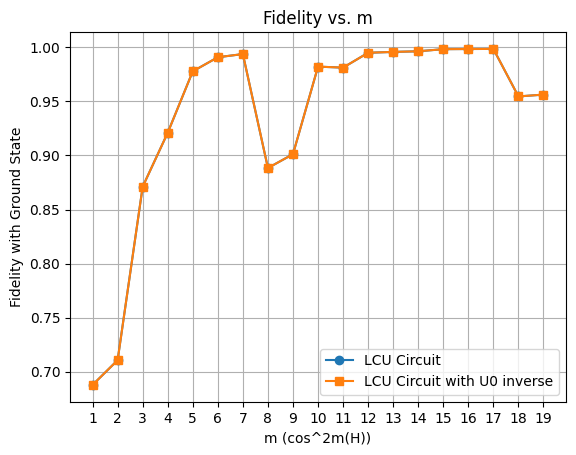

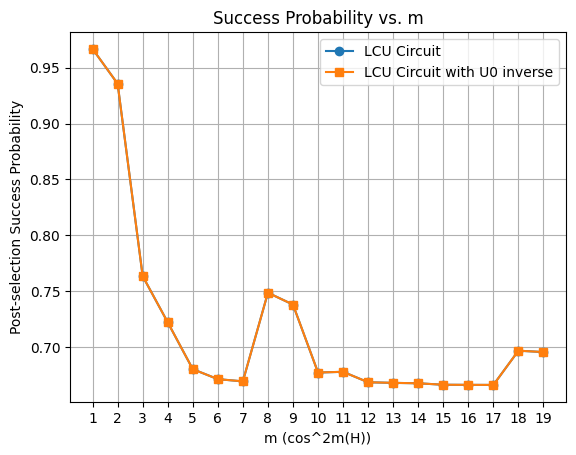

In [3]:
import numpy as np
import itertools
n =  4
dim = 2 ** n

# init_state = np.zeros(dim)
# init_state[int('0101', 2)] = 1.0  # 手动设为 |0101⟩

init_state = np.ones(dim) / np.sqrt(dim)

# init_state = np.zeros(dim)
# init_state[0] = 1

Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
I = np.eye(2)


def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# 构造 TFIM H
H = np.zeros((dim, dim), dtype=np.complex128)
for i in range(n):
    Zi = [I] * n
    Zi[i] = Z
    Zi[(i + 1) % n] = Z
    H -= kron_n(Zi)
    Xi = [I] * n
    Xi[i] = X
    H -= kron_n(Xi)


eigvals, eigvecs = np.linalg.eigh(H)
λ_min, λ_max = np.min(eigvals), np.max(eigvals)
H_norm = (H - λ_min * np.eye(dim)) / (λ_max - λ_min)
λ0 = np.min(np.linalg.eigvalsh(H_norm))
H_shifted = H_norm - λ0 * np.eye(dim)
ground_state = np.linalg.eigh(H_shifted)[1][:, 0]


def fidelity_lcu_circuit(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    dev = qml.device("default.qubit", wires=n + n_anc)
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))

    @qml.qnode(dev)
    def circuit():
        # for i in system_wires:
        #     qml.Hadamard(i)
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.MottonenStatePreparation(weights, wires=ancilla_wires)
        for idx, U in enumerate(U_list):
            bin_str = format(idx, f"0{n_anc}b")
            ctrl_wires = [ancilla_wires[i] for i, b in enumerate(bin_str) if b == '1']
            qml.ControlledQubitUnitary(U, control_wires=ctrl_wires, wires=system_wires)
        qml.adjoint(qml.MottonenStatePreparation)(weights, wires=ancilla_wires)
        return qml.state()

    U_circuit = qml.matrix(circuit, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    A_block = U_circuit[:dim, :dim]
    system_state = A_block@init_state

    # full_state = circuit()
    # reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    # system_state = reshaped[0, :]

    success_prob = np.sum(np.abs(system_state) ** 2)
    normalized_system = system_state / np.linalg.norm(system_state)
    fidelity = np.abs(np.vdot(normalized_system, ground_state)) ** 2
    return fidelity, success_prob

def fidelity_lcu_circuit_U0inverse(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    dev = qml.device("default.qubit", wires=n + n_anc)
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))

    @qml.qnode(dev)
    def circuit():
        # for i in system_wires:
        #     qml.Hadamard(i)
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.MottonenStatePreparation(weights, wires=ancilla_wires)
        for idx, U in enumerate(U_list):
            bin_str = format(idx, f"0{n_anc}b")
            ctrl_wires = [ancilla_wires[i] for i, b in enumerate(bin_str) if b == '1']
            qml.ControlledQubitUnitary(U, control_wires=ctrl_wires, wires=system_wires)
        qml.adjoint(qml.MottonenStatePreparation)(weights, wires=ancilla_wires)
        return qml.state()

    U_circuit = qml.matrix(circuit, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    A_block = U_circuit[:dim, :dim]
    system_state = A_block @np.linalg.inv(U_list[0]) @ init_state

    # full_state = circuit()
    # reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    # system_state = reshaped[0, :]

    success_prob = np.sum(np.abs(system_state) ** 2)
    normalized_system = system_state / np.linalg.norm(system_state)
    fidelity = np.abs(np.vdot(normalized_system, ground_state)) ** 2
    return fidelity, success_prob
def active_U_indices(b, dim):
    """
    给定 ancilla 比特串 b = [b0, b1, ..., b_{n-1}]（从上到下的顺序），
    返回哪些 U_i 会被触发。
    对于 dim = 2^n，i 的二进制形式与 b 做位匹配（只看为1的位）。

    参数：
    - b: list[int]，长度为 n，表示 ancilla 比特（从上到下）
    - dim: int，U_i 总数，通常是 2^n

    返回：
    - indices: list[int]，满足控制条件的 U_i 的编号
    """
    assert len(b) == int(np.log2(dim)), "b 的长度应与 log2(dim) 相匹配"
    indices = []
    for i in range(dim):  # 遍历所有 U_i
        bin_i = format(i, f"0{len(b)}b")  # e.g., "01" or "1101"
        if all(b[j] == 1 if bit == '1' else True for j, bit in enumerate(bin_i)):
            indices.append(i)
    return indices


def compute_weighted_sum(U_list, weights):
    """给定 U_list 和 weights，返回加权和 A = ∑ α_b ⋅ U_total(b)"""
    dim = len(U_list) #size of ancilla
    dim1 = U_list[0].shape[0] # size of system
    #print('[dim is]', dim)
    A = np.zeros((dim1, dim1), dtype=complex)

    for i, b in enumerate(itertools.product([0, 1], repeat=int(np.log2(dim)))):
        indices = active_U_indices(b, dim)
        #print('[indices] is ', indices)
        U_total = np.eye(dim1, dtype=complex)
        for idx in indices:
            U_total = U_list[idx] @ U_total  # 顺序从小到大乘
        A += weights[i] * U_total

    return A

def fidelity_numerical(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    #weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    weights = alpha_padded / np.sum(alpha_padded)
    #print('[Weights]', len(weights))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    dev = qml.device("default.qubit", wires=n + n_anc)
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    #print('[U_Shape]', len(U_list))

    A_result = compute_weighted_sum(U_list, weights)
    #print('[A_Result shape]', A_result.shape)
    final_state = A_result @ init_state
    success_prob = np.sum(np.abs(final_state) ** 2)
    final_state /= np.linalg.norm(final_state)
    fidelity = np.abs(np.vdot(final_state, ground_state)) ** 2
    return fidelity, success_prob

m_vals = list(range(1, 20))
fidelity_A, success_A = zip(*[fidelity_lcu_circuit_U0inverse(m) for m in m_vals])
fidelity_lcu, success_lcu = zip(*[fidelity_lcu_circuit(m) for m in m_vals])
# for i in m_vals:
#     print(np.allclose(fidelity_lcu_circuit(i), fidelity_lcu_circuit_U0inverse(i)))

# 绘图
# 绘图并保存
plt.figure()
plt.plot(m_vals, fidelity_lcu, marker='o', label='LCU Circuit')
plt.plot(m_vals, fidelity_A, marker='s', label='LCU Circuit with U0 inverse')

plt.xlabel("m (cos^2m(H))")
plt.xticks(m_vals)
plt.ylabel("Fidelity with Ground State")
plt.title("Fidelity vs. m")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(m_vals, success_lcu, marker='o', label='LCU Circuit')
plt.plot(m_vals, success_A, marker='s', label='LCU Circuit with U0 inverse')
plt.xlabel("m (cos^2m(H))")
plt.xticks(m_vals)
plt.ylabel("Post-selection Success Probability")
plt.title("Success Probability vs. m")
plt.legend()
plt.grid(True)
plt.show()


In [36]:
normalized_system1 = fidelity_lcu_circuit(1)
print(np.abs(np.vdot(normalized_system1, ground_state)) ** 2)
print(np.sum(np.abs(normalized_system1) ** 2))

0.6650290888674125
0.9668697445220233


In [37]:
normalized_system2 = fidelity_lcu_circuit_U0inverse(1)
print(np.abs(np.vdot(normalized_system2, ground_state)) ** 2)
print(np.sum(np.abs(normalized_system2) ** 2))

0.6650290888674125
0.9668697445220235


In [21]:
qml.math.fidelity(qml.math.dm_from_state_vector(normalized_system1), qml.math.dm_from_state_vector(ground_state))

np.float64(0.687816687057836)

In [22]:
qml.math.fidelity(qml.math.dm_from_state_vector(normalized_system2), qml.math.dm_from_state_vector(ground_state))

np.float64(0.6878166878585705)

In [38]:
qml.math.fidelity(qml.math.dm_from_state_vector(normalized_system2), qml.math.dm_from_state_vector(normalized_system1))

np.float64(0.8366821552868654)

In [23]:
qml.math.dm_from_state_vector(normalized_system1)

array([[0.08999619+0.00000000e+00j, 0.0646139 +3.75338143e-02j,
        0.0646139 +3.75338143e-02j, 0.06657011+3.70503553e-02j,
        0.0646139 +3.75338143e-02j, 0.02803809+4.65731424e-02j,
        0.06657011+3.70503553e-02j, 0.0646139 +3.75338143e-02j,
        0.0646139 +3.75338143e-02j, 0.06657011+3.70503553e-02j,
        0.02803809+4.65731424e-02j, 0.0646139 +3.75338143e-02j,
        0.06657011+3.70503553e-02j, 0.0646139 +3.75338143e-02j,
        0.0646139 +3.75338143e-02j, 0.08999619+0.00000000e+00j],
       [0.0646139 -3.75338143e-02j, 0.06204421+0.00000000e+00j,
        0.06204421+5.20417043e-18j, 0.06324707-1.16296620e-03j,
        0.06204421+6.93889390e-18j, 0.03955409+2.17442077e-02j,
        0.06324707-1.16296620e-03j, 0.06204421+1.21430643e-17j,
        0.06204421+0.00000000e+00j, 0.06324707-1.16296620e-03j,
        0.03955409+2.17442077e-02j, 0.06204421+1.04083409e-17j,
        0.06324707-1.16296620e-03j, 0.06204421+2.94902991e-17j,
        0.06204421+2.42861287e-17j, 0.0

In [24]:
qml.math.dm_from_state_vector(normalized_system2)

array([[0.07081528+0.00000000e+00j, 0.06575097-1.24036558e-02j,
        0.06575097-1.24036558e-02j, 0.06628767-1.21448884e-02j,
        0.06575097-1.24036558e-02j, 0.05571611-1.72418822e-02j,
        0.06628767-1.21448884e-02j, 0.06575097-1.24036558e-02j,
        0.06575097-1.24036558e-02j, 0.06628767-1.21448884e-02j,
        0.05571611-1.72418822e-02j, 0.06575097-1.24036558e-02j,
        0.06628767-1.21448884e-02j, 0.06575097-1.24036558e-02j,
        0.06575097-1.24036558e-02j, 0.07081528+1.73472348e-18j],
       [0.06575097+1.24036558e-02j, 0.06322139+0.00000000e+00j,
        0.06322139-4.33680869e-18j, 0.06367439+3.34268273e-04j,
        0.06322139-1.99493200e-17j, 0.05475161-6.24987961e-03j,
        0.06367439+3.34268273e-04j, 0.06322139-2.16840434e-17j,
        0.06322139-1.30104261e-17j, 0.06367439+3.34268273e-04j,
        0.05475161-6.24987961e-03j, 0.06322139-3.38271078e-17j,
        0.06367439+3.34268273e-04j, 0.06322139-1.21430643e-17j,
        0.06322139-6.07153217e-18j, 0.0

In [25]:
qml.math.dm_from_state_vector(ground_state)

array([[0.33251454+0.j, 0.10193664+0.j, 0.10193664+0.j, 0.07801893+0.j,
        0.10193664+0.j, 0.04419417+0.j, 0.07801893+0.j, 0.10193664+0.j,
        0.10193664+0.j, 0.07801893+0.j, 0.04419417+0.j, 0.10193664+0.j,
        0.07801893+0.j, 0.10193664+0.j, 0.10193664+0.j, 0.33251454+0.j],
       [0.10193664+0.j, 0.03125   +0.j, 0.03125   +0.j, 0.02391771+0.j,
        0.03125   +0.j, 0.0135483 +0.j, 0.02391771+0.j, 0.03125   +0.j,
        0.03125   +0.j, 0.02391771+0.j, 0.0135483 +0.j, 0.03125   +0.j,
        0.02391771+0.j, 0.03125   +0.j, 0.03125   +0.j, 0.10193664+0.j],
       [0.10193664+0.j, 0.03125   +0.j, 0.03125   +0.j, 0.02391771+0.j,
        0.03125   +0.j, 0.0135483 +0.j, 0.02391771+0.j, 0.03125   +0.j,
        0.03125   +0.j, 0.02391771+0.j, 0.0135483 +0.j, 0.03125   +0.j,
        0.02391771+0.j, 0.03125   +0.j, 0.03125   +0.j, 0.10193664+0.j],
       [0.07801893+0.j, 0.02391771+0.j, 0.02391771+0.j, 0.01830583+0.j,
        0.02391771+0.j, 0.01036942+0.j, 0.01830583+0.j, 0.023

In [4]:
for i, b in enumerate(itertools.product([0, 1], repeat=2)):
    print('[i is]', i)
    print('[b is]', b)
    indices = active_U_indices(b, 4)
    print('[indices] is ', indices)

[i is] 0
[b is] (0, 0)
[indices] is  [0]
[i is] 1
[b is] (0, 1)
[indices] is  [0, 1]
[i is] 2
[b is] (1, 0)
[indices] is  [0, 2]
[i is] 3
[b is] (1, 1)
[indices] is  [0, 1, 2, 3]


In [51]:
b = (1,1)
format(i, f"0{len(b)}b")

'11'

In [1]:
1/16

0.0625

### OAA example

In [5]:
import numpy as np
import pennylane as qml

a = 0.25
b = 0.75

# matrix to be decomposed
A = np.array(
    [[a,  0, 0,  b],
     [0, -a, b,  0],
     [0,  b, a,  0],
     [b,  0, 0, -a]]
)

LCU = qml.pauli_decompose(A)
LCU_coeffs, LCU_ops = LCU.terms()

print(f"LCU decomposition:\n {LCU}")
print(f"Coefficients:\n {LCU_coeffs}")
print(f"Unitaries:\n {LCU_ops}")


dev2 = qml.device("default.qubit", wires=3)
alphas = (np.sqrt(LCU_coeffs) / np.linalg.norm(np.sqrt(LCU_coeffs)))
# unitaries
ops = LCU_ops
# relabeling wires: 0 → 1, and 1 → 2
unitaries = [qml.map_wires(op, {0: 1, 1: 2}) for op in ops]


@qml.qnode(dev2)
def lcu_circuit():  # block_encode
    # PREP
    qml.StatePrep(alphas, wires=0)

    # SEL
    qml.Select(unitaries, control=0)

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires=0))
    return qml.state()


output_matrix = qml.matrix(lcu_circuit)()
print("A:\n", A, "\n")
print("Block-encoded A:\n")
print(np.real(np.round(output_matrix,2)))

LCU decomposition:
 0.25 * (I(0) @ Z(1)) + 0.75 * (X(0) @ X(1))
Coefficients:
 [0.25 0.75]
Unitaries:
 [I(0) @ Z(1), X(0) @ X(1)]
A:
 [[ 0.25  0.    0.    0.75]
 [ 0.   -0.25  0.75  0.  ]
 [ 0.    0.75  0.25  0.  ]
 [ 0.75  0.    0.   -0.25]] 

Block-encoded A:

[[ 0.25  0.    0.    0.75 -0.43  0.    0.    0.43]
 [ 0.   -0.25  0.75  0.    0.    0.43  0.43  0.  ]
 [ 0.    0.75  0.25  0.    0.    0.43 -0.43  0.  ]
 [ 0.75  0.    0.   -0.25  0.43  0.    0.    0.43]
 [-0.43  0.    0.    0.43  0.75  0.    0.    0.25]
 [ 0.    0.43  0.43  0.    0.   -0.75  0.25  0.  ]
 [ 0.    0.43 -0.43  0.    0.    0.25  0.75  0.  ]
 [ 0.43  0.    0.    0.43  0.25  0.    0.   -0.75]]


In [11]:
import numpy as np
from scipy.linalg import expm
import pennylane as qml

# === 定义 Pauli 运算符矩阵 ===
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(4)

# === 构造 A = 1/4 (ZZ + ZX + XZ + XX) ===
P_terms = [np.kron(Z, Z), np.kron(Z, X), np.kron(X, Z), np.kron(X, X)]
A = sum(P_terms) / 4

# === 准备 LCU 系数和单项酉矩阵 ===
coeffs = np.array([1/4, 1/4, 1/4, 1/4])
weights = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))  # 4 维 → 2 ancilla qubits

# U_list = 4 项酉矩阵（即 A 的每项）
U_list = P_terms
U_ops = [qml.QubitUnitary(U, wires=[2,3]) for U in U_list]
dev = qml.device("default.qubit", wires=4)  # [0,1: ancilla], [2,3: system]
@qml.qnode(dev)
def W_circuit():

    qml.MottonenStatePreparation(weights, wires=[0, 1])
    for idx, U in enumerate(U_list):
        bin_str = format(idx, "02b")
        ctrl_wires = [0 if bin_str[0] == '1' else None, 1 if bin_str[1] == '1' else None]
        ctrl_wires = [w for w in ctrl_wires if w is not None]
        qml.ControlledQubitUnitary(U, control_wires=ctrl_wires, wires=[2, 3])

    qml.adjoint(qml.MottonenStatePreparation)(weights, wires=[0, 1])

    return qml.state()

@qml.qnode(dev)
def W_circuit_control():
    qml.MottonenStatePreparation(weights, wires=[0, 1])
    # SELECT using controlled unitary
    for idx, U in enumerate(U_list):
        bin_str = format(idx, "02b")
        ctrl_values = [int(b) for b in bin_str]
        qml.ControlledQubitUnitary(
                U,
                control_wires=[0,1],
                control_values=ctrl_values,
                wires=[2,3]
            )
    qml.adjoint(qml.MottonenStatePreparation)(weights, wires=[0, 1])
    return qml.state()

@qml.qnode(dev)
def W_circuit_select():
    qml.StatePrep(weights, wires=[0,1])
    qml.Select(U_ops, control=[0,1])
    qml.adjoint(qml.StatePrep)(weights, wires=[0,1])
    return qml.state()




In [12]:
W_circuit_select()

array([ 0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j,
       -0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,  0.25+0.j,
        0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j])

In [13]:
W_circuit().reshape(4,4)

array([[-1.38777878e-16+0.j,  2.50000000e-01+0.j,  2.50000000e-01+0.j,
         0.00000000e+00+0.j],
       [-5.00000000e-01+0.j,  2.50000000e-01+0.j, -2.50000000e-01+0.j,
         0.00000000e+00+0.j],
       [-5.00000000e-01+0.j, -2.50000000e-01+0.j,  2.50000000e-01+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j, -2.50000000e-01+0.j, -2.50000000e-01+0.j,
         0.00000000e+00+0.j]])

In [14]:
W_circuit_control()

array([ 0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j,
       -0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,  0.25+0.j,
        0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j])

(<Figure size 800x500 with 1 Axes>, <Axes: >)


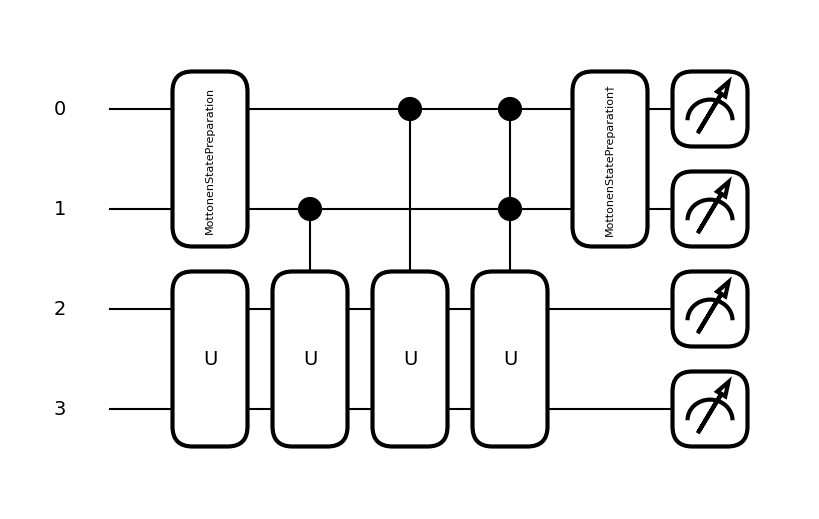

In [3]:
circuit_diagram = qml.draw_mpl(W_circuit)
print(circuit_diagram())

(<Figure size 900x500 with 1 Axes>, <Axes: >)


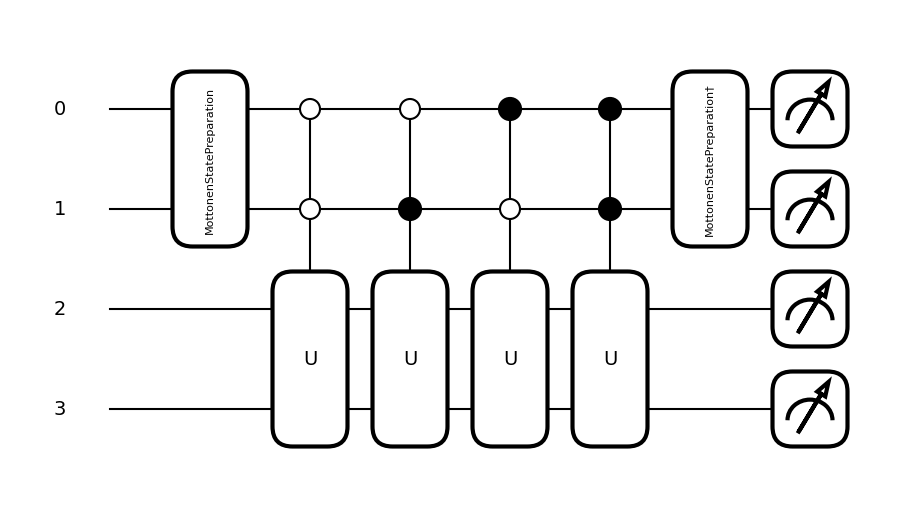

In [4]:
circuit_diagram = qml.draw_mpl(W_circuit_control)
print(circuit_diagram())

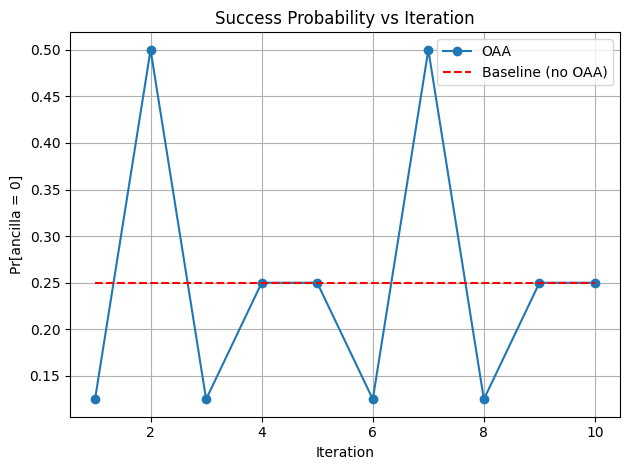

In [23]:
# === Prepare |00>_anc ⊗ |++>_sys ===
def prepare_initial_state():
    psi_sys = np.array([1, 1, 1, 1]) / 2
    psi_anc = np.array([1, 0, 0, 0])
    return np.kron(psi_anc, psi_sys)

# === Reflection operator: R = I - 2|0⟩⟨0|_anc ⊗ I_sys ===
def construct_reflection_operator():
    I_sys = np.eye(4)
    P0_anc = np.array([[1, 0, 0, 0], [0, 0, 0, 0],
                       [0, 0, 0, 0], [0, 0, 0, 0],])
    R = np.kron(np.eye(4) - 2 * P0_anc, I_sys)
    return R

# === Run OAA iterations and record success probabilities ===
def simulate_oaa_success_only(W, W_dagger, R, psi0, max_iter):
    success_probs = []
    psi = psi0.copy()
    for _ in range(max_iter):
        psi = R @ psi
        psi = W_dagger @ psi
        psi = R @ psi
        psi = W @ psi
        reshaped = psi.reshape((4, 4))  # [ancilla, system]
        system_unnorm = reshaped[0, :]  # ancilla = 0
        success_prob = np.sum(np.abs(system_unnorm)**2)
        success_probs.append(success_prob)
    return success_probs

# === Main ===
W = qml.matrix(W_circuit, wire_order=[0,1,2,3])()  # ancilla first
W_dagger = W.conj().T
R = construct_reflection_operator()

psi_init = prepare_initial_state()
psi0 = W @ psi_init  # initial state = W |0>_anc ⊗ |+>_sys

# Baseline success probability (before OAA)
reshaped = psi0.reshape((4, 4))  # [ancilla, system]
system_unnorm = reshaped[0, :]
baseline = np.sum(np.abs(system_unnorm)**2)

# OAA
success_probs = simulate_oaa_success_only(W, W_dagger, R, psi0.copy(), max_iter=10)

# === Plot ===
plt.figure()
plt.plot(range(1, 11), success_probs, marker='o', label='OAA')
plt.hlines(baseline, 1, 10, colors='r', linestyles='--', label='Baseline (no OAA)')
plt.title("Success Probability vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Pr[ancilla = 0]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

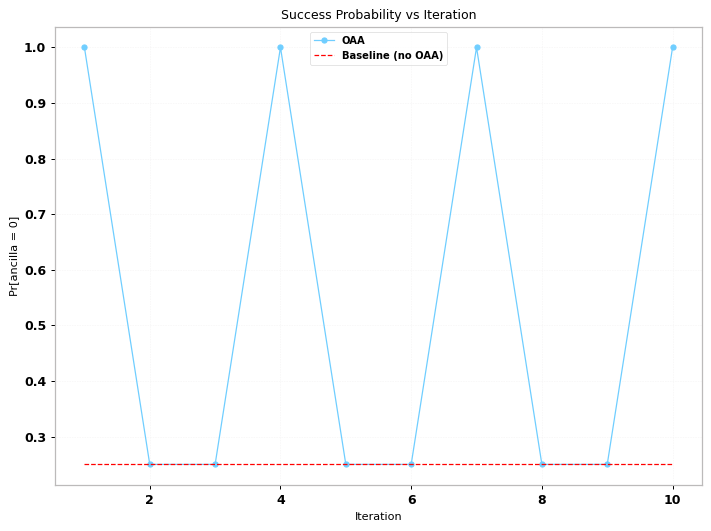

In [74]:
import numpy as np
from scipy.linalg import expm
import pennylane as qml

# === 定义 Pauli 运算符矩阵 ===
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(4)

# === 构造 A = 1/4 (ZZ + ZX + XZ + XX) ===
P_terms = [np.kron(Z, Z), np.kron(Z, X), np.kron(X, Z), np.kron(X, X)]
A = sum(P_terms) / 4

# === 准备 LCU 系数和单项酉矩阵 ===
coeffs = np.array([1/4, 1/4, 1/4, 1/4])
weights = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))  # 4 维 → 2 ancilla qubits

# U_list = 4 项酉矩阵（即 A 的每项）
U_list = P_terms
U_ops = [qml.QubitUnitary(U, wires=[2,3]) for U in U_list]

# === Prepare |00>_anc ⊗ |++>_sys ===
def prepare_initial_state():
    psi_sys = np.array([1, 1, 1, 1]) / 2
    psi_anc = np.array([1, 0, 0, 0])
    return np.kron(psi_anc, psi_sys)

# === Reflection operator: R = I - 2|0⟩⟨0|_anc ⊗ I_sys ===
def construct_reflection_operator():
    I_sys = np.eye(4)
    P0_anc = np.array([[1, 0, 0, 0], [0, 0, 0, 0],
                       [0, 0, 0, 0], [0, 0, 0, 0],])
    R = -np.kron(np.eye(4) - 2 * P0_anc, I_sys)
    return R

# === Run OAA iterations and record success probabilities ===
def simulate_oaa_success_only(W, W_dagger, R, psi0, max_iter):
    success_probs = []
    psi = psi0.copy()
    for _ in range(max_iter):
        psi = R @ psi
        psi = W_dagger @ psi
        psi = R @ psi
        psi = W @ psi
        reshaped = psi.reshape((4, 4))  # [ancilla, system]
        system_unnorm = reshaped[0, :]  # ancilla = 0
        success_prob = np.sum(np.abs(system_unnorm)**2)
        success_probs.append(success_prob)
    return success_probs

@qml.qnode(dev)
def W_circuit_select():
    qml.StatePrep(weights, wires=[0,1])
    qml.Select(U_ops, control=[0,1])
    qml.adjoint(qml.StatePrep)(weights, wires=[0,1])
    return qml.state()
# === Main ===
W = qml.matrix(W_circuit_select, wire_order=[0,1,2,3])()  # ancilla first
W_dagger = W.conj().T
R = construct_reflection_operator()

psi_init = prepare_initial_state()
psi0 = W @ psi_init  # initial state = W |0>_anc ⊗ |+>_sys

# Baseline success probability (before OAA)
reshaped = psi0.reshape((4, 4))  # [ancilla, system]
system_unnorm = reshaped[0, :]
baseline = np.sum(np.abs(system_unnorm)**2)

# OAA
success_probs = simulate_oaa_success_only(W, W_dagger, R, psi0.copy(), max_iter=10)

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 6), dpi=90)

ax.plot(range(1, 11), success_probs, marker='o', markersize=4, linewidth=1,
        label='OAA')
ax.hlines(baseline, 1, 10, colors='r', linestyles='--', linewidth=1,
          label='Baseline (no OAA)')

ax.set_title("Success Probability vs Iteration", fontsize=10)
ax.set_xlabel("Iteration", fontsize=9)
ax.set_ylabel("Pr[ancilla = 0]", fontsize=9)

ax.grid(True, linewidth=0.5)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()


[psi is] [ 1.00000000e+00+0.j  1.80411242e-16+0.j  1.66533454e-16+0.j
  0.00000000e+00+0.j -5.55111512e-17+0.j  0.00000000e+00+0.j
  6.93889390e-18+0.j -6.93889390e-18+0.j -6.93889390e-18+0.j
  1.38777878e-17+0.j -4.16333634e-17+0.j -6.16297582e-33+0.j
 -6.93889390e-18+0.j -4.85722573e-17+0.j -1.38777878e-17+0.j
  6.24500451e-17+0.j]
[psi is] [ 5.00000000e-01+0.j  1.38777878e-16+0.j  1.17961196e-16+0.j
  2.08166817e-17+0.j  0.00000000e+00+0.j -5.00000000e-01+0.j
  1.38777878e-17+0.j -4.85722573e-17+0.j -6.93889390e-18+0.j
 -6.93889390e-18+0.j -5.00000000e-01+0.j -1.66533454e-16+0.j
 -3.46944695e-17+0.j  4.85722573e-17+0.j  0.00000000e+00+0.j
 -5.00000000e-01+0.j]
[psi is] [-5.00000000e-01+0.j -5.55111512e-17+0.j -6.24500451e-17+0.j
 -6.93889390e-18+0.j  0.00000000e+00+0.j -5.00000000e-01+0.j
  6.93889390e-18+0.j -1.31838984e-16+0.j  6.93889390e-18+0.j
  6.93889390e-18+0.j -5.00000000e-01+0.j -5.55111512e-17+0.j
  3.46944695e-17+0.j -2.08166817e-17+0.j  5.55111512e-17+0.j
 -5.00000000e-

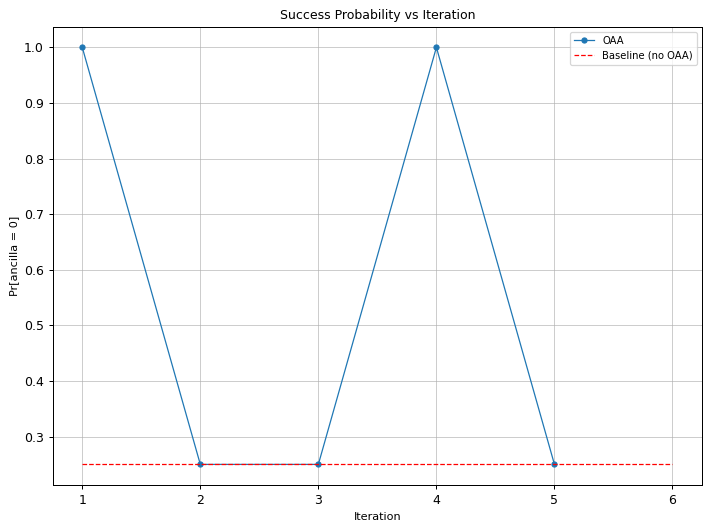

In [104]:
import numpy as np
from scipy.linalg import expm
import pennylane as qml

# === 定义 Pauli 运算符矩阵 ===
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(4)

# === 构造 A = 1/4 (ZZ + ZX + XZ + XX) ===
P_terms = [np.kron(Z, Z), np.kron(Z, X), np.kron(X, Z), np.kron(X, X)]
A = sum(P_terms) / 4

# === 准备 LCU 系数和单项酉矩阵 ===
coeffs = np.array([1/4, 1/4, 1/4, 1/4])
weights = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))  # 4 维 → 2 ancilla qubits

# U_list = 4 项酉矩阵（即 A 的每项）
U_list = P_terms
U_ops = [qml.QubitUnitary(U, wires=[2,3]) for U in U_list]

# === Prepare |00>_anc ⊗ |++>_sys ===
def prepare_initial_state():
    psi_sys = np.array([1, 1, 1, 1]) / 2
    #psi_sys = np.array([1, 0, 0, 0])
    psi_anc = np.array([1, 0, 0, 0])
    return np.kron(psi_anc, psi_sys)

# === Reflection operator: R = (2|0⟩⟨0| ⊗ I_sys）-I ===
def construct_reflection_operator():
    I_sys = np.eye(4)
    P0_anc = np.array([[1, 0, 0, 0], [0, 0, 0, 0],
                       [0, 0, 0, 0], [0, 0, 0, 0],])
    R = 2*np.kron(P0_anc, I_sys) - np.eye(16)
    return R

# === Run OAA iterations and record success probabilities ===
def simulate_oaa_success_only(W, W_dagger, R, psi0, max_iter):
    success_probs = []
    psi = psi0.copy()
    for _ in range(max_iter):
        psi = R @ psi
        psi = W_dagger @ psi
        psi = R @ psi
        psi = -W @ psi
        #print('[psi size is]', psi.shape)
        print('[psi is]', psi)
        reshaped = psi.reshape((4, 4))  # [ancilla, system]
        system_unnorm = reshaped[0, :]  # ancilla = 0
        success_prob = np.sum(np.abs(system_unnorm)**2)
        success_probs.append(success_prob)

    return success_probs

dev = qml.device("default.qubit")
@qml.qnode(dev)
def W_circuit_select():
    qml.StatePrep(weights, wires=[0,1])
    qml.Select(U_ops, control=[0,1])
    qml.adjoint(qml.StatePrep)(weights, wires=[0,1])
    return qml.state()
# === Main ===
W = qml.matrix(W_circuit_select, wire_order=[0,1,2,3])()  # ancilla first
W_dagger = W.conj().T
R = construct_reflection_operator()

psi_init = prepare_initial_state()
psi0 = W @ psi_init  # initial state = W |0>_anc ⊗ |+>_sys

# Baseline success probability (before OAA)
reshaped = psi0.reshape((4, 4))  # [ancilla, system]
system_unnorm = reshaped[0, :]
baseline = np.sum(np.abs(system_unnorm)**2)

# OAA
success_probs = simulate_oaa_success_only(W, W_dagger, R, psi0.copy(), max_iter=5)

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 6), dpi=90)

ax.plot(range(1, 6), success_probs, marker='o', markersize=4, linewidth=1,
        label='OAA')
ax.hlines(baseline, 1, 6, colors='r', linestyles='--', linewidth=1,
          label='Baseline (no OAA)')

ax.set_title("Success Probability vs Iteration", fontsize=10)
ax.set_xlabel("Iteration", fontsize=9)
ax.set_ylabel("Pr[ancilla = 0]", fontsize=9)

ax.grid(True, linewidth=0.5)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()


[psi is] [ 1.00000000e+00+0.j  1.80411242e-16+0.j  1.66533454e-16+0.j
  0.00000000e+00+0.j -5.55111512e-17+0.j  0.00000000e+00+0.j
  6.93889390e-18+0.j -6.93889390e-18+0.j -6.93889390e-18+0.j
  1.38777878e-17+0.j -4.16333634e-17+0.j -6.16297582e-33+0.j
 -6.93889390e-18+0.j -4.85722573e-17+0.j -1.38777878e-17+0.j
  6.24500451e-17+0.j]
[psi is] [ 5.00000000e-01+0.j  1.38777878e-16+0.j  1.17961196e-16+0.j
  2.08166817e-17+0.j  0.00000000e+00+0.j -5.00000000e-01+0.j
  1.38777878e-17+0.j -4.85722573e-17+0.j -6.93889390e-18+0.j
 -6.93889390e-18+0.j -5.00000000e-01+0.j -1.66533454e-16+0.j
 -3.46944695e-17+0.j  4.85722573e-17+0.j  0.00000000e+00+0.j
 -5.00000000e-01+0.j]
[psi is] [-5.00000000e-01+0.j -5.55111512e-17+0.j -6.24500451e-17+0.j
 -6.93889390e-18+0.j  0.00000000e+00+0.j -5.00000000e-01+0.j
  6.93889390e-18+0.j -1.31838984e-16+0.j  6.93889390e-18+0.j
  6.93889390e-18+0.j -5.00000000e-01+0.j -5.55111512e-17+0.j
  3.46944695e-17+0.j -2.08166817e-17+0.j  5.55111512e-17+0.j
 -5.00000000e-

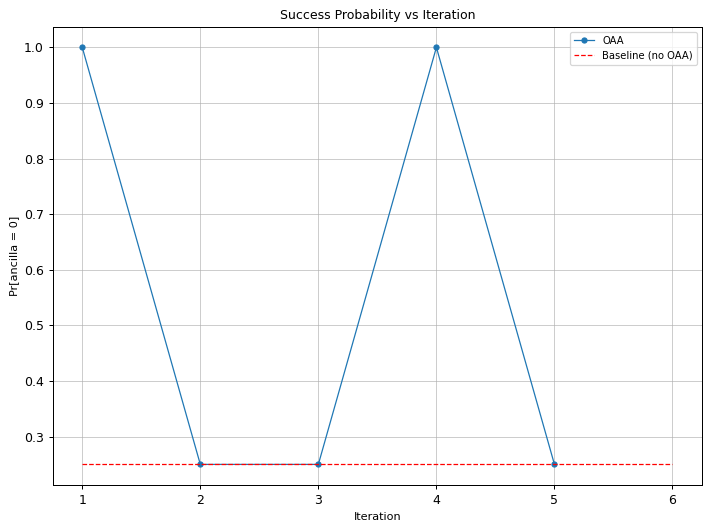

In [116]:
import numpy as np
from scipy.linalg import expm
import pennylane as qml

# === 定义 Pauli 运算符矩阵 ===
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(4)

# === 构造 A = 1/2 (ZZ + ZX + XZ + XX) ===
P_terms = [np.kron(Z, Z), np.kron(Z, X), np.kron(X, Z), np.kron(X, X)]
A = sum(P_terms) / 2

# === 准备 LCU 系数和单项酉矩阵 ===
coeffs = np.array([1/2, 1/2, 1/2, 1/2])
weights = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))  # 4 维 → 2 ancilla qubits

# U_list = 4 项酉矩阵（即 A 的每项）
U_list = P_terms
U_ops = [qml.QubitUnitary(U, wires=[2,3]) for U in U_list]

# === Prepare |00>_anc ⊗ |++>_sys ===
def prepare_initial_state():
    psi_sys = np.array([1, 1, 1, 1]) / 2
    #psi_sys = np.array([1, 0, 0, 0])
    psi_anc = np.array([1, 0, 0, 0])
    return np.kron(psi_anc, psi_sys)

# === Reflection operator: R = (2|0⟩⟨0| ⊗ I_sys）-I ===
def construct_reflection_operator():
    I_sys = np.eye(4)
    P0_anc = np.array([[1, 0, 0, 0], [0, 0, 0, 0],
                       [0, 0, 0, 0], [0, 0, 0, 0],])
    R = 2*np.kron(P0_anc, I_sys) - np.eye(16)
    return R

# === Run OAA iterations and record success probabilities ===
def simulate_oaa_success_only(W, W_dagger, R, psi0, max_iter):
    success_probs = []
    psi = psi0.copy()
    for _ in range(max_iter):
        psi = R @ psi
        psi = W_dagger @ psi
        psi = R @ psi
        psi = -W @ psi
        #print('[psi size is]', psi.shape)
        print('[psi is]', psi)
        reshaped = psi.reshape((4, 4))  # [ancilla, system]
        system_unnorm = reshaped[0, :]  # ancilla = 0
        success_prob = np.sum(np.abs(system_unnorm)**2)
        success_probs.append(success_prob)

    return success_probs

dev = qml.device("default.qubit")
@qml.qnode(dev)
def W_circuit_select():
    qml.StatePrep(weights, wires=[0,1])
    qml.Select(U_ops, control=[0,1])
    qml.adjoint(qml.StatePrep)(weights, wires=[0,1])
    return qml.state()
# === Main ===
W = qml.matrix(W_circuit_select, wire_order=[0,1,2,3])()  # ancilla first
W_dagger = W.conj().T
R = construct_reflection_operator()

psi_init = prepare_initial_state()
psi0 = W @ psi_init  # initial state = W |0>_anc ⊗ |+>_sys

# Baseline success probability (before OAA)
reshaped = psi0.reshape((4, 4))  # [ancilla, system]
system_unnorm = reshaped[0, :]
baseline = np.sum(np.abs(system_unnorm)**2)

# OAA
success_probs = simulate_oaa_success_only(W, W_dagger, R, psi0.copy(), max_iter=5)

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 6), dpi=90)

ax.plot(range(1, 6), success_probs, marker='o', markersize=4, linewidth=1,
        label='OAA')
ax.hlines(baseline, 1, 6, colors='r', linestyles='--', linewidth=1,
          label='Baseline (no OAA)')

ax.set_title("Success Probability vs Iteration", fontsize=10)
ax.set_xlabel("Iteration", fontsize=9)
ax.set_ylabel("Pr[ancilla = 0]", fontsize=9)

ax.grid(True, linewidth=0.5)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()


In [117]:
A

array([[ 0.5,  0.5,  0.5,  0.5],
       [ 0.5, -0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5, -0.5],
       [ 0.5, -0.5, -0.5,  0.5]])

In [118]:
A.dot(A.conj().T)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [94]:
W[:4, :4]


array([[ 0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j],
       [ 0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j],
       [ 0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j],
       [ 0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j]])

In [102]:
A

array([[ 0.25,  0.25,  0.25,  0.25],
       [ 0.25, -0.25,  0.25, -0.25],
       [ 0.25,  0.25, -0.25, -0.25],
       [ 0.25, -0.25, -0.25,  0.25]])

In [103]:
A.conj().T.dot(A)

array([[0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.25]])

In [101]:
A_prime = 3*A - 4*(A.dot(A.conj().T)).dot(A)
A_prime.dot(np.array([1, 1, 1, 1]) / 2)

array([1., 0., 0., 0.])

In [98]:
pm = np.linalg.norm(A.dot(np.array([1, 1, 1, 1]) / 2))**2
print(pm)

0.25


In [78]:
np.linalg.norm(A.dot(np.array([1, 0, 0, 0])))**2

np.float64(0.25)

In [67]:
psi0

array([ 5.00000000e-01+0.j,  5.55111512e-17+0.j,  6.93889390e-17+0.j,
       -1.38777878e-17+0.j,  0.00000000e+00+0.j,  5.00000000e-01+0.j,
        0.00000000e+00+0.j,  1.11022302e-16+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  5.00000000e-01+0.j,  1.11022302e-16+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        5.00000000e-01+0.j])

In [25]:
P_terms = [np.kron(Z, Z), np.kron(Z, X), np.kron(X, Z), np.kron(X, X)]
A = sum(P_terms)/4


array([[ 0.25,  0.25,  0.25,  0.25],
       [ 0.25, -0.25,  0.25, -0.25],
       [ 0.25,  0.25, -0.25, -0.25],
       [ 0.25, -0.25, -0.25,  0.25]])

In [19]:
weights

array([0.5, 0.5, 0.5, 0.5])

In [13]:
np.linalg.norm(np.sqrt(coeffs))

np.float64(1.0)

[psi is] [-7.07106781e-01+0.j -1.11022302e-16+0.j  0.00000000e+00+0.j
 -7.07106781e-01+0.j]


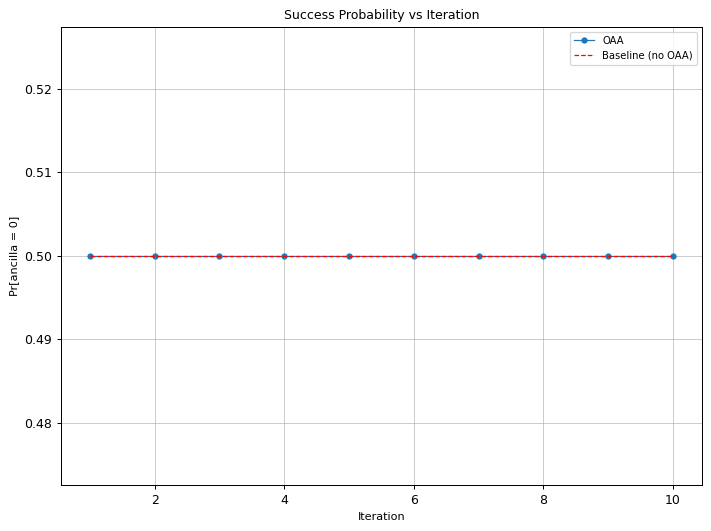

In [105]:
import numpy as np
from scipy.linalg import expm
import pennylane as qml

# === 定义 Pauli 运算符矩阵 ===
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

# === 构造 A = 1/2 (Z + X) ===
P_terms = [Z, X]
A = sum(P_terms) / 2

# === 准备 LCU 系数和单项酉矩阵 ===
coeffs = np.array([1/2, 1/2])
weights = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))  # 4 维 → 2 ancilla qubits

# U_list = 2 项酉矩阵（即 A 的每项）
U_list = P_terms
U_ops = [qml.QubitUnitary(U, wires=[1]) for U in U_list]

# === Prepare |0>_anc ⊗ |+>_sys ===
def prepare_initial_state():
    psi_sys = np.array([1, 1]) / np.sqrt(2)
    psi_anc = np.array([1, 0])
    return np.kron(psi_anc, psi_sys)

# === Reflection operator: R = (2|0⟩⟨0| ⊗ I_sys）-I ===
def construct_reflection_operator():
    I_sys = np.eye(2)
    P0_anc = np.array([[1, 0], [0, 0]])
    R = 2*np.kron(P0_anc, I_sys) - np.eye(4)
    return R

# === Run OAA iterations and record success probabilities ===
def simulate_oaa_success_only(W, W_dagger, R, psi0, max_iter):
    success_probs = []
    psi = psi0.copy()
    for _ in range(max_iter):
        psi = R @ psi
        psi = W_dagger @ psi
        psi = R @ psi
        psi = -W @ psi
        reshaped = psi.reshape((2, 2))  # [ancilla, system]
        system_unnorm = reshaped[0, :]  # ancilla = 0
        success_prob = np.sum(np.abs(system_unnorm)**2)
        success_probs.append(success_prob)
    print('[psi is]', psi)
    return success_probs

dev = qml.device("default.qubit")
@qml.qnode(dev)
def W_circuit_select():
    qml.StatePrep(weights, wires=[0])
    qml.Select(U_ops, control=[0])
    qml.adjoint(qml.StatePrep)(weights, wires=[0])
    return qml.state()
# === Main ===
W = qml.matrix(W_circuit_select, wire_order=[0,1])()  # ancilla first
W_dagger = W.conj().T
R = construct_reflection_operator()

psi_init = prepare_initial_state()
psi0 = W @ psi_init  # initial state = W |0>_anc ⊗ |+>_sys

# Baseline success probability (before OAA)
reshaped = psi0.reshape((2, 2))  # [ancilla, system]
system_unnorm = reshaped[0, :]
baseline = np.sum(np.abs(system_unnorm)**2)

# OAA
success_probs = simulate_oaa_success_only(W, W_dagger, R, psi0.copy(), max_iter=10)

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 6), dpi=90)

ax.plot(range(1, 11), success_probs, marker='o', markersize=4, linewidth=1,
        label='OAA')
ax.hlines(baseline, 1, 10, colors='r', linestyles='--', linewidth=1,
          label='Baseline (no OAA)')

ax.set_title("Success Probability vs Iteration", fontsize=10)
ax.set_xlabel("Iteration", fontsize=9)
ax.set_ylabel("Pr[ancilla = 0]", fontsize=9)

ax.grid(True, linewidth=0.5)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()


In [54]:
psi_init

array([0.70710678, 0.70710678, 0.        , 0.        ])

In [57]:
psi_init.reshape(2,2)[0,:]

array([0.70710678, 0.70710678])

In [80]:
W[:2,:2]

array([[ 0.5+0.j,  0.5+0.j],
       [ 0.5+0.j, -0.5+0.j]])

In [106]:
A

array([[ 0.5,  0.5],
       [ 0.5, -0.5]])

In [107]:
A.dot(np.array([1, 1]) / np.sqrt(2))

array([0.70710678, 0.        ])

In [83]:
a = np.array([-1/np.sqrt(2), 0, 0, -1/np.sqrt(2)])
np.linalg.norm(a)

np.float64(0.9999999999999999)

In [88]:
b = a.reshape((2, 2))  # [ancilla, system]
c =b[0, :]  # ancilla = 0
np.sum(np.abs(c)**2)/pm

np.float64(1.0)

In [87]:
pm = np.linalg.norm(A.dot(np.array([1, 1]) / np.sqrt(2)))**2

In [60]:
a = A.dot(np.array([1, 1]) / np.sqrt(2))
np.sum(a.dot(a.conj().T))

np.float64(0.4999999999999999)

In [27]:
U = 1/2*(Z+X).dot(np.array([1,1])/2)
U

array([0.5, 0. ])

In [28]:
weights

array([0.70710678, 0.70710678])

In [29]:
1/np.sqrt(2)

np.float64(0.7071067811865475)

In [31]:
np.linalg.norm(np.sqrt(coeffs))

np.float64(1.0)

[psi is] [ 7.07106781e-01+0.j  1.11022302e-16+0.j  0.00000000e+00+0.j
 -7.07106781e-01+0.j]
[psi is] [-7.07106781e-01+0.j -1.11022302e-16+0.j  0.00000000e+00+0.j
 -7.07106781e-01+0.j]
[psi is] [-7.07106781e-01+0.j -1.11022302e-16+0.j  0.00000000e+00+0.j
  7.07106781e-01+0.j]
[psi is] [7.07106781e-01+0.j 1.11022302e-16+0.j 0.00000000e+00+0.j
 7.07106781e-01+0.j]
[psi is] [ 7.07106781e-01+0.j  1.11022302e-16+0.j  0.00000000e+00+0.j
 -7.07106781e-01+0.j]
[psi is] [-7.07106781e-01+0.j -1.11022302e-16+0.j  0.00000000e+00+0.j
 -7.07106781e-01+0.j]
[psi is] [-7.07106781e-01+0.j -1.11022302e-16+0.j  0.00000000e+00+0.j
  7.07106781e-01+0.j]
[psi is] [7.07106781e-01+0.j 1.11022302e-16+0.j 0.00000000e+00+0.j
 7.07106781e-01+0.j]
[psi is] [ 7.07106781e-01+0.j  1.11022302e-16+0.j  0.00000000e+00+0.j
 -7.07106781e-01+0.j]
[psi is] [-7.07106781e-01+0.j -1.11022302e-16+0.j  0.00000000e+00+0.j
 -7.07106781e-01+0.j]


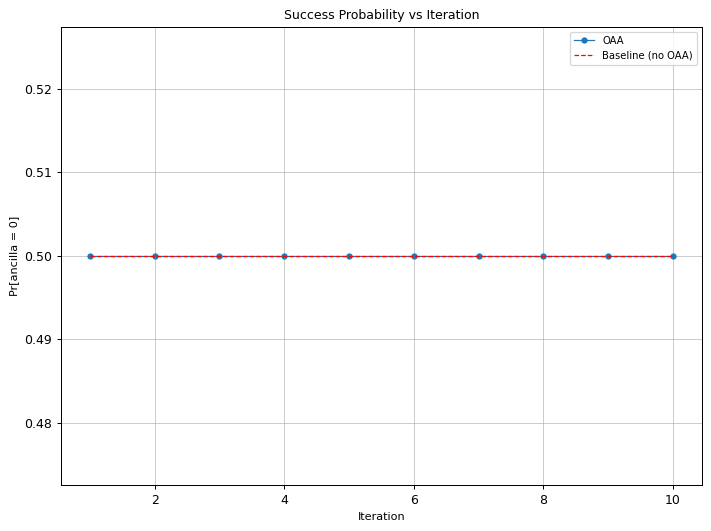

In [109]:
import numpy as np
from scipy.linalg import expm
import pennylane as qml

# === 定义 Pauli 运算符矩阵 ===
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

# === 构造 A =  (Z + X) ===
P_terms = [Z, X]
A = sum(P_terms)

# === 准备 LCU 系数和单项酉矩阵 ===
coeffs = np.array([1, 1])
weights = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))  # 4 维 → 2 ancilla qubits

# U_list = 2 项酉矩阵（即 A 的每项）
U_list = P_terms
U_ops = [qml.QubitUnitary(U, wires=[1]) for U in U_list]

# === Prepare |0>_anc ⊗ |+>_sys ===
def prepare_initial_state():
    psi_sys = np.array([1, 1]) / np.sqrt(2)
    psi_anc = np.array([1, 0])
    return np.kron(psi_anc, psi_sys)

# === Reflection operator: R = (2|0⟩⟨0| ⊗ I_sys）-I ===
def construct_reflection_operator():
    I_sys = np.eye(2)
    P0_anc = np.array([[1, 0], [0, 0]])
    R = 2*np.kron(P0_anc, I_sys) - np.eye(4)
    return R

# === Run OAA iterations and record success probabilities ===
def simulate_oaa_success_only(W, W_dagger, R, psi0, max_iter):
    success_probs = []
    psi = psi0.copy()
    for _ in range(max_iter):
        psi = R @ psi
        psi = W_dagger @ psi
        psi = R @ psi
        psi = -W @ psi
        reshaped = psi.reshape((2, 2))  # [ancilla, system]
        system_unnorm = reshaped[0, :]  # ancilla = 0
        success_prob = np.sum(np.abs(system_unnorm)**2)
        success_probs.append(success_prob)
        print('[psi is]', psi)
    return success_probs

dev = qml.device("default.qubit")
@qml.qnode(dev)
def W_circuit_select():
    qml.StatePrep(weights, wires=[0])
    qml.Select(U_ops, control=[0])
    qml.adjoint(qml.StatePrep)(weights, wires=[0])
    return qml.state()
# === Main ===
W = qml.matrix(W_circuit_select, wire_order=[0,1])()  # ancilla first
W_dagger = W.conj().T
R = construct_reflection_operator()

psi_init = prepare_initial_state()
psi0 = W @ psi_init  # initial state = W |0>_anc ⊗ |+>_sys

# Baseline success probability (before OAA)
reshaped = psi0.reshape((2, 2))  # [ancilla, system]
system_unnorm = reshaped[0, :]
baseline = np.sum(np.abs(system_unnorm)**2)

# OAA
success_probs = simulate_oaa_success_only(W, W_dagger, R, psi0.copy(), max_iter=10)

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 6), dpi=90)

ax.plot(range(1, 11), success_probs, marker='o', markersize=4, linewidth=1,
        label='OAA')
ax.hlines(baseline, 1, 10, colors='r', linestyles='--', linewidth=1,
          label='Baseline (no OAA)')

ax.set_title("Success Probability vs Iteration", fontsize=10)
ax.set_xlabel("Iteration", fontsize=9)
ax.set_ylabel("Pr[ancilla = 0]", fontsize=9)

ax.grid(True, linewidth=0.5)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()


In [112]:
np.linalg.norm(np.sqrt(coeffs))

np.float64(1.4142135623730951)

In [111]:
weights

array([0.70710678, 0.70710678])

In [113]:
A = np.array([[1, 1],
          [1, -1]])
A.conj().T.dot(A)

array([[2, 0],
       [0, 2]])

[psi is] [ 7.07106781e-01+0.j  1.11022302e-16+0.j  0.00000000e+00+0.j
 -7.07106781e-01+0.j]
[psi is] [-7.07106781e-01+0.j -1.11022302e-16+0.j  0.00000000e+00+0.j
 -7.07106781e-01+0.j]
[psi is] [-7.07106781e-01+0.j -1.11022302e-16+0.j  0.00000000e+00+0.j
  7.07106781e-01+0.j]
[psi is] [7.07106781e-01+0.j 1.11022302e-16+0.j 0.00000000e+00+0.j
 7.07106781e-01+0.j]
[psi is] [ 7.07106781e-01+0.j  1.11022302e-16+0.j  0.00000000e+00+0.j
 -7.07106781e-01+0.j]
[psi is] [-7.07106781e-01+0.j -1.11022302e-16+0.j  0.00000000e+00+0.j
 -7.07106781e-01+0.j]
[psi is] [-7.07106781e-01+0.j -1.11022302e-16+0.j  0.00000000e+00+0.j
  7.07106781e-01+0.j]
[psi is] [7.07106781e-01+0.j 1.11022302e-16+0.j 0.00000000e+00+0.j
 7.07106781e-01+0.j]
[psi is] [ 7.07106781e-01+0.j  1.11022302e-16+0.j  0.00000000e+00+0.j
 -7.07106781e-01+0.j]
[psi is] [-7.07106781e-01+0.j -1.11022302e-16+0.j  0.00000000e+00+0.j
 -7.07106781e-01+0.j]


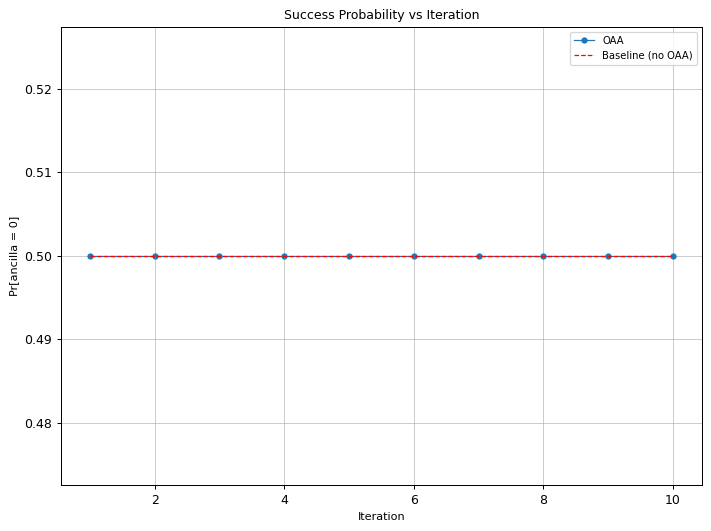

In [114]:
import numpy as np
from scipy.linalg import expm
import pennylane as qml

# === 定义 Pauli 运算符矩阵 ===
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

# === 构造 A = 1/sqrt(2) * (Z + X) ===
P_terms = [Z, X]
A = sum(P_terms) * 1/np.sqrt(2)

# === 准备 LCU 系数和单项酉矩阵 ===
coeffs = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
weights = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))  # 4 维 → 2 ancilla qubits

# U_list = 2 项酉矩阵（即 A 的每项）
U_list = P_terms
U_ops = [qml.QubitUnitary(U, wires=[1]) for U in U_list]

# === Prepare |0>_anc ⊗ |+>_sys ===
def prepare_initial_state():
    psi_sys = np.array([1, 1]) / np.sqrt(2)
    psi_anc = np.array([1, 0])
    return np.kron(psi_anc, psi_sys)

# === Reflection operator: R = (2|0⟩⟨0| ⊗ I_sys）-I ===
def construct_reflection_operator():
    I_sys = np.eye(2)
    P0_anc = np.array([[1, 0], [0, 0]])
    R = 2*np.kron(P0_anc, I_sys) - np.eye(4)
    return R

# === Run OAA iterations and record success probabilities ===
def simulate_oaa_success_only(W, W_dagger, R, psi0, max_iter):
    success_probs = []
    psi = psi0.copy()
    for _ in range(max_iter):
        psi = R @ psi
        psi = W_dagger @ psi
        psi = R @ psi
        psi = -W @ psi
        reshaped = psi.reshape((2, 2))  # [ancilla, system]
        system_unnorm = reshaped[0, :]  # ancilla = 0
        success_prob = np.sum(np.abs(system_unnorm)**2)
        success_probs.append(success_prob)
        print('[psi is]', psi)
    return success_probs

dev = qml.device("default.qubit")
@qml.qnode(dev)
def W_circuit_select():
    qml.StatePrep(weights, wires=[0])
    qml.Select(U_ops, control=[0])
    qml.adjoint(qml.StatePrep)(weights, wires=[0])
    return qml.state()
# === Main ===
W = qml.matrix(W_circuit_select, wire_order=[0,1])()  # ancilla first
W_dagger = W.conj().T
R = construct_reflection_operator()

psi_init = prepare_initial_state()
psi0 = W @ psi_init  # initial state = W |0>_anc ⊗ |+>_sys

# Baseline success probability (before OAA)
reshaped = psi0.reshape((2, 2))  # [ancilla, system]
system_unnorm = reshaped[0, :]
baseline = np.sum(np.abs(system_unnorm)**2)

# OAA
success_probs = simulate_oaa_success_only(W, W_dagger, R, psi0.copy(), max_iter=10)

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 6), dpi=90)

ax.plot(range(1, 11), success_probs, marker='o', markersize=4, linewidth=1,
        label='OAA')
ax.hlines(baseline, 1, 10, colors='r', linestyles='--', linewidth=1,
          label='Baseline (no OAA)')

ax.set_title("Success Probability vs Iteration", fontsize=10)
ax.set_xlabel("Iteration", fontsize=9)
ax.set_ylabel("Pr[ancilla = 0]", fontsize=9)

ax.grid(True, linewidth=0.5)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()


[psi is] [ 6.50538239e-01+0.j -1.30107648e-01+0.j -5.55111512e-17+0.j
 -7.48245949e-01+0.j]
[psi is] [-7.59149840e-01+0.j  1.51829968e-01+0.j -5.55111512e-17+0.j
 -6.32960647e-01+0.j]
[psi is] [-5.89806251e-01+0.j  1.17961250e-01+0.j  5.55111512e-17+0.j
  7.98882801e-01+0.j]
[psi is] [ 8.06334340e-01+0.j -1.61266868e-01+0.j -5.55111512e-17+0.j
  5.69050023e-01+0.j]
[psi is] [ 5.25299504e-01+0.j -1.05059901e-01+0.j  1.66533454e-16+0.j
 -8.44406802e-01+0.j]
[psi is] [-0.8483583 +0.j  0.16967166+0.j  0.        +0.j -0.50149748+0.j]
[psi is] [-4.57430840e-01+0.j  9.14861680e-02+0.j -1.11022302e-16+0.j
  8.84526601e-01+0.j]
[psi is] [ 8.84952768e-01+0.j -1.76990554e-01+0.j  5.55111512e-17+0.j
  4.30735351e-01+0.j]
[psi is] [ 3.86634619e-01+0.j -7.73269237e-02+0.j  5.55111512e-17+0.j
 -9.18985429e-01+0.j]
[psi is] [-9.15883537e-01+0.j  1.83176707e-01+0.j -5.55111512e-17+0.j
 -3.57216516e-01+0.j]


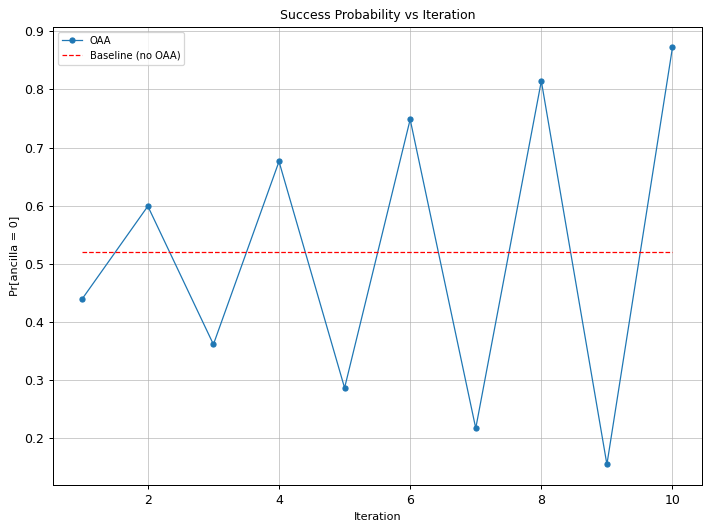

In [115]:
import numpy as np
from scipy.linalg import expm
import pennylane as qml

# === 定义 Pauli 运算符矩阵 ===
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

# === 构造 A = (0.6*Z + 0.4*X) ===
P_terms = [Z, X]
#A = sum(P_terms) * 1/np.sqrt(2)
A = 0.6*Z+ 0.4*X
# === 准备 LCU 系数和单项酉矩阵 ===
#coeffs = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
coeffs = np.array([0.6, 0.4])
weights = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))  # 4 维 → 2 ancilla qubits

# U_list = 2 项酉矩阵（即 A 的每项）
U_list = P_terms
U_ops = [qml.QubitUnitary(U, wires=[1]) for U in U_list]

# === Prepare |0>_anc ⊗ |+>_sys ===
def prepare_initial_state():
    psi_sys = np.array([1, 1]) / np.sqrt(2)
    psi_anc = np.array([1, 0])
    return np.kron(psi_anc, psi_sys)

# === Reflection operator: R = (2|0⟩⟨0| ⊗ I_sys）-I ===
def construct_reflection_operator():
    I_sys = np.eye(2)
    P0_anc = np.array([[1, 0], [0, 0]])
    R = 2*np.kron(P0_anc, I_sys) - np.eye(4)
    return R

# === Run OAA iterations and record success probabilities ===
def simulate_oaa_success_only(W, W_dagger, R, psi0, max_iter):
    success_probs = []
    psi = psi0.copy()
    for _ in range(max_iter):
        psi = R @ psi
        psi = W_dagger @ psi
        psi = R @ psi
        psi = -W @ psi
        reshaped = psi.reshape((2, 2))  # [ancilla, system]
        system_unnorm = reshaped[0, :]  # ancilla = 0
        success_prob = np.sum(np.abs(system_unnorm)**2)
        success_probs.append(success_prob)
        print('[psi is]', psi)
    return success_probs

dev = qml.device("default.qubit")
@qml.qnode(dev)
def W_circuit_select():
    qml.StatePrep(weights, wires=[0])
    qml.Select(U_ops, control=[0])
    qml.adjoint(qml.StatePrep)(weights, wires=[0])
    return qml.state()
# === Main ===
W = qml.matrix(W_circuit_select, wire_order=[0,1])()  # ancilla first
W_dagger = W.conj().T
R = construct_reflection_operator()

psi_init = prepare_initial_state()
psi0 = W @ psi_init  # initial state = W |0>_anc ⊗ |+>_sys

# Baseline success probability (before OAA)
reshaped = psi0.reshape((2, 2))  # [ancilla, system]
system_unnorm = reshaped[0, :]
baseline = np.sum(np.abs(system_unnorm)**2)

# OAA
success_probs = simulate_oaa_success_only(W, W_dagger, R, psi0.copy(), max_iter=10)

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 6), dpi=90)

ax.plot(range(1, 11), success_probs, marker='o', markersize=4, linewidth=1,
        label='OAA')
ax.hlines(baseline, 1, 10, colors='r', linestyles='--', linewidth=1,
          label='Baseline (no OAA)')

ax.set_title("Success Probability vs Iteration", fontsize=10)
ax.set_xlabel("Iteration", fontsize=9)
ax.set_ylabel("Pr[ancilla = 0]", fontsize=9)

ax.grid(True, linewidth=0.5)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()


### QPE

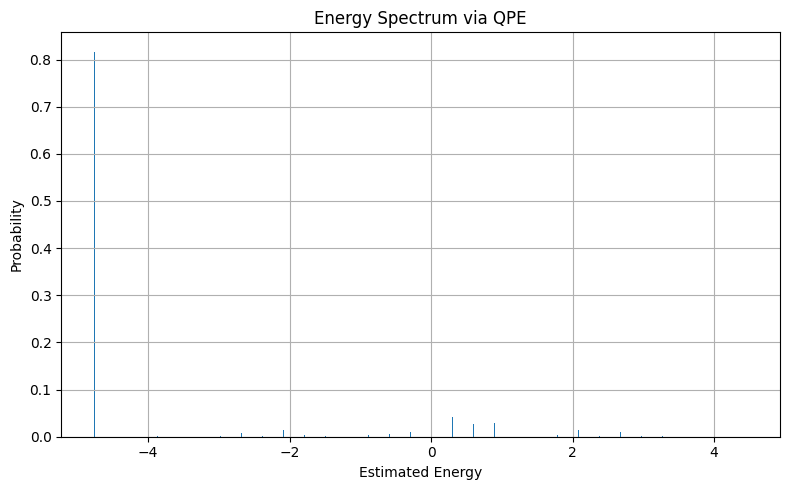

In [13]:
def build_qpe_circuit(H_mat, n=4, t=5):
    dev = qml.device("default.qubit", wires=n + t)

    @qml.qnode(dev)
    def qpe_circuit():
        # Step 1: 初始态准备：system = Hadamard superposition
        for i in range(n):
            qml.Hadamard(i)

        # Step 2: phase estimation qubits = Hadamard
        for i in range(n, n + t):
            qml.Hadamard(i)

        # Step 3: 控制作用 e^{2πi H 2^j}
        for j in range(t):
            U = expm(2j * np.pi * (2 ** j) * H_mat)
            qml.ControlledQubitUnitary(U, control_wires=n + j, wires=range(n))

        # Step 4: inverse QFT
        qml.adjoint(qml.QFT)(wires=range(n, n + t))

        # Step 5: 测量能谱估算寄存器
        return qml.probs(wires=range(n, n + t))

    return qpe_circuit

# 构造 TFIM Hamiltonian
n = 4
coeffs, ops = [], []
for i in range(n - 1):
    coeffs.append(-1.0)
    ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
for i in range(n):
    coeffs.append(-1.0)
    ops.append(qml.PauliX(i))
H = qml.Hamiltonian(coeffs, ops)
H_mat = qml.matrix(H)

# 归一化 H 到 [0, 1)
λ_min, λ_max = np.min(np.linalg.eigvalsh(H_mat)), np.max(np.linalg.eigvalsh(H_mat))
H_norm = (H_mat - λ_min * np.eye(2**n)) / (λ_max - λ_min)

# 构建并运行 QPE
t = 5  # 控制精度
qpe_circuit = build_qpe_circuit(H_norm, n=n, t=t)
probs = qpe_circuit()

# 可视化
x = np.arange(len(probs))
energies = x / 2 ** t * (λ_max - λ_min) + λ_min  # 还原能量刻度

plt.figure(figsize=(8, 5))
plt.bar(energies, probs, width=0.015)
plt.xlabel("Estimated Energy")
plt.ylabel("Probability")
plt.title("Energy Spectrum via QPE")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
energies

tensor([-4.75877048, -4.46134733, -4.16392417, -3.86650102, -3.56907786,
        -3.27165471, -2.97423155, -2.6768084 , -2.37938524, -2.08196209,
        -1.78453893, -1.48711578, -1.18969262, -0.89226947, -0.59484631,
        -0.29742316,  0.        ,  0.29742316,  0.59484631,  0.89226947,
         1.18969262,  1.48711578,  1.78453893,  2.08196209,  2.37938524,
         2.6768084 ,  2.97423155,  3.27165471,  3.56907786,  3.86650102,
         4.16392417,  4.46134733], requires_grad=True)

In [16]:
eigvals

tensor([-4.75877048, -4.06417777, -2.75877048, -2.06417777, -1.69459271,
        -1.        , -1.        , -0.30540729,  0.30540729,  1.        ,
         1.        ,  1.69459271,  2.06417777,  2.75877048,  4.06417777,
         4.75877048], requires_grad=True)

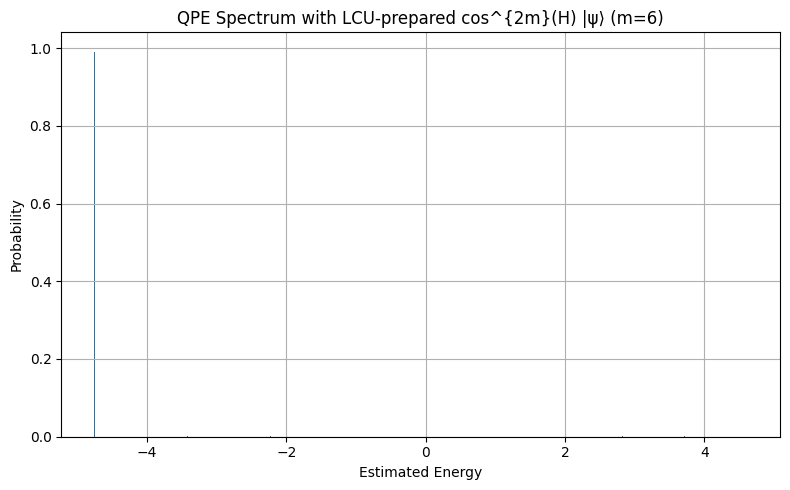

In [19]:
def build_lcu_prepared_state(H_mat, m=6, n=4):
    k_vals = np.arange(-m, m + 1)
    alpha_k = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals])
    alpha_k /= np.sum(alpha_k)

    n_lcu = len(alpha_k)
    n_anc = int(np.ceil(np.log2(n_lcu)))
    pad_len = 2 ** n_anc
    weights = np.sqrt(np.pad(alpha_k, (0, pad_len - n_lcu)))
    weights /= np.linalg.norm(weights)

    U_list = [expm(2j * k * H_mat) for k in k_vals]
    while len(U_list) < pad_len:
        U_list.append(np.eye(2 ** n))

    n_total = n + n_anc
    dev = qml.device("default.qubit", wires=n_total)

    @qml.qnode(dev)
    def prep_state():
        for i in range(n):
            qml.Hadamard(i)
        qml.MottonenStatePreparation(weights, wires=range(n, n + n_anc))
        for idx, U in enumerate(U_list):
            bin_str = format(idx, f"0{n_anc}b")
            ctrl = [n + i for i, b in enumerate(bin_str) if b == '1']
            if ctrl:
                qml.ControlledQubitUnitary(U, control_wires=ctrl, wires=range(n))
            else:
                qml.QubitUnitary(U, wires=range(n))
        qml.adjoint(qml.MottonenStatePreparation)(weights, wires=range(n, n + n_anc))
        return qml.state()

    psi = prep_state()
    reshaped = psi.reshape((2 ** n, 2 ** n_anc))
    system_unnorm = reshaped[:, 0]
    system_state = system_unnorm / np.linalg.norm(system_unnorm)
    return system_state

def build_qpe_with_input_state(H_mat, input_state, n=4, t=6):
    dev = qml.device("default.qubit", wires=n + t)

    @qml.qnode(dev)
    def circuit():
        qml.StatePrep(input_state, wires=range(n))
        for i in range(n, n + t):
            qml.Hadamard(i)
        for j in range(t):
            U = expm(2j * np.pi * (2 ** j) * H_mat)
            qml.ControlledQubitUnitary(U, control_wires=n + j, wires=range(n))
        qml.adjoint(qml.QFT)(wires=range(n, n + t))
        return qml.probs(wires=range(n, n + t))

    return circuit

# TFIM Hamiltonian
n = 4
coeffs, ops = [], []
for i in range(n - 1):
    coeffs.append(-1.0)
    ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
for i in range(n):
    coeffs.append(-1.0)
    ops.append(qml.PauliX(i))
H = qml.Hamiltonian(coeffs, ops)
H_mat = qml.matrix(H)

λ_min, λ_max = np.min(np.linalg.eigvalsh(H_mat)), np.max(np.linalg.eigvalsh(H_mat))
H_norm = (H_mat - λ_min * np.eye(2 ** n)) / (λ_max - λ_min)

# LCU-prepared input for QPE
lcu_state = build_lcu_prepared_state(H_norm, m=6, n=n)
qpe_circuit = build_qpe_with_input_state(H_norm, lcu_state, n=n, t=6)
probs = qpe_circuit()

# Plot
energies = np.arange(len(probs)) / 2**6 * (λ_max - λ_min) + λ_min
plt.figure(figsize=(8, 5))
plt.bar(energies, probs, width=0.01)
plt.xlabel("Estimated Energy")
plt.ylabel("Probability")
plt.title("QPE Spectrum with LCU-prepared cos^{2m}(H) |ψ⟩ (m=6)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
probs

tensor([9.90827432e-01, 1.25277247e-05, 2.45138253e-06, 7.09196576e-05,
        1.41679347e-06, 3.91193214e-06, 2.63707527e-05, 3.31295404e-04,
        1.87099566e-05, 8.94386825e-04, 4.44710465e-05, 3.61845722e-05,
        1.55639916e-06, 1.16618724e-04, 1.17264709e-04, 3.16821750e-04,
        2.20217333e-05, 1.84017568e-03, 1.12220637e-04, 5.05718023e-04,
        4.54403698e-06, 1.55570040e-06, 1.27305329e-05, 1.51560122e-04,
        4.65882653e-06, 1.31458732e-04, 3.71291701e-06, 1.86882345e-06,
        8.05273595e-10, 2.40108760e-08, 4.95253817e-08, 1.81466109e-07,
        3.79053629e-09, 1.29154944e-07, 5.43666467e-08, 2.68216130e-07,
        1.60100336e-08, 7.73820625e-07, 5.41884603e-06, 3.16274863e-05,
        2.95643238e-06, 1.52989598e-04, 1.61794849e-05, 8.13989964e-06,
        1.42871426e-06, 1.28908414e-04, 1.64948512e-04, 2.63287275e-04,
        1.82687710e-05, 1.61259702e-03, 8.19169871e-05, 6.17852463e-04,
        6.67889423e-06, 9.66546706e-06, 4.86361890e-05, 4.650860

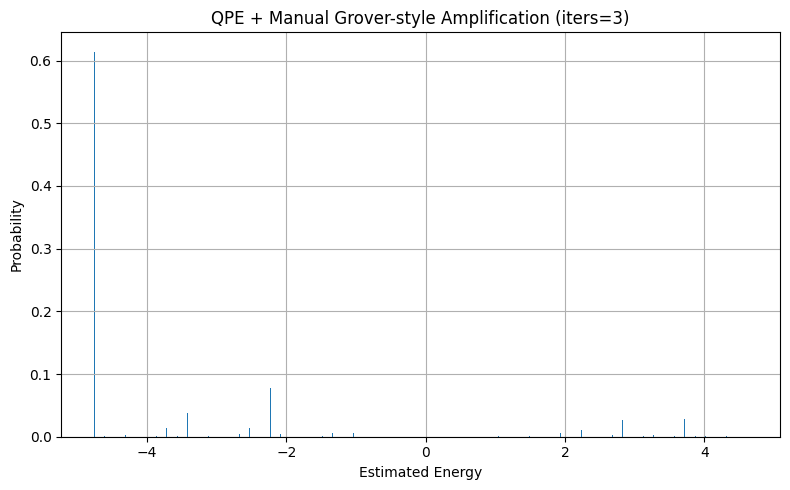

In [25]:
import pennylane as qml
from pennylane import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

def build_lcu_prepared_state(H, n=4, m=6):
    k_vals = np.arange(-m, m+1)
    alpha_k = 2**(-2*m) * np.array([math.comb(2*m, m+k) for k in k_vals])
    alpha_k /= np.sum(alpha_k)

    n_anc = int(np.ceil(np.log2(len(alpha_k))))
    pad_len = 2**n_anc
    weights = np.sqrt(np.pad(alpha_k, (0, pad_len - len(alpha_k))))
    weights /= np.linalg.norm(weights)

    U_list = [expm(2j * k * H) for k in k_vals]
    U_list += [np.eye(2**n)] * (pad_len - len(U_list))
    n_total = n + n_anc
    dev = qml.device("default.qubit", wires=n_total)

    @qml.qnode(dev)
    def prep_state():
        for i in range(n):
            qml.Hadamard(i)
        qml.MottonenStatePreparation(weights, wires=range(n, n+n_anc))
        for idx, U in enumerate(U_list):
            bin_str = format(idx, f"0{n_anc}b")
            ctrl = [n+i for i, b in enumerate(bin_str) if b == '1']
            if ctrl:
                qml.ControlledQubitUnitary(U, control_wires=ctrl, wires=range(n))
            else:
                qml.QubitUnitary(U, wires=range(n))
        qml.adjoint(qml.MottonenStatePreparation)(weights, wires=range(n, n+n_anc))
        return qml.state()

    psi = prep_state()
    reshaped = psi.reshape((2**n, 2**n_anc))
    system_unnorm = reshaped[:, 0]
    system_state = system_unnorm / np.linalg.norm(system_unnorm)
    return system_state

def run_qpe_aa(H, psi_input, n=4, t=6, iters=3):
    total_wires = n + t
    dev = qml.device("default.qubit", wires=total_wires)

    @qml.qnode(dev)
    def circuit():
        # State preparation
        qml.StatePrep(psi_input, wires=range(n))

        # QPE
        for i in range(n, n + t):
            qml.Hadamard(i)
        for j in range(t):
            Uj = expm(2j * np.pi * (2**j) * H)
            qml.ControlledQubitUnitary(Uj, control_wires=n + j, wires=range(n))
        qml.adjoint(qml.QFT)(wires=range(n, n + t))

        return qml.state()

    psi = circuit()
    dim = 2 ** total_wires

    # Define projection operator Π onto phase register = 0 (i.e., |0...0⟩)
    Π = np.zeros(dim)
    Π[::2 ** n] = 1.0  # 每隔 2^n（系统维度）取一个，对应 anc=0
    RΠ = np.eye(dim) - 2 * np.diag(Π)
    RS = 2 * np.outer(psi, psi.conj()) - np.eye(dim)
    Q = -RS @ RΠ

    # Grover iteration
    results = []
    psi_r = psi.copy()
    for _ in range(iters):
        psi_r = Q @ psi_r

    # Project to estimation register and get probs
    reshaped = psi_r.reshape((2 ** n, 2 ** t))
    probs = np.sum(np.abs(reshaped) ** 2, axis=0)
    probs /= probs.sum()
    return probs

# === Main program ===
n, t, m, iters = 4, 6, 6, 3
coeffs, ops = [], []
for i in range(n - 1):
    coeffs.append(-1.0)
    ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
for i in range(n):
    coeffs.append(-1.0)
    ops.append(qml.PauliX(i))
H = qml.Hamiltonian(coeffs, ops)
H_mat = qml.matrix(H)
eigvals = np.linalg.eigvalsh(H_mat)
λ_min, λ_max = eigvals[0], eigvals[-1]
H_norm = (H_mat - λ_min * np.eye(2**n)) / (λ_max - λ_min)

# Prepare state and run
psi_input = build_lcu_prepared_state(H_norm, n=n, m=m)
probs = run_qpe_aa(H_norm, psi_input, n=n, t=t, iters=iters)

# Plot
energies = np.arange(len(probs)) / 2**t * (λ_max - λ_min) + λ_min
plt.figure(figsize=(8, 5))
plt.bar(energies, probs, width=0.01)
plt.xlabel("Estimated Energy")
plt.ylabel("Probability")
plt.title(f"QPE + Manual Grover-style Amplification (iters={iters})")
plt.grid(True)
plt.tight_layout()
plt.show()


## projector |0><0|

In [87]:
## projector
import pennylane as qml
import numpy as np

# 定义量子设备
dev = qml.device('default.qubit', wires=2)

# 投影算符示例（Pauli-Z 和 Identity 的线性组合）
coeffs = np.array([1/2, 1/2])
proj_unitaries = [qml.Identity(0), qml.PauliZ(0)]

# 使用 Qubitization 进行投影算符的量子化
@qml.qnode(dev)
def qubitization_circuit():
    # 使用 Qubitization 类来进行 qubitization
    qml.Hadamard(0)
    qml.RX(np.pi/2,[0])
    qml.Qubitization(qml.dot(coeffs,proj_unitaries), [1])  # 使用投影算符

    # 返回最终的量子态
    return qml.state()

# 绘制电路图
circuit_diagram = qml.draw_mpl(qubitization_circuit, style='pennylane')

# 执行并打印量子态
state = qubitization_circuit()[:2**1].real
state/=np.linalg.norm(state)
print(state)


qubitization_circuit().shape

[1. 0.]


(4,)

(<Figure size 600x300 with 1 Axes>, <Axes: >)


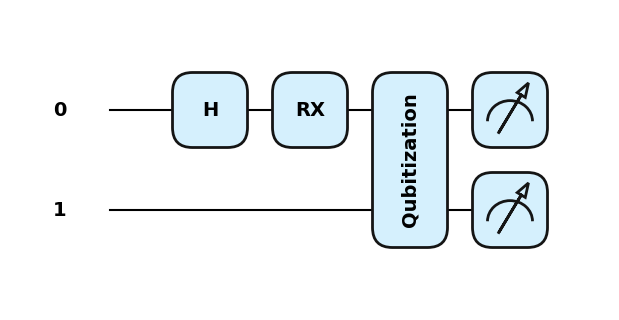

In [89]:
# 打印电路图
print(circuit_diagram())

## QFT

In [2]:
import pennylane as qml
import numpy as np

n_wires = 4
dev = qml.device("default.qubit", wires=n_wires, shots=1)

def add_k_fourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])

@qml.qnode(dev)
def sum(m, k):
    qml.BasisEmbedding(m, wires=range(n_wires))  # m encoding

    qml.QFT(wires=range(n_wires))  # step 1

    add_k_fourier(k, range(n_wires))  # step 2

    qml.adjoint(qml.QFT)(wires=range(n_wires))  # step 3

    return qml.sample()


print(f"The ket representation of the sum of 3 and 4 is {sum(3,4)}")

The ket representation of the sum of 3 and 4 is [0 1 1 1]


## Amplitude amplification

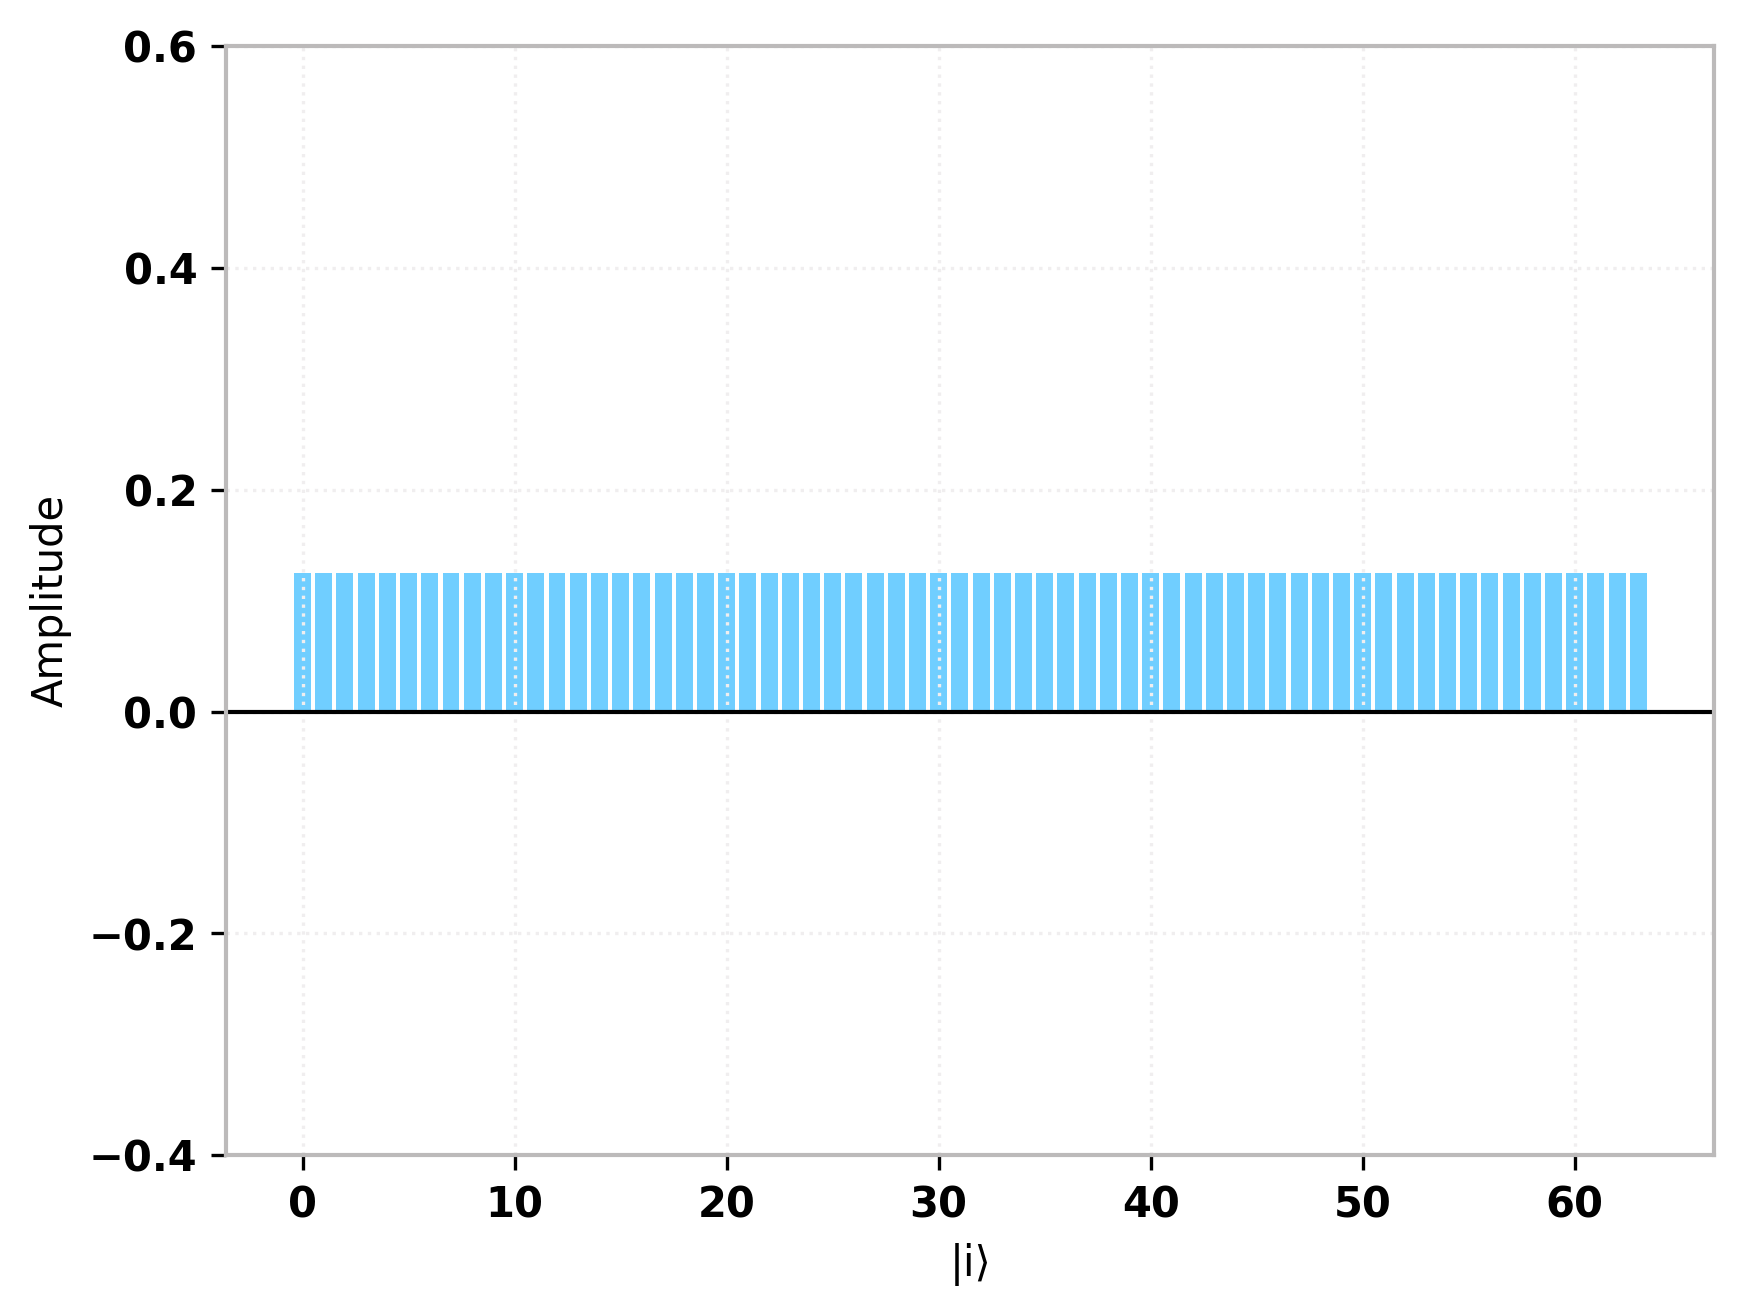

In [36]:
import pennylane as qml
import matplotlib.pyplot as plt
plt.style.use('pennylane.drawer.plot')
values = [1, -2, 3, 4, 5, -6]
n = len(values)
@qml.prod
# This decorator converts the quantum function U into an operator.
# It is useful for later use in the AmplitudeAmplification template.
def U(wires):
    # create the generator U, such that U|0⟩ = |Ψ⟩
    for wire in wires:
        qml.Hadamard(wires=wire)

dev = qml.device("default.qubit")

@qml.qnode(dev)
def circuit():
    U(wires = range(n))
    return qml.state()
qc_diagram = qml.draw_mpl(circuit, style='pennylane')
output = circuit()[:64].real

plt.bar(range(len(output)), output)
plt.ylim(-0.4, 0.6)
plt.ylabel("Amplitude")
plt.xlabel("|i⟩")
plt.axhline(0, color='black', linewidth=1)
plt.show()

(<Figure size 1200x2100 with 1 Axes>, <Axes: >)


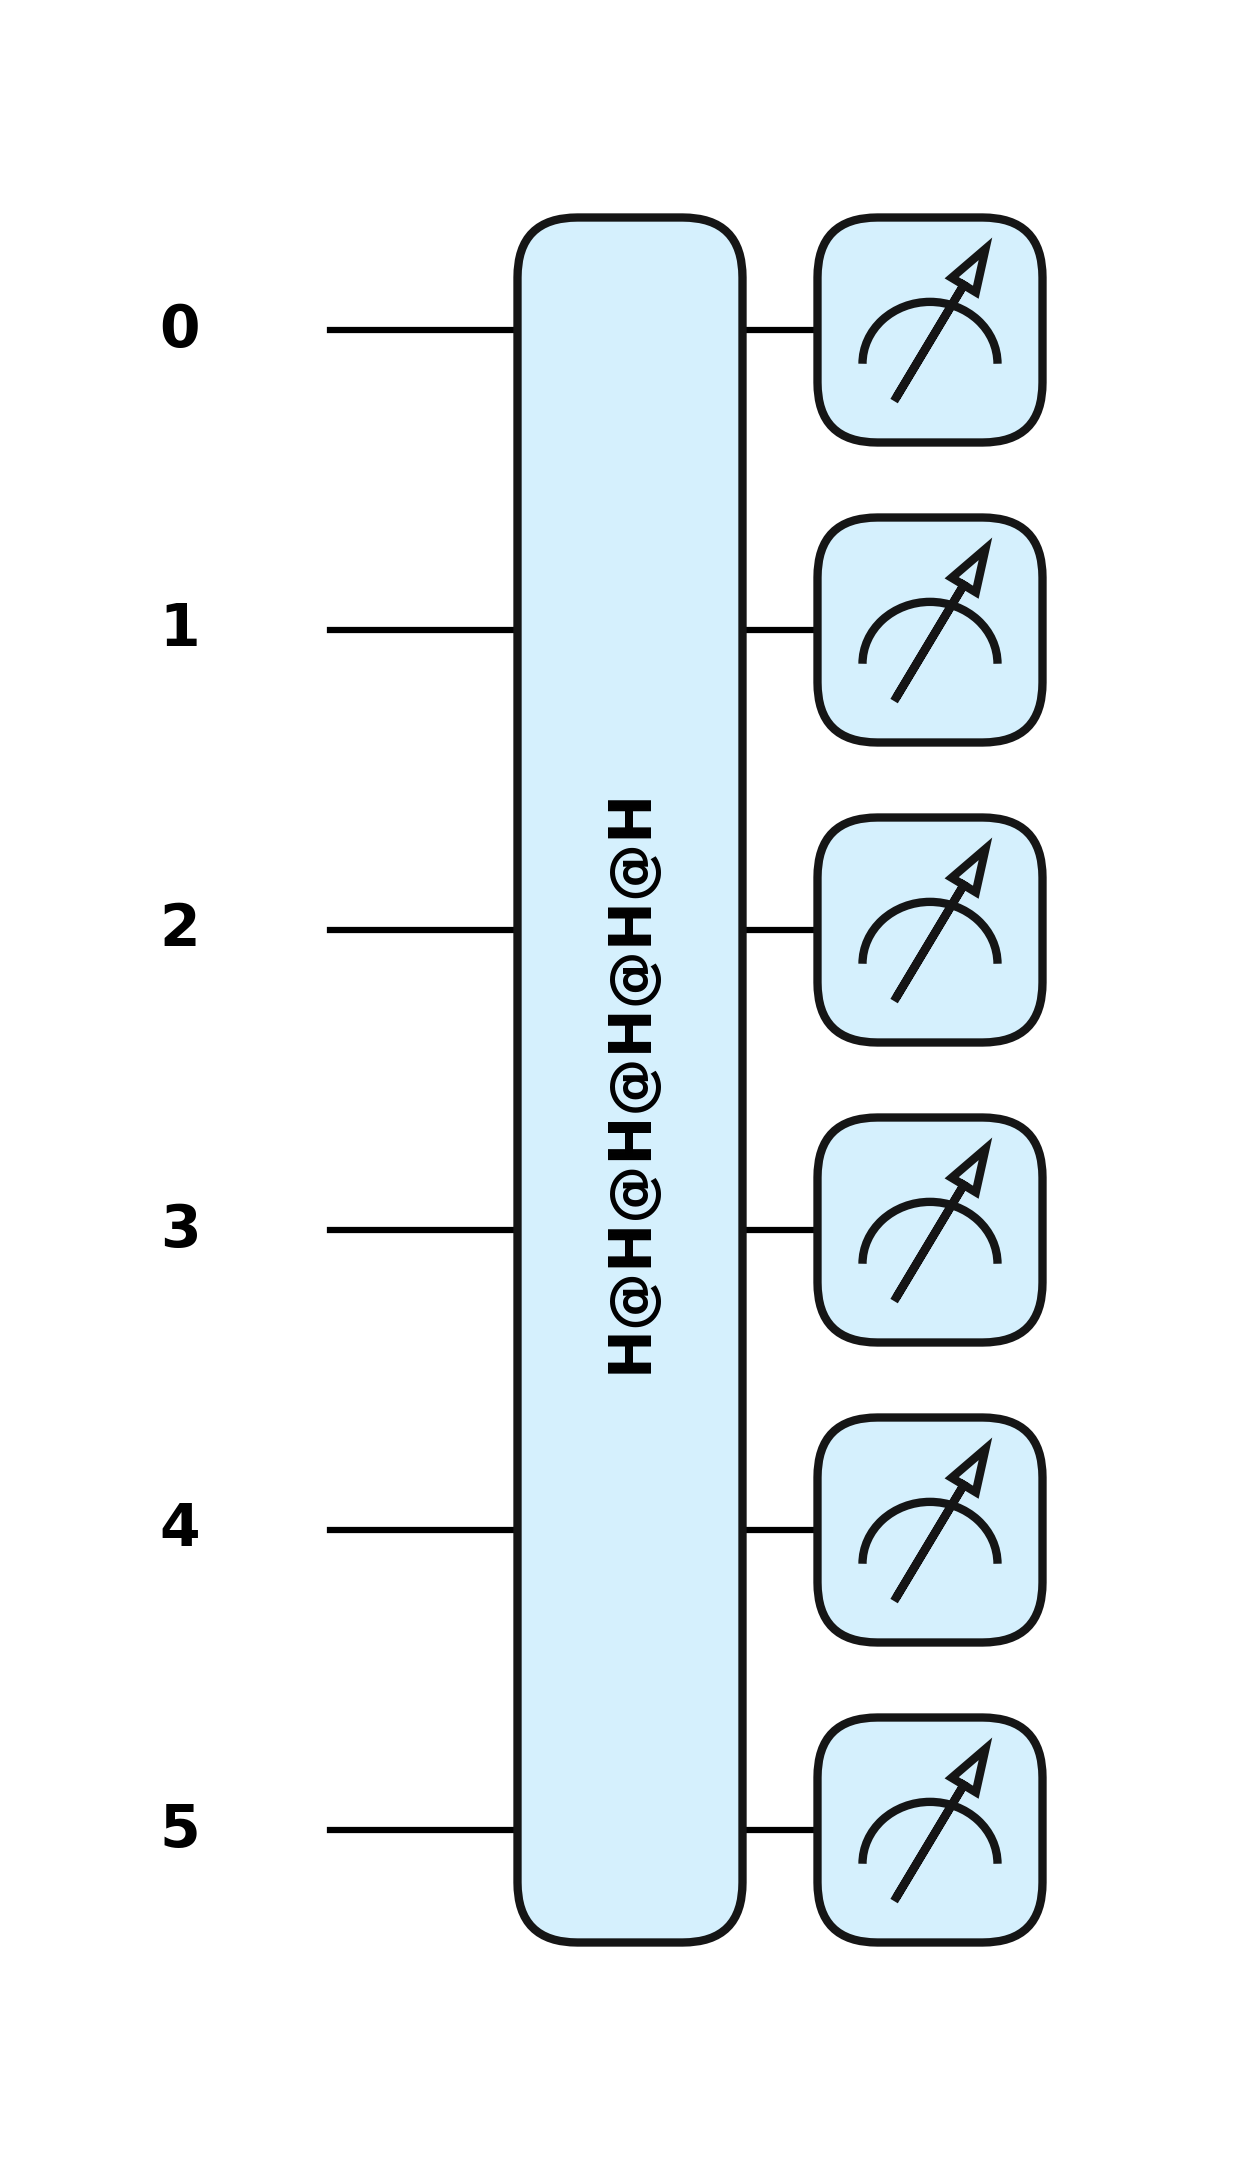

In [37]:
print(qc_diagram())

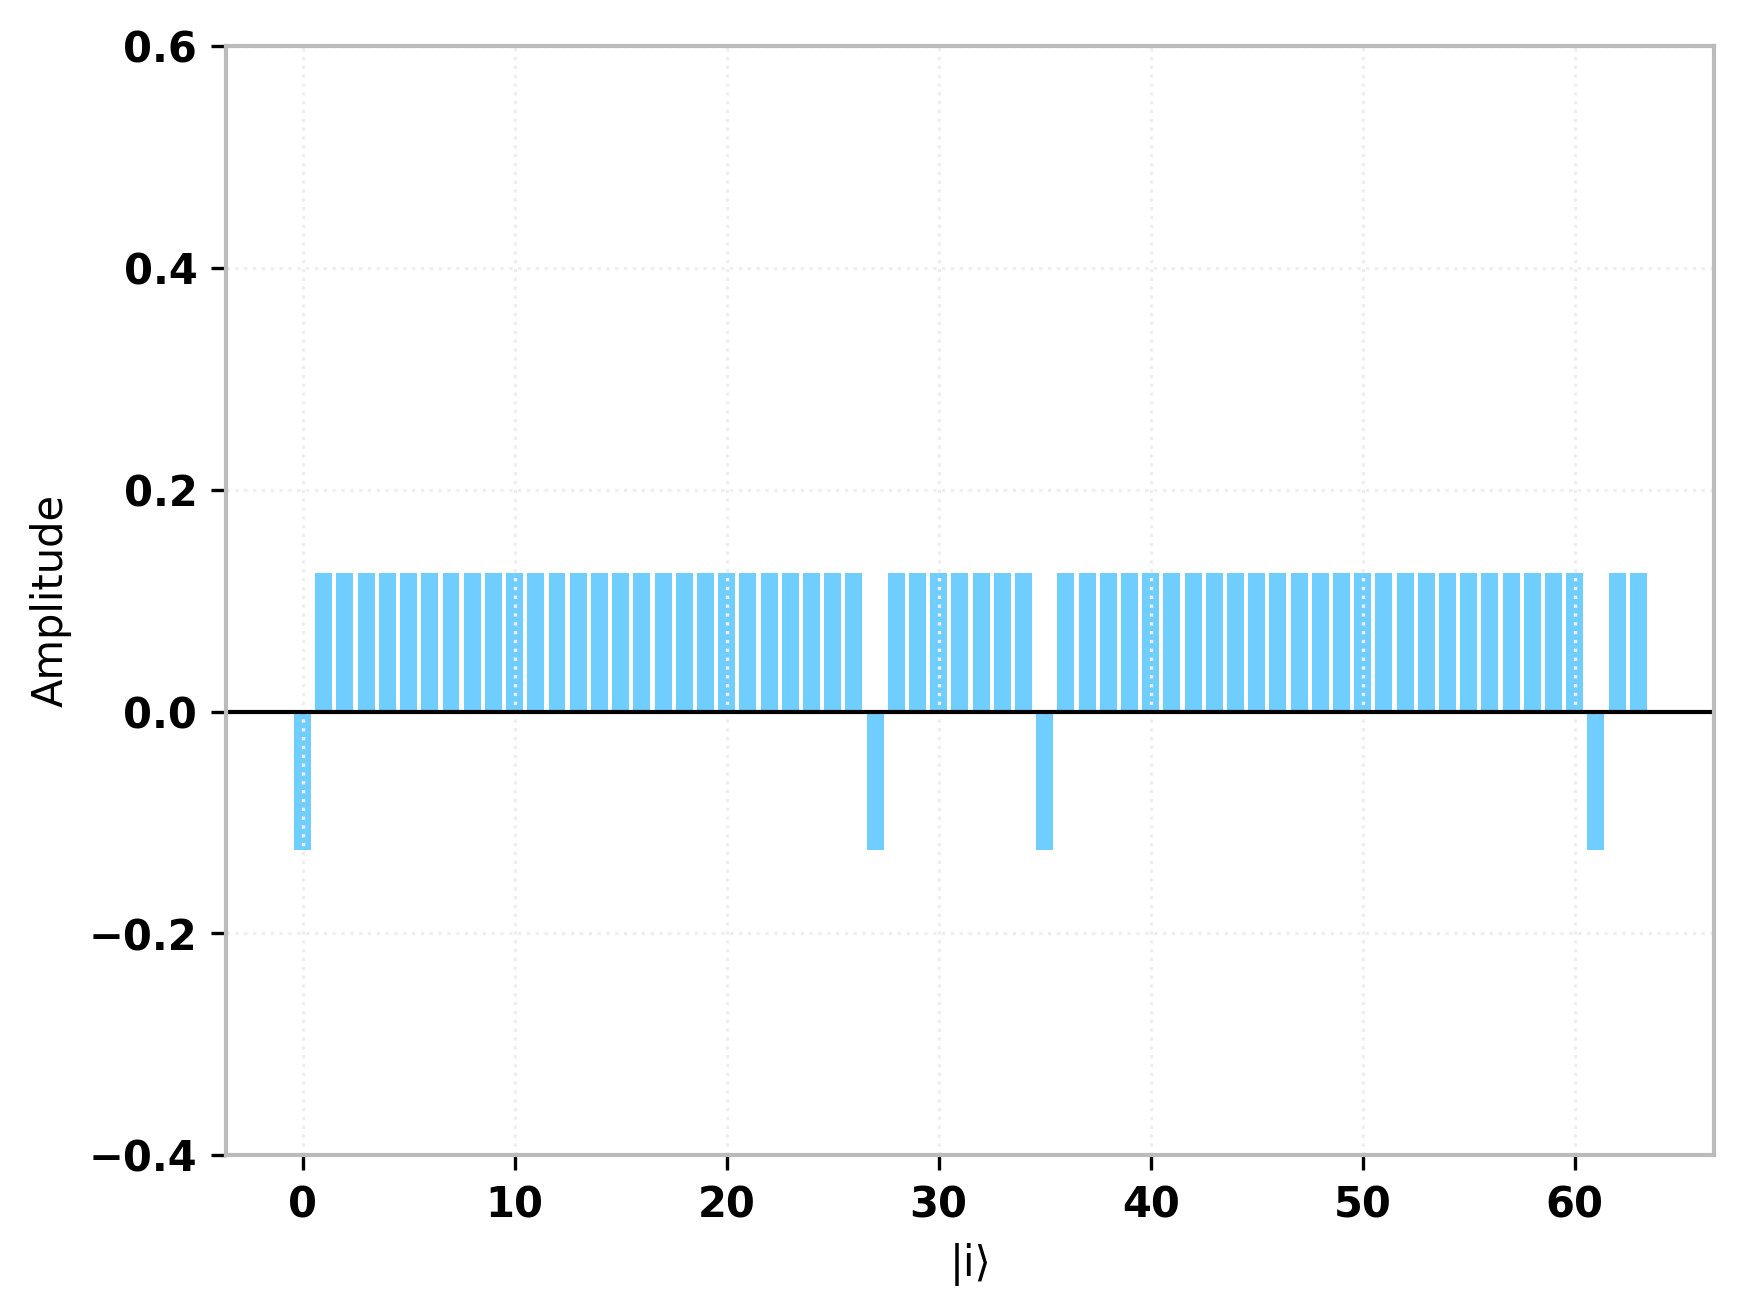

In [44]:
import numpy as np

def Sum(wires_subset, wires_sum):
    qml.QFT(wires = wires_sum)
    for i, value in enumerate(values):
        for j in range(len(wires_sum)):
            qml.CRZ(value * np.pi / (2 ** j), wires=[wires_subset[i], wires_sum[j]])
    qml.adjoint(qml.QFT)(wires=wires_sum)

@qml.prod
def oracle(wires_subset, wires_sum):
    # Reflection on |ϕ⟂⟩
    Sum(wires_subset, wires_sum)
    qml.FlipSign(0, wires=wires_sum)
    qml.adjoint(Sum)(wires_subset, wires_sum)


@qml.qnode(dev)
def circuit():
    U(wires=range(n))                 # Generate initial state
    oracle(range(n), range(n, n+5))   # Apply the reflection on |ϕ⟂⟩
    return qml.state()


output = circuit()[0::2 ** 5].real
plt.bar(range(len(output)), output)
plt.ylim(-0.4, 0.6)
plt.ylabel("Amplitude")
plt.xlabel("|i⟩")
plt.axhline(0, color='black', linewidth=1)
plt.show()

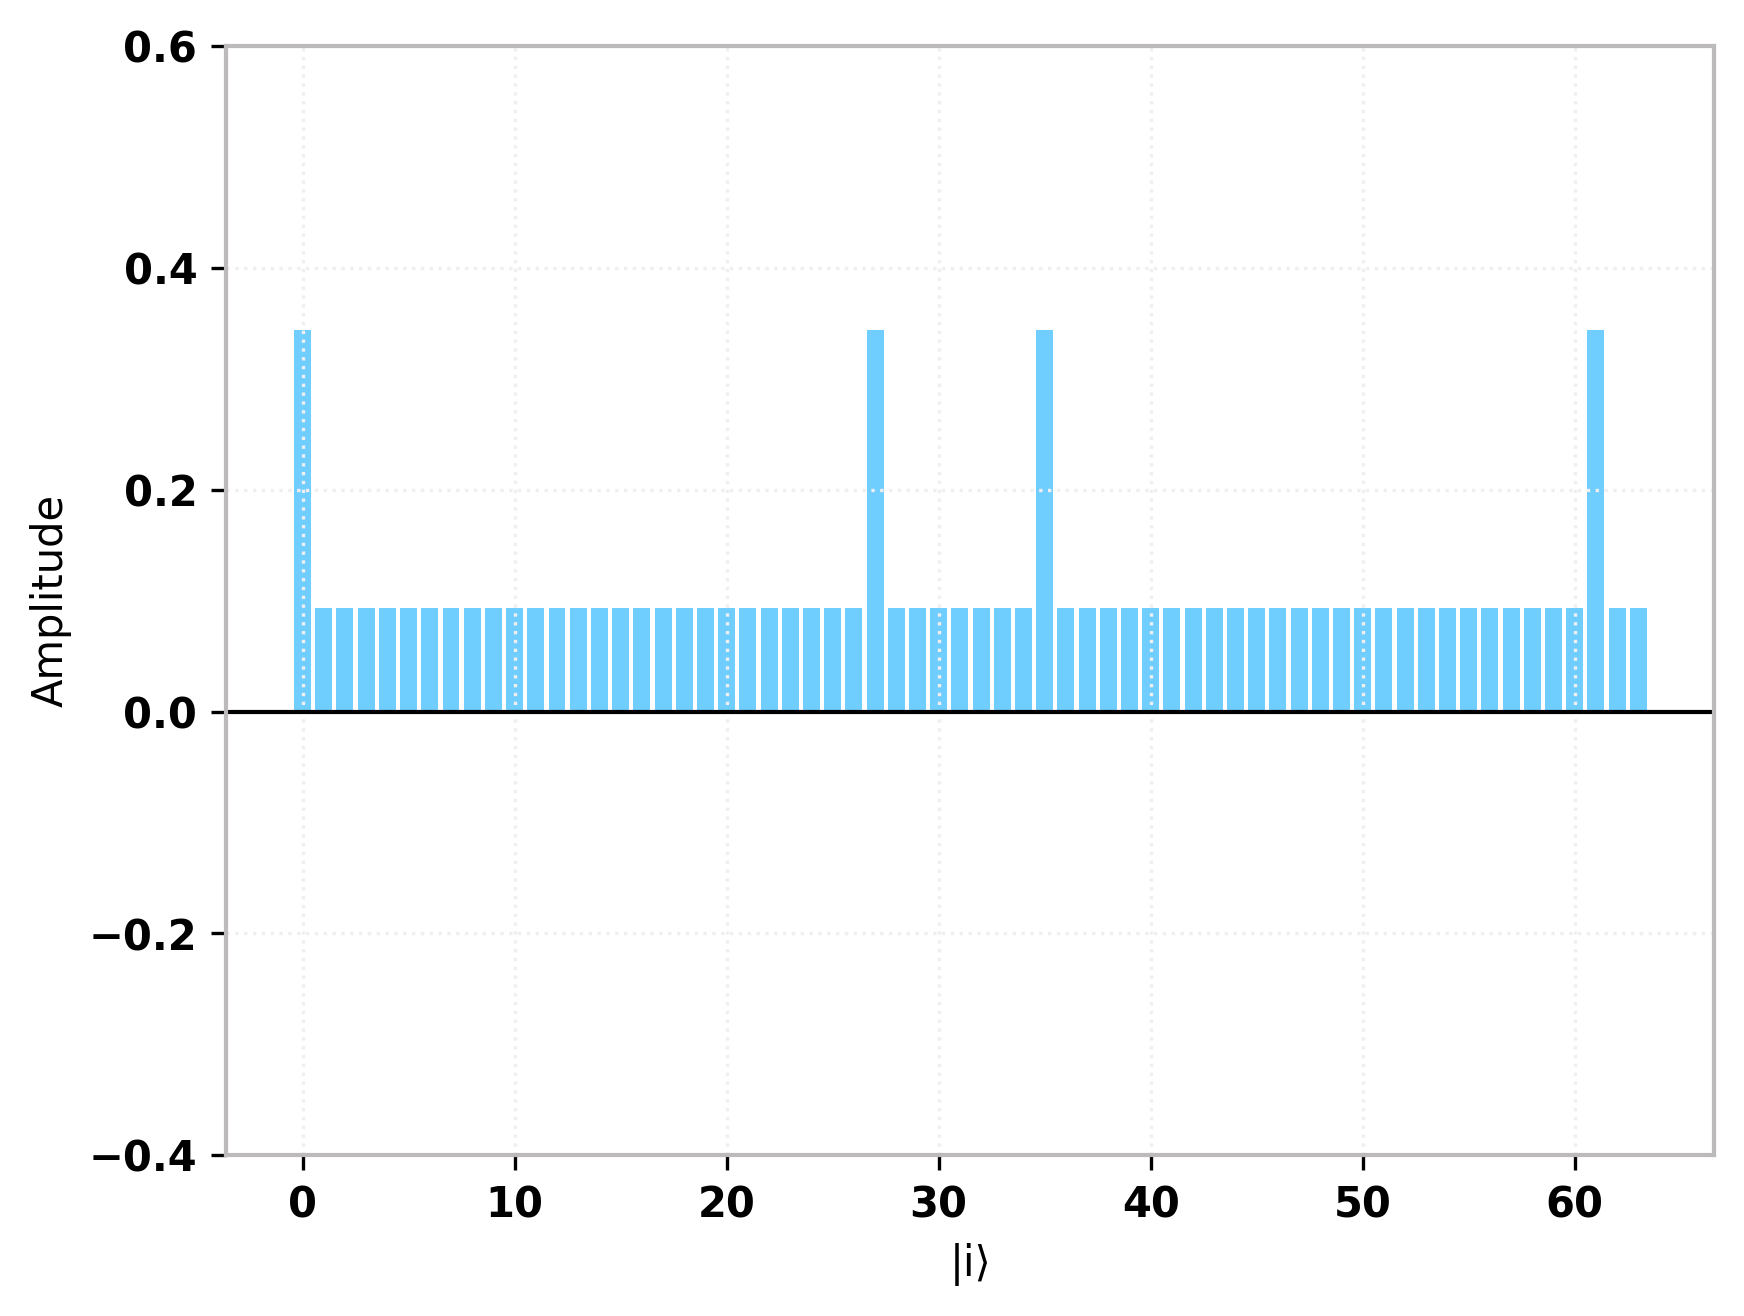

In [45]:
@qml.qnode(dev)
def circuit():
    U(wires=range(n))                  # Generate initial state
    oracle(range(n), range(n, n + 5))  # Apply the reflection on |ϕ⟂⟩
    qml.Reflection(U(wires=range(n)))  # Reflect on |Ψ⟩
    return qml.state()

output = circuit()[0::2 ** 5].real
plt.bar(range(len(output)), output)
plt.ylim(-0.4, 0.6)
plt.ylabel("Amplitude")
plt.xlabel("|i⟩")
plt.axhline(0, color='black', linewidth=1)
plt.show()

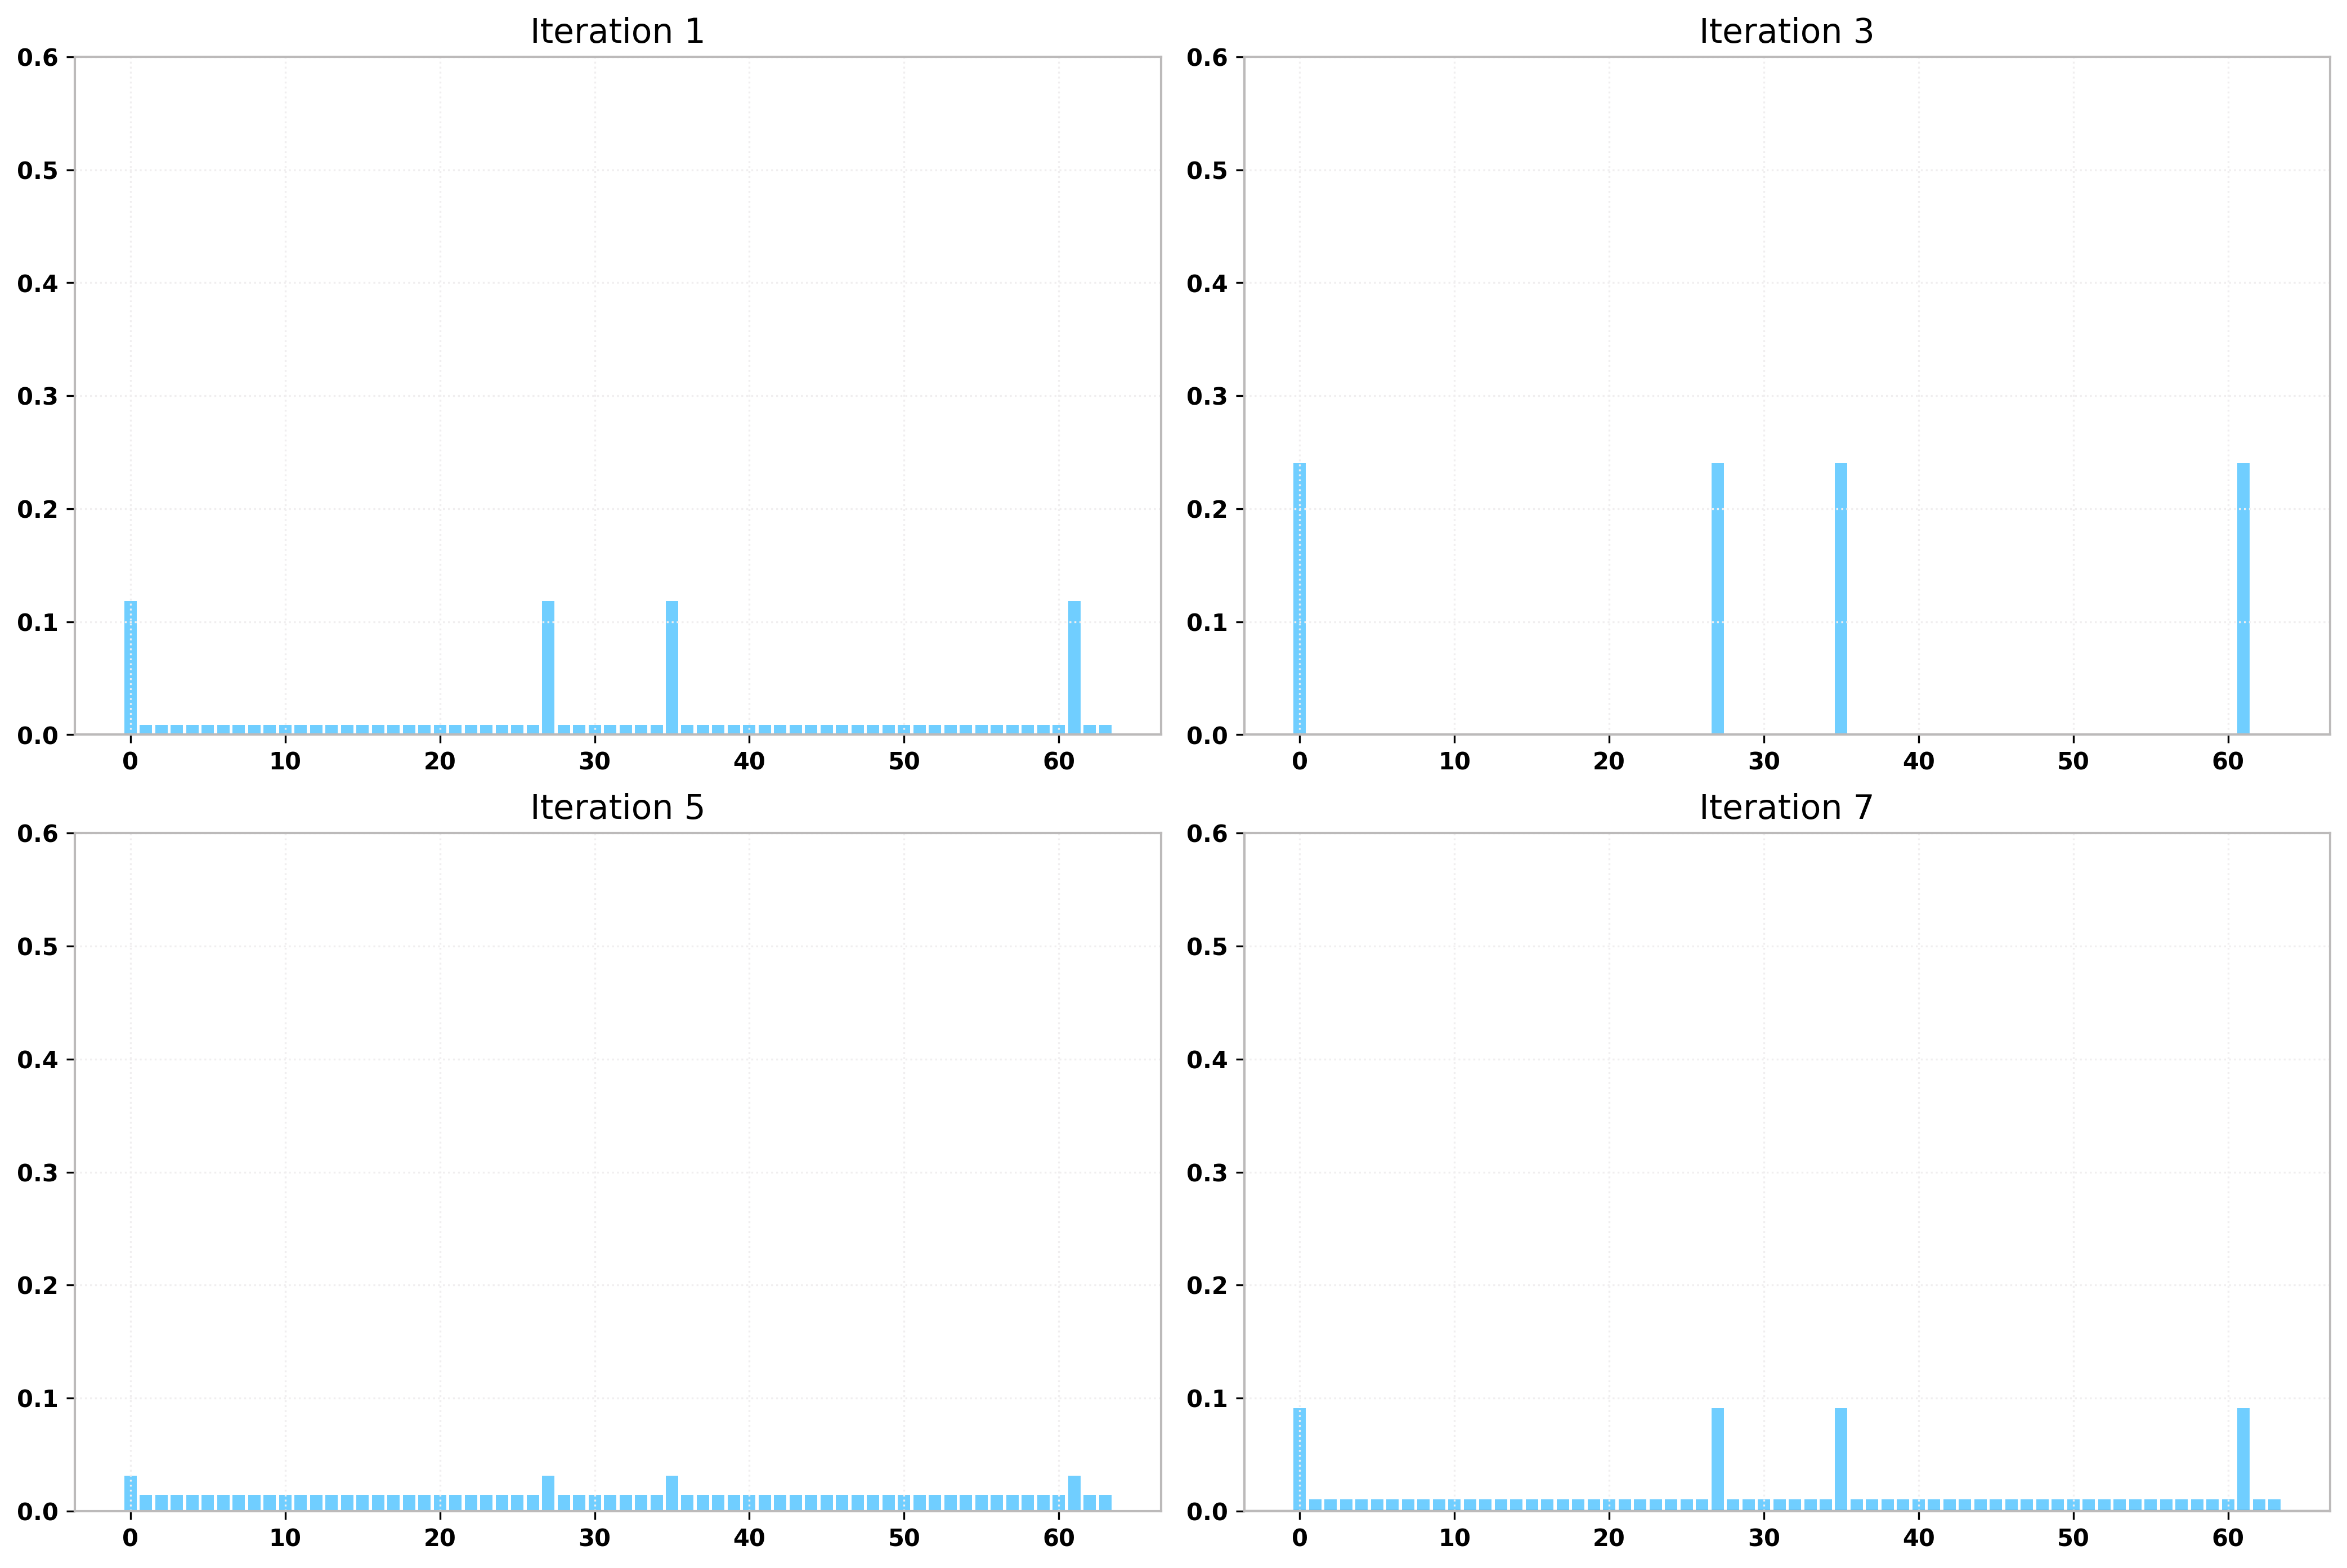

In [46]:
@qml.qnode(dev)
def circuit(iters):
    U(wires=range(n))
    qml.AmplitudeAmplification(U = U(wires = range(n)),
                               O = oracle(range(n), range(n, n + 5)),
                               iters = iters)

    return qml.probs(wires = range(n))

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
for i in range(1,9,2):
    output = circuit(iters=i)
    ax = axs[i // 4, i //2 % 2]
    ax.bar(range(len(output)), output)
    ax.set_ylim(0, 0.6)
    ax.set_title(f"Iteration {i}")

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.axhline(0, color='black', linewidth=1)
plt.show()

In [119]:
@qml.prod
def generator(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)

U = generator(wires=range(3))
O = qml.FlipSign(2, wires=range(3))

dev = qml.device("default.qubit")

@qml.qnode(dev)
def circuit():

    generator(wires=range(3))
    qml.AmplitudeAmplification(U, O, iters=5, fixed_point=True, work_wire=3)

    return qml.probs(wires=range(3))

In [120]:
print(np.round(circuit(),3))

[0.013 0.013 0.91  0.013 0.013 0.013 0.013 0.013]


D:\research\vqe_U\.venv\Lib\site-packages\pennylane\templates\subroutines\amplitude_amplification.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  float(2 * np.arctan(1 / (np.tan(2 * np.pi * j / iters) * np.sqrt(1 - gamma**2))))


### Fixed-point Amplitude Amplification

D:\Research\vqe_U\.venv\Lib\site-packages\pennylane\templates\subroutines\amplitude_amplification.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  float(2 * np.arctan(1 / (np.tan(2 * np.pi * j / iters) * np.sqrt(1 - gamma**2))))


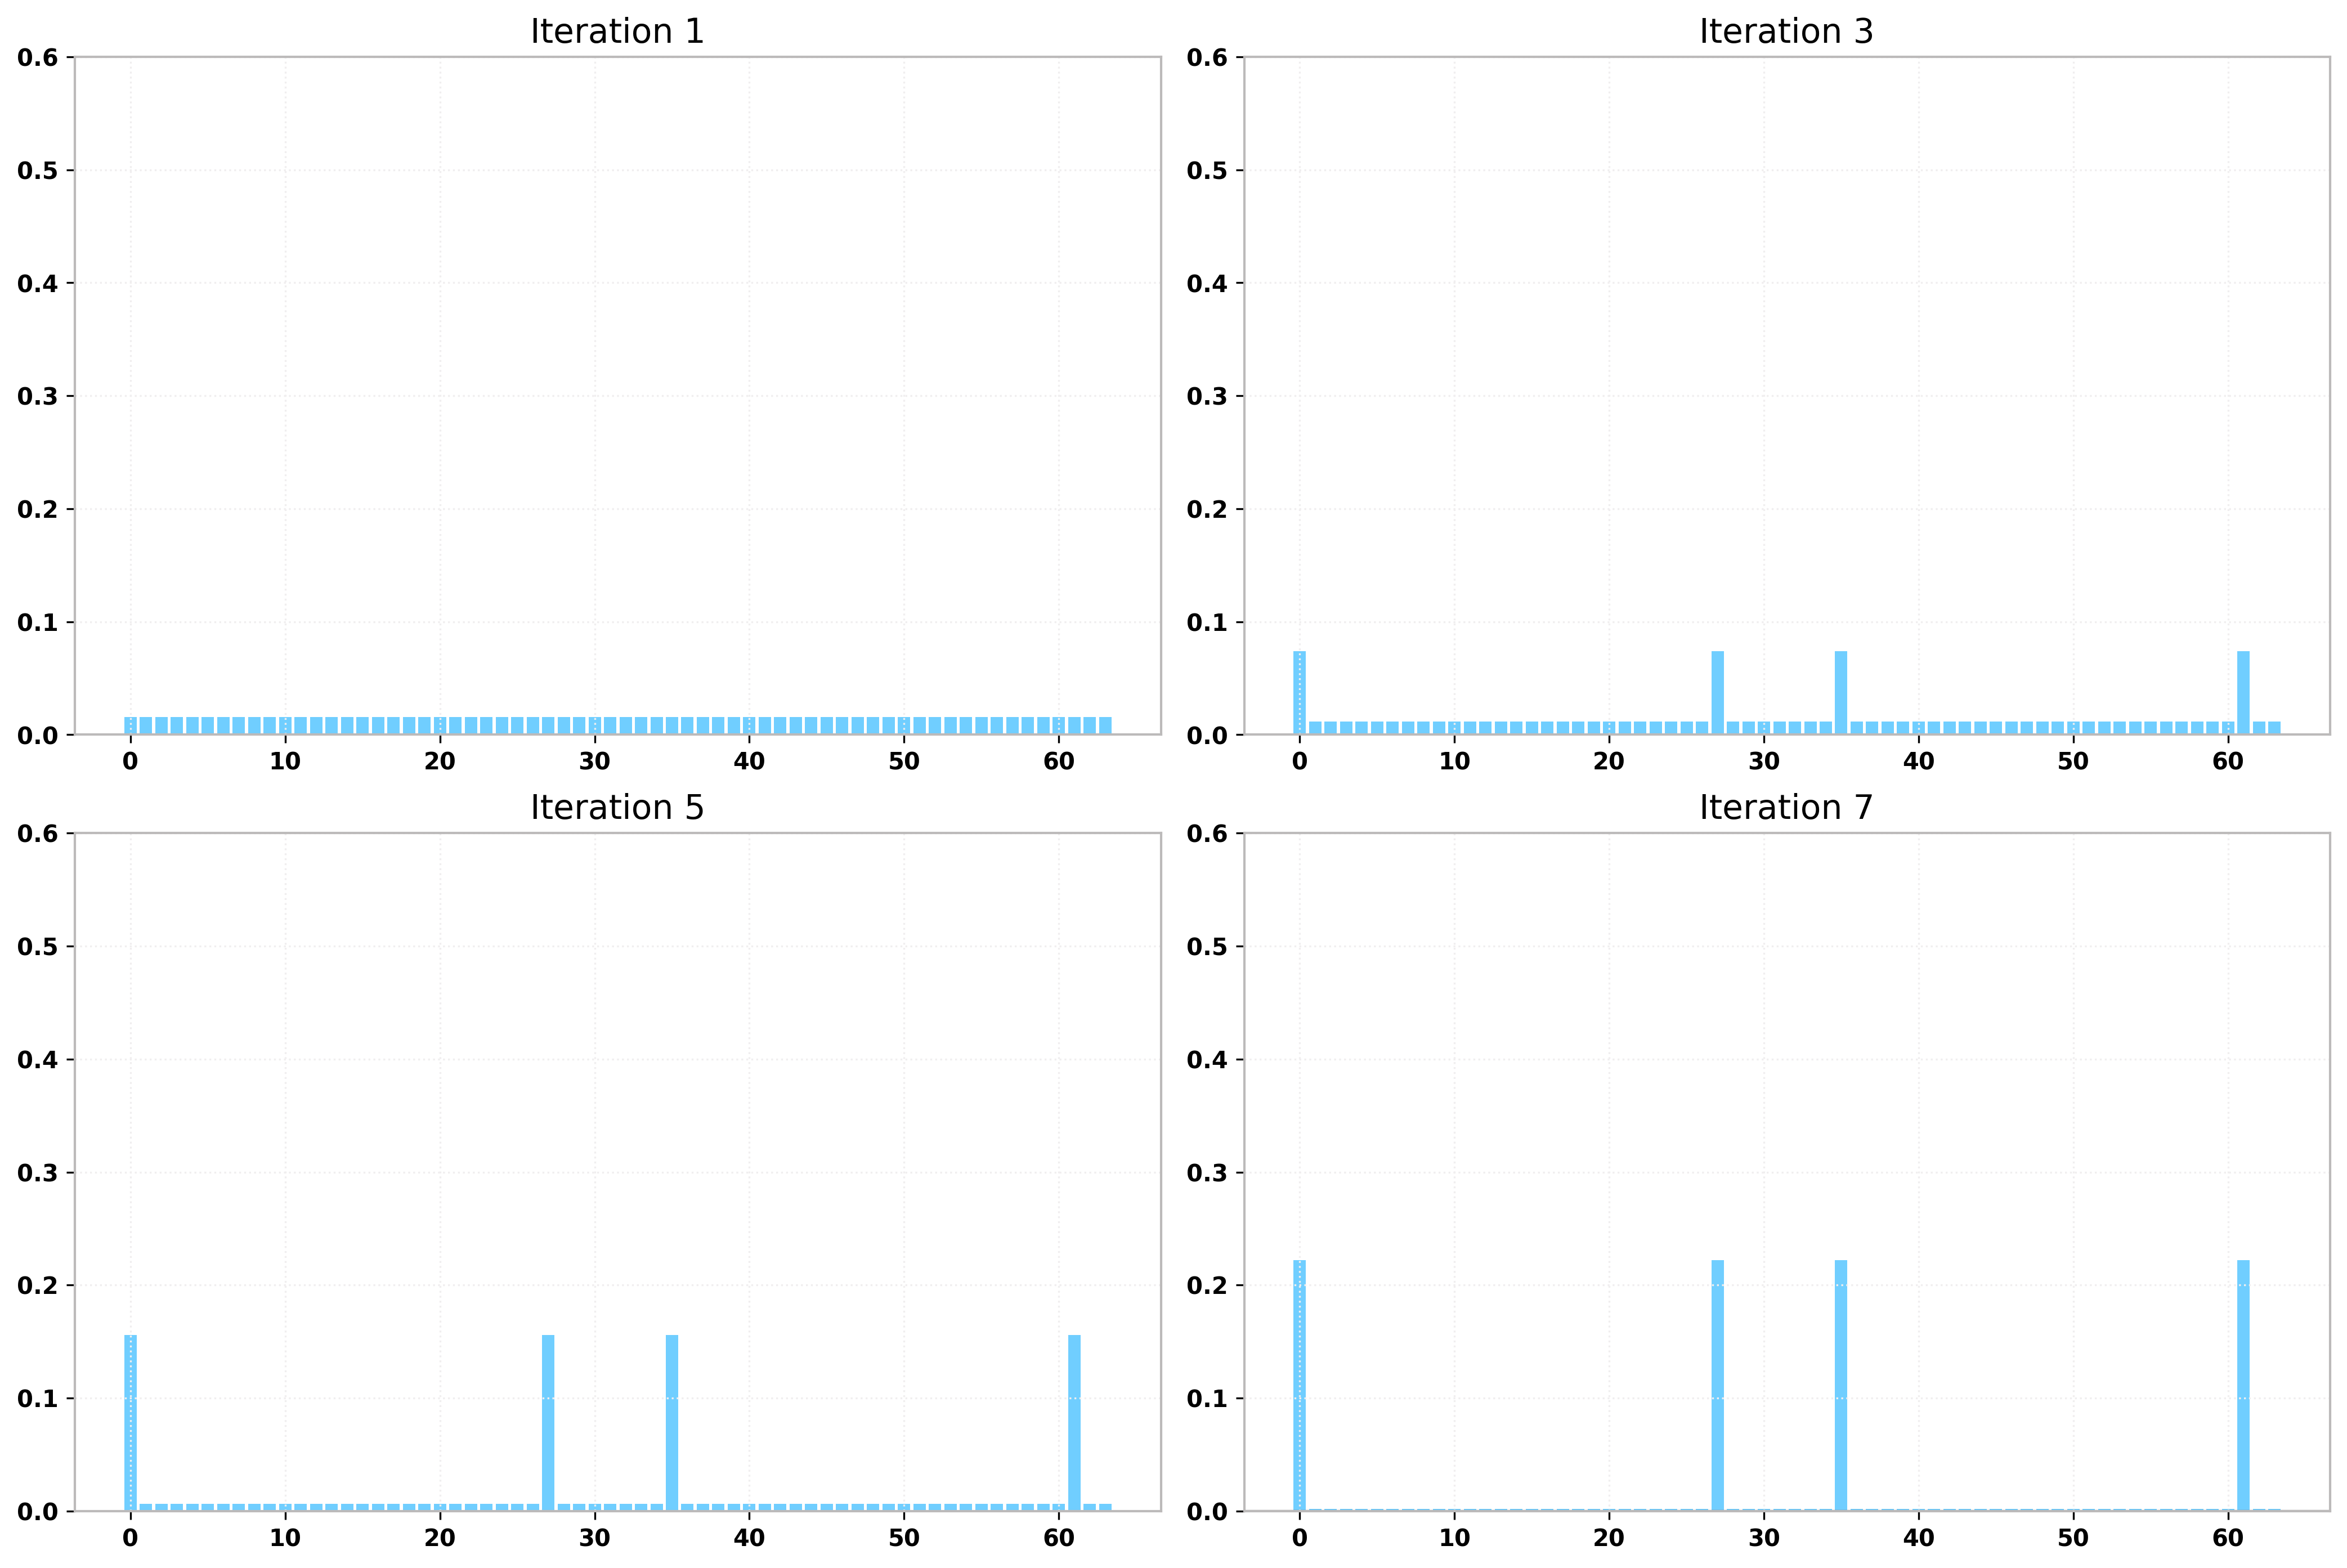

In [8]:
@qml.qnode(dev)
def circuit(iters):
    U(wires=range(n))
    qml.AmplitudeAmplification(U = U(wires = range(n)),
                               O = oracle(range(n), range(n, n + 5)),
                               iters = iters,
                               fixed_point=True,
                               work_wire = n + 5)

    return qml.probs(wires = range(n))

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
for i in range(1,9,2):
    output = circuit(iters=i)
    ax = axs[i // 4, i //2 % 2]
    ax.bar(range(len(output)), output)
    ax.set_ylim(0, 0.6)
    ax.set_title(f"Iteration {i}")

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.axhline(0, color='black', linewidth=1)
plt.show()

## Factorization

In [17]:
wires_m = [0, 1, 2]           # qubits needed to encode m
wires_k = [3, 4, 5]           # qubits needed to encode k
wires_solution = [6, 7, 8, 9, 10]  # qubits needed to encode the solution

dev = qml.device("default.qubit", wires=wires_m + wires_k + wires_solution, shots=1)
def add_k_fourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])
n_wires = len(dev.wires)

def multiplication(wires_m, wires_k, wires_solution):
    # prepare sol-qubits to counting
    qml.QFT(wires=wires_solution)

    # add m to the counter
    for i in range(len(wires_k)):
        for j in range(len(wires_m)):
            coeff = 2 ** (len(wires_m) + len(wires_k) - i - j - 2)
            qml.ctrl(add_k_fourier, control=[wires_k[i], wires_m[j]])(coeff, wires_solution)

    # return to computational basis
    qml.adjoint(qml.QFT)(wires=wires_solution)

@qml.qnode(dev)
def mul(m, k):
    # m and k codification
    qml.BasisEmbedding(m, wires=wires_m)
    qml.BasisEmbedding(k, wires=wires_k)

    # Apply multiplication
    multiplication(wires_m, wires_k, wires_solution)

    return qml.sample(wires=wires_solution)


print(f"The ket representation of the multiplication of 3 and 7 is {mul(3,7)}")

qml.draw_mpl(mul, show_all_wires=True)(3, 7)
plt.show()

The ket representation of the multiplication of 3 and 7 is [1 0 1 0 1]


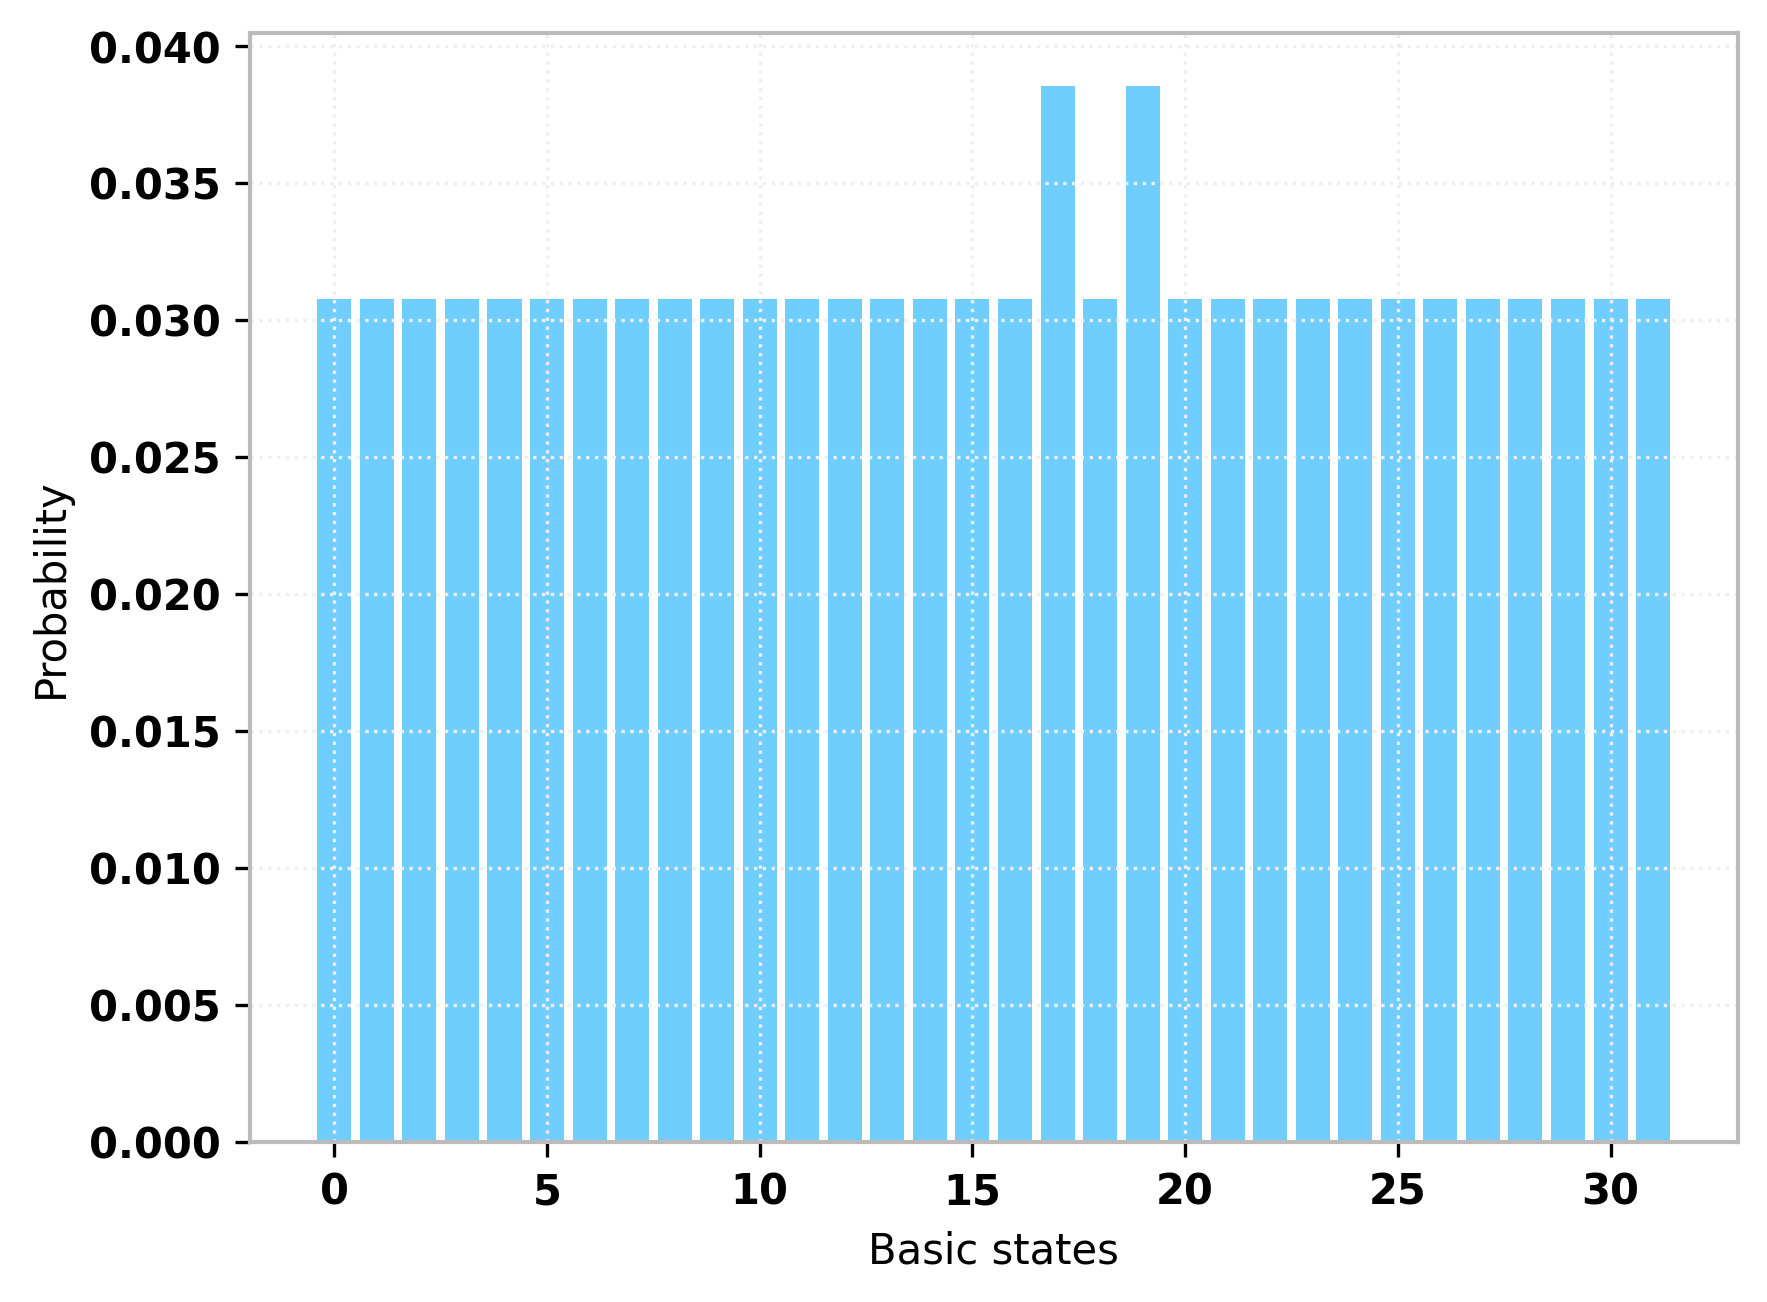

In [40]:
n = 323
a = int(np.ceil(np.log2(n)))      # a = 9
m = int(np.ceil(a / 2))           # m = 5
k = m + 1                         # k = 6

wires_m = range(m)                # range(0, 5)
wires_k = range(k, k + m)         # range(6, 11)
wires_solution = range(k + m, k + m + 9)  # range(11, 20)

dev = qml.device("default.qubit", wires=list(wires_m) + list(wires_k) + list(wires_solution))

n_wires = len(dev.wires)

@qml.qnode(dev)
def factorization(n, wires_m, wires_k, wires_solution):
    # Superposition of the input
    for wire in wires_m:
        qml.Hadamard(wires=wire)

    for wire in wires_k:
        qml.Hadamard(wires=wire)

    # Apply the multiplication
    multiplication(wires_m, wires_k, wires_solution)

    # Change sign of n
    qml.FlipSign(n, wires=wires_solution)

    # Uncompute multiplication
    qml.adjoint(multiplication)(wires_m, wires_k, wires_solution)

    # Apply Grover operator
    qml.GroverOperator(wires=list(wires_m) + list(wires_k))

    return qml.probs(wires=wires_m)


plt.bar(range(2 ** len(wires_m)), factorization(n, wires_m, wires_k, wires_solution))
plt.xlabel("Basic states")
plt.ylabel("Probability")
plt.show()

In [37]:
range(k,k+int(np.ceil(a/2)))

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [31]:
n = 323 # number we want to factor
a = int(np.ceil(np.log2(n)))
m = np.ceil(a/2)
k = m+1
wires_m = list(range(0,int(np.ceil(a/2))))             # qubits needed to encode m
wires_k = list(range(k,k+a/2)  )               # qubits needed to encode k
wires_solution = list(range(k+a/2,k+a/2+9))

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [32]:
a = range(0,int(np.ceil(a/2)))

range(0, 5)

In [33]:
list(a)

TypeError: 'int' object is not iterable

In [26]:
n = 323 # number we want to factor
a = int(np.ceil(np.log2(n)))
a

9

## QSVT

In [2]:
target_poly = [0, -3 * 0.5, 0, 5 * 0.5]
target_poly[::-1]

[2.5, 0, -1.5, 0]

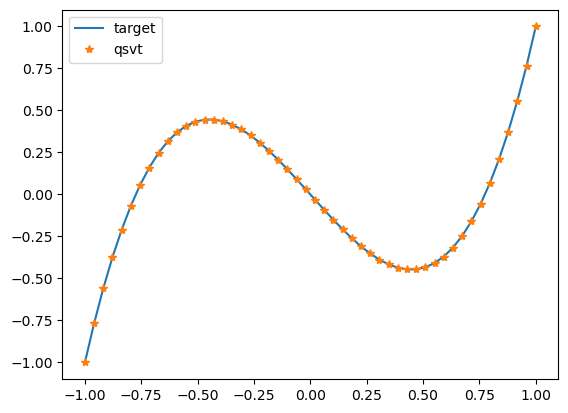

In [8]:
## qsvt
import matplotlib.pyplot as plt
def qsvt_circuit(a):
    qc = qml.qsvt(a, target_poly, encoding_wires=[0], block_encoding='embedding')
    return qc

def qsvt_out(a):
    qc = qsvt_circuit(a)
    out = qml.matrix(qc)
    return out[0,0]

a_vals = np.linspace(-1, 1, 50)
qsvt = [np.real(qsvt_out(a)) for a in a_vals]
target = [np.polyval(target_poly[::-1], a) for a in a_vals]

plt.plot(a_vals, target, label='target')
plt.plot(a_vals, qsvt, '*', label='qsvt')

plt.legend()
plt.show()
